In [1]:
import torch

import torch.optim as optim

import torch.nn as nn

import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from torchvision.utils import save_image

import struct

import numpy as np

import matplotlib

#matplotlib.use('agg')

import matplotlib.pyplot as plt



dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")



torch.manual_seed(2)



class OurDataset(Dataset):

    def __init__(self, fnData, dev, transform=None):

        self.transform = transform

        self.LoadData(fnData, dev)



    def LoadData(self, fnData, dev):

        fid = open(fnData,'rb')

        head = fid.read(16)

        data = fid.read()

        fid.close()



        res = struct.unpack(">iiii", head)

        data1 = struct.iter_unpack(">"+"B"*784,data)



        self.d = torch.zeros(res[1],1,res[2],res[3])

        for idx,k in enumerate(data1):

            tmp = torch.Tensor(k)

            tmp = tmp.view(1,res[2],res[3])

            if self.transform:

                tmp = self.transform(tmp)

            self.d[idx,:,:,:] = tmp



        self.d = self.d.to(dev)



    def __len__(self):

        return self.d.size()[0]

    def __getitem__(self, idx):

        return self.d[idx,:,:]



class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1) #out: 28 -> 14

        self.conv2 = nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1) #out: 14 -> 7

        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=0) #out: 5 -> 5

        self.fc1 = nn.Linear(5*5*8, 16)

        self.fc2 = nn.Linear(16, 1)



    def forward(self, x):

        x = F.relu(self.conv1(x))

        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))

        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))

        x = x.view(-1, 5*5*8)

        x = F.relu(self.fc1(x))

        return self.fc2(x)



class Gen(nn.Module):

    def __init__(self, zdim):

        super(Gen, self).__init__()

        self.firstDim = 16

        self.fc1 = nn.Linear(zdim, 4*4*self.firstDim)

        self.conv1 = nn.ConvTranspose2d( self.firstDim,  8, kernel_size=4, stride=2, padding=2, bias=False) #out: 6

        self.conv2 = nn.ConvTranspose2d( 8,  4, kernel_size=4, stride=2, padding=0, bias=False) #out: 14

        self.conv3 = nn.ConvTranspose2d( 4,  2, kernel_size=4, stride=2, padding=1, bias=False) #out: 28

        self.conv4 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)

        self.fc2 = nn.Linear(1, 784, bias=False)



    def forward(self, z):

        z = torch.nn.LeakyReLU(0.2)(self.fc1(z))

        z = z.view(z.size()[0],self.firstDim,4,4)

        z = torch.nn.LeakyReLU(0.2)(self.conv1(z))

        z = torch.nn.LeakyReLU(0.2)(self.conv2(z))

        z = torch.nn.LeakyReLU(0.2)(self.conv3(z))

        z = F.sigmoid(self.conv4(z))

        return z



def weights_init(m):

    if isinstance(m, torch.nn.Conv2d):

        #print(torch.typename(m))

        torch.nn.init.xavier_uniform_(m.weight.data)

        #m.weight.data.fill_(0.01)

        if m.bias is not None:

            m.bias.data.fill_(0)

    if isinstance(m, torch.nn.Linear):

        #print(torch.typename(m))

        torch.nn.init.xavier_uniform_(m.weight.data)

        #m.weight.data.fill_(0.01)

        if m.bias is not None:

            m.bias.data.fill_(0)

    if isinstance(m, torch.nn.ConvTranspose2d):

        #print(torch.typename(m))

        torch.nn.init.xavier_uniform_(m.weight.data)

        #m.weight.data.fill_(0.01)

        if m.bias is not None:

            m.bias.data.fill_(0)



trainData = OurDataset('C:/Users/Haoti/Desktop/ME498/code/cs446/MNIST/train-images-idx3-ubyte', dev, transform=transforms.Compose([

                           transforms.Normalize((255*0.,), (255.*1.0,))

                       ]))

print(trainData.__len__())

60000


In [3]:
discIter = 1

genIter = 1

numEpoch = 250

batchSize = 256

zdim = 64



trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, num_workers=0, drop_last=True)



disc = Net().to(dev)

gen = Gen(zdim).to(dev)



disc.apply(weights_init)

gen.apply(weights_init)



dopt = optim.Adam(disc.parameters(), lr=0.0002, weight_decay=0.0)

dopt.zero_grad()

gopt = optim.Adam(gen.parameters(), lr=0.0002, weight_decay=0.0)

gopt.zero_grad()



criterion = nn.BCEWithLogitsLoss()



target1 = torch.Tensor([1,]*batchSize + [0,]*batchSize).to(dev).view(-1,1)

target2 = torch.Tensor([1,]*batchSize).to(dev).view(-1,1)


In [ ]:
for epoch in range(numEpoch):

    for batch_idx,data in enumerate(trainLoader):

        z = 2*torch.rand(data.size()[0], zdim, device=dev)-1

        xhat = gen(z)



        if batch_idx==0 and epoch==0:

            plt.imshow(data[0,0,:,:].detach().cpu().numpy())

            plt.savefig("goal.pdf")

            #plt.show()



        if batch_idx==0 and epoch%10==0:

            tmpimg = xhat[0:64,:,:,:].detach().cpu()

            save_image(tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True)

            #plt.imshow(tmpimg[0,0,:,:].cpu().numpy())

            #plt.savefig("test_{0}.pdf".format(epoch))

            #plt.ion()

            #plt.show()

            #plt.pause(0.001)



        dopt.zero_grad()

        for k in range(discIter):

            logit = disc(torch.cat((data,xhat.detach()),0))
            #print('Size of logit is',logit.size())
            ##############################

            ## implement the discriminator loss (-logD trick)

            ##############################
            #print('Logit=',logit)
            
            #y_dis=
            loss = criterion((logit), torch.cat((torch.ones([data.size()[0],1]),torch.zeros([xhat.detach().size()[0],1]))))

            print("E: %d; B: %d; DLoss: %f" % (epoch,batch_idx,loss.item()))

            loss.backward()

            dopt.step()

            dopt.zero_grad()



        gopt.zero_grad()

        for k in range(genIter):

            xhat = gen(z)

            logit = disc(xhat)

            ##############################

            ## implement the generator loss (-logD trick)

            ##############################

            loss = criterion((logit), torch.ones([xhat.size()[0],1]))

            loss.backward()

            print("E: %d; B: %d; GLoss: %f" % (epoch,batch_idx,loss.item()))

            gopt.step()

            gopt.zero_grad()

D:\Applications\Anaco\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


E: 0; B: 0; DLoss: 0.686484
E: 0; B: 0; GLoss: 0.694809
E: 0; B: 1; DLoss: 0.685900
E: 0; B: 1; GLoss: 0.695343
E: 0; B: 2; DLoss: 0.684846
E: 0; B: 2; GLoss: 0.695823
E: 0; B: 3; DLoss: 0.684780
E: 0; B: 3; GLoss: 0.696190
E: 0; B: 4; DLoss: 0.684342
E: 0; B: 4; GLoss: 0.696491
E: 0; B: 5; DLoss: 0.683511
E: 0; B: 5; GLoss: 0.696790
E: 0; B: 6; DLoss: 0.682584
E: 0; B: 6; GLoss: 0.697069
E: 0; B: 7; DLoss: 0.682591
E: 0; B: 7; GLoss: 0.697322
E: 0; B: 8; DLoss: 0.681308
E: 0; B: 8; GLoss: 0.697557
E: 0; B: 9; DLoss: 0.681419
E: 0; B: 9; GLoss: 0.697783
E: 0; B: 10; DLoss: 0.680601
E: 0; B: 10; GLoss: 0.698037
E: 0; B: 11; DLoss: 0.679747
E: 0; B: 11; GLoss: 0.698281
E: 0; B: 12; DLoss: 0.679626
E: 0; B: 12; GLoss: 0.698540
E: 0; B: 13; DLoss: 0.678521
E: 0; B: 13; GLoss: 0.698792
E: 0; B: 14; DLoss: 0.678698
E: 0; B: 14; GLoss: 0.699041
E: 0; B: 15; DLoss: 0.677948
E: 0; B: 15; GLoss: 0.699303
E: 0; B: 16; DLoss: 0.676889
E: 0; B: 16; GLoss: 0.699594
E: 0; B: 17; DLoss: 0.676659
E: 0;

E: 0; B: 140; GLoss: 0.628978
E: 0; B: 141; DLoss: 0.619255
E: 0; B: 141; GLoss: 0.626682
E: 0; B: 142; DLoss: 0.621126
E: 0; B: 142; GLoss: 0.630794
E: 0; B: 143; DLoss: 0.624372
E: 0; B: 143; GLoss: 0.624380
E: 0; B: 144; DLoss: 0.627520
E: 0; B: 144; GLoss: 0.626526
E: 0; B: 145; DLoss: 0.636841
E: 0; B: 145; GLoss: 0.622031
E: 0; B: 146; DLoss: 0.636102
E: 0; B: 146; GLoss: 0.619808
E: 0; B: 147; DLoss: 0.648512
E: 0; B: 147; GLoss: 0.607612
E: 0; B: 148; DLoss: 0.639961
E: 0; B: 148; GLoss: 0.616276
E: 0; B: 149; DLoss: 0.650045
E: 0; B: 149; GLoss: 0.615659
E: 0; B: 150; DLoss: 0.651704
E: 0; B: 150; GLoss: 0.614837
E: 0; B: 151; DLoss: 0.656139
E: 0; B: 151; GLoss: 0.613578
E: 0; B: 152; DLoss: 0.653351
E: 0; B: 152; GLoss: 0.621664
E: 0; B: 153; DLoss: 0.656250
E: 0; B: 153; GLoss: 0.622306
E: 0; B: 154; DLoss: 0.658938
E: 0; B: 154; GLoss: 0.622480
E: 0; B: 155; DLoss: 0.661203
E: 0; B: 155; GLoss: 0.622082
E: 0; B: 156; DLoss: 0.662996
E: 0; B: 156; GLoss: 0.630838
E: 0; B: 1

E: 1; B: 45; DLoss: 0.198505
E: 1; B: 45; GLoss: 1.636389
E: 1; B: 46; DLoss: 0.197744
E: 1; B: 46; GLoss: 1.608323
E: 1; B: 47; DLoss: 0.194595
E: 1; B: 47; GLoss: 1.619658
E: 1; B: 48; DLoss: 0.186787
E: 1; B: 48; GLoss: 1.646901
E: 1; B: 49; DLoss: 0.189626
E: 1; B: 49; GLoss: 1.648018
E: 1; B: 50; DLoss: 0.180364
E: 1; B: 50; GLoss: 1.675140
E: 1; B: 51; DLoss: 0.178291
E: 1; B: 51; GLoss: 1.666072
E: 1; B: 52; DLoss: 0.174570
E: 1; B: 52; GLoss: 1.693375
E: 1; B: 53; DLoss: 0.172894
E: 1; B: 53; GLoss: 1.699679
E: 1; B: 54; DLoss: 0.169339
E: 1; B: 54; GLoss: 1.702862
E: 1; B: 55; DLoss: 0.163740
E: 1; B: 55; GLoss: 1.722588
E: 1; B: 56; DLoss: 0.162267
E: 1; B: 56; GLoss: 1.746062
E: 1; B: 57; DLoss: 0.159708
E: 1; B: 57; GLoss: 1.757563
E: 1; B: 58; DLoss: 0.156612
E: 1; B: 58; GLoss: 1.766140
E: 1; B: 59; DLoss: 0.153742
E: 1; B: 59; GLoss: 1.771614
E: 1; B: 60; DLoss: 0.148943
E: 1; B: 60; GLoss: 1.786181
E: 1; B: 61; DLoss: 0.144390
E: 1; B: 61; GLoss: 1.807768
E: 1; B: 62; D

E: 1; B: 183; GLoss: 3.660572
E: 1; B: 184; DLoss: 0.019392
E: 1; B: 184; GLoss: 3.663447
E: 1; B: 185; DLoss: 0.020856
E: 1; B: 185; GLoss: 3.631094
E: 1; B: 186; DLoss: 0.019164
E: 1; B: 186; GLoss: 3.684283
E: 1; B: 187; DLoss: 0.019981
E: 1; B: 187; GLoss: 3.669698
E: 1; B: 188; DLoss: 0.020639
E: 1; B: 188; GLoss: 3.656522
E: 1; B: 189; DLoss: 0.020675
E: 1; B: 189; GLoss: 3.667223
E: 1; B: 190; DLoss: 0.019790
E: 1; B: 190; GLoss: 3.692003
E: 1; B: 191; DLoss: 0.019202
E: 1; B: 191; GLoss: 3.718278
E: 1; B: 192; DLoss: 0.020743
E: 1; B: 192; GLoss: 3.700534
E: 1; B: 193; DLoss: 0.020418
E: 1; B: 193; GLoss: 3.693127
E: 1; B: 194; DLoss: 0.020754
E: 1; B: 194; GLoss: 3.687175
E: 1; B: 195; DLoss: 0.021183
E: 1; B: 195; GLoss: 3.730720
E: 1; B: 196; DLoss: 0.020574
E: 1; B: 196; GLoss: 3.751831
E: 1; B: 197; DLoss: 0.021800
E: 1; B: 197; GLoss: 3.688422
E: 1; B: 198; DLoss: 0.023421
E: 1; B: 198; GLoss: 3.774290
E: 1; B: 199; DLoss: 0.022142
E: 1; B: 199; GLoss: 3.736511
E: 1; B: 2

E: 2; B: 89; GLoss: 3.300056
E: 2; B: 90; DLoss: 0.024132
E: 2; B: 90; GLoss: 3.305937
E: 2; B: 91; DLoss: 0.024591
E: 2; B: 91; GLoss: 3.255246
E: 2; B: 92; DLoss: 0.023584
E: 2; B: 92; GLoss: 3.282293
E: 2; B: 93; DLoss: 0.022809
E: 2; B: 93; GLoss: 3.298880
E: 2; B: 94; DLoss: 0.023332
E: 2; B: 94; GLoss: 3.270907
E: 2; B: 95; DLoss: 0.023326
E: 2; B: 95; GLoss: 3.313020
E: 2; B: 96; DLoss: 0.023336
E: 2; B: 96; GLoss: 3.312330
E: 2; B: 97; DLoss: 0.022490
E: 2; B: 97; GLoss: 3.324933
E: 2; B: 98; DLoss: 0.022849
E: 2; B: 98; GLoss: 3.312969
E: 2; B: 99; DLoss: 0.020473
E: 2; B: 99; GLoss: 3.386856
E: 2; B: 100; DLoss: 0.021615
E: 2; B: 100; GLoss: 3.338750
E: 2; B: 101; DLoss: 0.021879
E: 2; B: 101; GLoss: 3.335547
E: 2; B: 102; DLoss: 0.020961
E: 2; B: 102; GLoss: 3.402389
E: 2; B: 103; DLoss: 0.022209
E: 2; B: 103; GLoss: 3.353676
E: 2; B: 104; DLoss: 0.022036
E: 2; B: 104; GLoss: 3.372186
E: 2; B: 105; DLoss: 0.021529
E: 2; B: 105; GLoss: 3.410753
E: 2; B: 106; DLoss: 0.021289
E

E: 2; B: 226; GLoss: 4.343648
E: 2; B: 227; DLoss: 0.009757
E: 2; B: 227; GLoss: 4.378572
E: 2; B: 228; DLoss: 0.010712
E: 2; B: 228; GLoss: 4.331888
E: 2; B: 229; DLoss: 0.009954
E: 2; B: 229; GLoss: 4.400854
E: 2; B: 230; DLoss: 0.009516
E: 2; B: 230; GLoss: 4.396344
E: 2; B: 231; DLoss: 0.010551
E: 2; B: 231; GLoss: 4.344501
E: 2; B: 232; DLoss: 0.009559
E: 2; B: 232; GLoss: 4.380033
E: 2; B: 233; DLoss: 0.010009
E: 2; B: 233; GLoss: 4.376675
E: 3; B: 0; DLoss: 0.009809
E: 3; B: 0; GLoss: 4.440272
E: 3; B: 1; DLoss: 0.010586
E: 3; B: 1; GLoss: 4.373816
E: 3; B: 2; DLoss: 0.009553
E: 3; B: 2; GLoss: 4.417802
E: 3; B: 3; DLoss: 0.009380
E: 3; B: 3; GLoss: 4.413642
E: 3; B: 4; DLoss: 0.009707
E: 3; B: 4; GLoss: 4.496909
E: 3; B: 5; DLoss: 0.009014
E: 3; B: 5; GLoss: 4.451019
E: 3; B: 6; DLoss: 0.008621
E: 3; B: 6; GLoss: 4.446255
E: 3; B: 7; DLoss: 0.008432
E: 3; B: 7; GLoss: 4.464819
E: 3; B: 8; DLoss: 0.009328
E: 3; B: 8; GLoss: 4.514102
E: 3; B: 9; DLoss: 0.009144
E: 3; B: 9; GLoss:

E: 3; B: 133; DLoss: 0.008306
E: 3; B: 133; GLoss: 5.076452
E: 3; B: 134; DLoss: 0.005701
E: 3; B: 134; GLoss: 5.250748
E: 3; B: 135; DLoss: 0.006600
E: 3; B: 135; GLoss: 5.258000
E: 3; B: 136; DLoss: 0.009113
E: 3; B: 136; GLoss: 5.243514
E: 3; B: 137; DLoss: 0.008352
E: 3; B: 137; GLoss: 5.216333
E: 3; B: 138; DLoss: 0.007970
E: 3; B: 138; GLoss: 5.206308
E: 3; B: 139; DLoss: 0.007096
E: 3; B: 139; GLoss: 5.226820
E: 3; B: 140; DLoss: 0.006833
E: 3; B: 140; GLoss: 5.272928
E: 3; B: 141; DLoss: 0.008458
E: 3; B: 141; GLoss: 5.140889
E: 3; B: 142; DLoss: 0.006611
E: 3; B: 142; GLoss: 5.195223
E: 3; B: 143; DLoss: 0.007137
E: 3; B: 143; GLoss: 5.095763
E: 3; B: 144; DLoss: 0.007138
E: 3; B: 144; GLoss: 5.222191
E: 3; B: 145; DLoss: 0.007612
E: 3; B: 145; GLoss: 5.154553
E: 3; B: 146; DLoss: 0.007757
E: 3; B: 146; GLoss: 5.210975
E: 3; B: 147; DLoss: 0.007519
E: 3; B: 147; GLoss: 5.191403
E: 3; B: 148; DLoss: 0.006987
E: 3; B: 148; GLoss: 5.173724
E: 3; B: 149; DLoss: 0.007510
E: 3; B: 1

E: 4; B: 37; GLoss: 5.453915
E: 4; B: 38; DLoss: 0.011063
E: 4; B: 38; GLoss: 5.533089
E: 4; B: 39; DLoss: 0.011783
E: 4; B: 39; GLoss: 5.557302
E: 4; B: 40; DLoss: 0.012934
E: 4; B: 40; GLoss: 5.504305
E: 4; B: 41; DLoss: 0.010415
E: 4; B: 41; GLoss: 5.651287
E: 4; B: 42; DLoss: 0.010988
E: 4; B: 42; GLoss: 5.683576
E: 4; B: 43; DLoss: 0.011283
E: 4; B: 43; GLoss: 5.694477
E: 4; B: 44; DLoss: 0.010910
E: 4; B: 44; GLoss: 5.697607
E: 4; B: 45; DLoss: 0.012702
E: 4; B: 45; GLoss: 5.561871
E: 4; B: 46; DLoss: 0.011836
E: 4; B: 46; GLoss: 5.667631
E: 4; B: 47; DLoss: 0.013752
E: 4; B: 47; GLoss: 5.579278
E: 4; B: 48; DLoss: 0.013574
E: 4; B: 48; GLoss: 5.745220
E: 4; B: 49; DLoss: 0.014777
E: 4; B: 49; GLoss: 5.694792
E: 4; B: 50; DLoss: 0.011936
E: 4; B: 50; GLoss: 5.692374
E: 4; B: 51; DLoss: 0.012903
E: 4; B: 51; GLoss: 5.640463
E: 4; B: 52; DLoss: 0.012125
E: 4; B: 52; GLoss: 5.792821
E: 4; B: 53; DLoss: 0.015323
E: 4; B: 53; GLoss: 5.806002
E: 4; B: 54; DLoss: 0.011792
E: 4; B: 54; G

E: 4; B: 176; GLoss: 6.080657
E: 4; B: 177; DLoss: 0.018000
E: 4; B: 177; GLoss: 5.901352
E: 4; B: 178; DLoss: 0.014413
E: 4; B: 178; GLoss: 5.826813
E: 4; B: 179; DLoss: 0.019656
E: 4; B: 179; GLoss: 5.913539
E: 4; B: 180; DLoss: 0.018974
E: 4; B: 180; GLoss: 5.914274
E: 4; B: 181; DLoss: 0.021413
E: 4; B: 181; GLoss: 5.853496
E: 4; B: 182; DLoss: 0.021132
E: 4; B: 182; GLoss: 6.131642
E: 4; B: 183; DLoss: 0.013674
E: 4; B: 183; GLoss: 5.909736
E: 4; B: 184; DLoss: 0.015372
E: 4; B: 184; GLoss: 6.007270
E: 4; B: 185; DLoss: 0.016187
E: 4; B: 185; GLoss: 6.195463
E: 4; B: 186; DLoss: 0.027522
E: 4; B: 186; GLoss: 6.126848
E: 4; B: 187; DLoss: 0.020571
E: 4; B: 187; GLoss: 6.021903
E: 4; B: 188; DLoss: 0.020324
E: 4; B: 188; GLoss: 5.838681
E: 4; B: 189; DLoss: 0.017150
E: 4; B: 189; GLoss: 5.783247
E: 4; B: 190; DLoss: 0.019473
E: 4; B: 190; GLoss: 5.885551
E: 4; B: 191; DLoss: 0.018463
E: 4; B: 191; GLoss: 5.945065
E: 4; B: 192; DLoss: 0.010181
E: 4; B: 192; GLoss: 6.145592
E: 4; B: 1

E: 5; B: 82; GLoss: 5.823481
E: 5; B: 83; DLoss: 0.018421
E: 5; B: 83; GLoss: 5.910804
E: 5; B: 84; DLoss: 0.017238
E: 5; B: 84; GLoss: 5.738469
E: 5; B: 85; DLoss: 0.012895
E: 5; B: 85; GLoss: 5.881537
E: 5; B: 86; DLoss: 0.014217
E: 5; B: 86; GLoss: 5.936601
E: 5; B: 87; DLoss: 0.012701
E: 5; B: 87; GLoss: 5.839971
E: 5; B: 88; DLoss: 0.024500
E: 5; B: 88; GLoss: 6.033286
E: 5; B: 89; DLoss: 0.017241
E: 5; B: 89; GLoss: 5.884253
E: 5; B: 90; DLoss: 0.021505
E: 5; B: 90; GLoss: 5.773623
E: 5; B: 91; DLoss: 0.019056
E: 5; B: 91; GLoss: 5.959001
E: 5; B: 92; DLoss: 0.012399
E: 5; B: 92; GLoss: 5.805108
E: 5; B: 93; DLoss: 0.024509
E: 5; B: 93; GLoss: 5.841173
E: 5; B: 94; DLoss: 0.017198
E: 5; B: 94; GLoss: 5.988982
E: 5; B: 95; DLoss: 0.015110
E: 5; B: 95; GLoss: 5.839961
E: 5; B: 96; DLoss: 0.020027
E: 5; B: 96; GLoss: 5.908243
E: 5; B: 97; DLoss: 0.019584
E: 5; B: 97; GLoss: 5.526370
E: 5; B: 98; DLoss: 0.021053
E: 5; B: 98; GLoss: 6.065384
E: 5; B: 99; DLoss: 0.024228
E: 5; B: 99; G

E: 5; B: 220; DLoss: 0.036344
E: 5; B: 220; GLoss: 5.925403
E: 5; B: 221; DLoss: 0.032798
E: 5; B: 221; GLoss: 5.933692
E: 5; B: 222; DLoss: 0.024049
E: 5; B: 222; GLoss: 6.003764
E: 5; B: 223; DLoss: 0.037397
E: 5; B: 223; GLoss: 5.918320
E: 5; B: 224; DLoss: 0.029069
E: 5; B: 224; GLoss: 6.150651
E: 5; B: 225; DLoss: 0.051651
E: 5; B: 225; GLoss: 6.104635
E: 5; B: 226; DLoss: 0.035765
E: 5; B: 226; GLoss: 6.159766
E: 5; B: 227; DLoss: 0.036275
E: 5; B: 227; GLoss: 5.730208
E: 5; B: 228; DLoss: 0.040763
E: 5; B: 228; GLoss: 5.841156
E: 5; B: 229; DLoss: 0.024490
E: 5; B: 229; GLoss: 6.124279
E: 5; B: 230; DLoss: 0.031220
E: 5; B: 230; GLoss: 5.947043
E: 5; B: 231; DLoss: 0.047885
E: 5; B: 231; GLoss: 6.061550
E: 5; B: 232; DLoss: 0.025853
E: 5; B: 232; GLoss: 6.319098
E: 5; B: 233; DLoss: 0.032805
E: 5; B: 233; GLoss: 6.556294
E: 6; B: 0; DLoss: 0.024927
E: 6; B: 0; GLoss: 6.542763
E: 6; B: 1; DLoss: 0.037585
E: 6; B: 1; GLoss: 5.829156
E: 6; B: 2; DLoss: 0.051313
E: 6; B: 2; GLoss: 5

E: 6; B: 126; GLoss: 5.727223
E: 6; B: 127; DLoss: 0.069761
E: 6; B: 127; GLoss: 5.693564
E: 6; B: 128; DLoss: 0.058513
E: 6; B: 128; GLoss: 5.247429
E: 6; B: 129; DLoss: 0.064382
E: 6; B: 129; GLoss: 4.726465
E: 6; B: 130; DLoss: 0.063565
E: 6; B: 130; GLoss: 4.253995
E: 6; B: 131; DLoss: 0.039301
E: 6; B: 131; GLoss: 4.099806
E: 6; B: 132; DLoss: 0.052041
E: 6; B: 132; GLoss: 4.015238
E: 6; B: 133; DLoss: 0.063874
E: 6; B: 133; GLoss: 4.173361
E: 6; B: 134; DLoss: 0.049728
E: 6; B: 134; GLoss: 4.367617
E: 6; B: 135; DLoss: 0.072370
E: 6; B: 135; GLoss: 4.433047
E: 6; B: 136; DLoss: 0.055306
E: 6; B: 136; GLoss: 4.103393
E: 6; B: 137; DLoss: 0.057102
E: 6; B: 137; GLoss: 3.995519
E: 6; B: 138; DLoss: 0.076409
E: 6; B: 138; GLoss: 3.667334
E: 6; B: 139; DLoss: 0.074952
E: 6; B: 139; GLoss: 3.732371
E: 6; B: 140; DLoss: 0.103233
E: 6; B: 140; GLoss: 3.853743
E: 6; B: 141; DLoss: 0.079103
E: 6; B: 141; GLoss: 4.083606
E: 6; B: 142; DLoss: 0.113026
E: 6; B: 142; GLoss: 4.422643
E: 6; B: 1

E: 7; B: 30; GLoss: 4.171048
E: 7; B: 31; DLoss: 0.047648
E: 7; B: 31; GLoss: 4.556726
E: 7; B: 32; DLoss: 0.036380
E: 7; B: 32; GLoss: 4.578151
E: 7; B: 33; DLoss: 0.038213
E: 7; B: 33; GLoss: 4.306047
E: 7; B: 34; DLoss: 0.041393
E: 7; B: 34; GLoss: 4.365385
E: 7; B: 35; DLoss: 0.038877
E: 7; B: 35; GLoss: 4.601304
E: 7; B: 36; DLoss: 0.054802
E: 7; B: 36; GLoss: 4.569340
E: 7; B: 37; DLoss: 0.029900
E: 7; B: 37; GLoss: 4.667928
E: 7; B: 38; DLoss: 0.042322
E: 7; B: 38; GLoss: 4.553251
E: 7; B: 39; DLoss: 0.052719
E: 7; B: 39; GLoss: 4.446716
E: 7; B: 40; DLoss: 0.056065
E: 7; B: 40; GLoss: 4.383999
E: 7; B: 41; DLoss: 0.051688
E: 7; B: 41; GLoss: 4.447083
E: 7; B: 42; DLoss: 0.068609
E: 7; B: 42; GLoss: 4.186030
E: 7; B: 43; DLoss: 0.047164
E: 7; B: 43; GLoss: 4.179756
E: 7; B: 44; DLoss: 0.055323
E: 7; B: 44; GLoss: 4.106904
E: 7; B: 45; DLoss: 0.051806
E: 7; B: 45; GLoss: 3.968757
E: 7; B: 46; DLoss: 0.053363
E: 7; B: 46; GLoss: 3.907017
E: 7; B: 47; DLoss: 0.076317
E: 7; B: 47; G

E: 7; B: 169; GLoss: 4.204791
E: 7; B: 170; DLoss: 0.038416
E: 7; B: 170; GLoss: 4.287381
E: 7; B: 171; DLoss: 0.048111
E: 7; B: 171; GLoss: 4.288718
E: 7; B: 172; DLoss: 0.056938
E: 7; B: 172; GLoss: 4.176597
E: 7; B: 173; DLoss: 0.024432
E: 7; B: 173; GLoss: 4.150609
E: 7; B: 174; DLoss: 0.035453
E: 7; B: 174; GLoss: 4.249401
E: 7; B: 175; DLoss: 0.052154
E: 7; B: 175; GLoss: 4.119182
E: 7; B: 176; DLoss: 0.036116
E: 7; B: 176; GLoss: 4.047670
E: 7; B: 177; DLoss: 0.035721
E: 7; B: 177; GLoss: 4.040272
E: 7; B: 178; DLoss: 0.034905
E: 7; B: 178; GLoss: 3.929752
E: 7; B: 179; DLoss: 0.036597
E: 7; B: 179; GLoss: 4.075939
E: 7; B: 180; DLoss: 0.042266
E: 7; B: 180; GLoss: 4.103271
E: 7; B: 181; DLoss: 0.047100
E: 7; B: 181; GLoss: 4.031191
E: 7; B: 182; DLoss: 0.038055
E: 7; B: 182; GLoss: 3.968971
E: 7; B: 183; DLoss: 0.047221
E: 7; B: 183; GLoss: 3.844991
E: 7; B: 184; DLoss: 0.044263
E: 7; B: 184; GLoss: 3.840151
E: 7; B: 185; DLoss: 0.033133
E: 7; B: 185; GLoss: 3.953772
E: 7; B: 1

E: 8; B: 75; DLoss: 0.046942
E: 8; B: 75; GLoss: 4.360377
E: 8; B: 76; DLoss: 0.050545
E: 8; B: 76; GLoss: 4.629766
E: 8; B: 77; DLoss: 0.068109
E: 8; B: 77; GLoss: 4.641805
E: 8; B: 78; DLoss: 0.058015
E: 8; B: 78; GLoss: 4.811804
E: 8; B: 79; DLoss: 0.049311
E: 8; B: 79; GLoss: 4.562638
E: 8; B: 80; DLoss: 0.071644
E: 8; B: 80; GLoss: 4.494729
E: 8; B: 81; DLoss: 0.055508
E: 8; B: 81; GLoss: 4.479196
E: 8; B: 82; DLoss: 0.055708
E: 8; B: 82; GLoss: 4.218966
E: 8; B: 83; DLoss: 0.051412
E: 8; B: 83; GLoss: 4.576517
E: 8; B: 84; DLoss: 0.056543
E: 8; B: 84; GLoss: 4.364076
E: 8; B: 85; DLoss: 0.062550
E: 8; B: 85; GLoss: 4.642475
E: 8; B: 86; DLoss: 0.098235
E: 8; B: 86; GLoss: 4.320881
E: 8; B: 87; DLoss: 0.055765
E: 8; B: 87; GLoss: 4.202260
E: 8; B: 88; DLoss: 0.055473
E: 8; B: 88; GLoss: 4.073825
E: 8; B: 89; DLoss: 0.051474
E: 8; B: 89; GLoss: 4.095632
E: 8; B: 90; DLoss: 0.064832
E: 8; B: 90; GLoss: 4.457751
E: 8; B: 91; DLoss: 0.057962
E: 8; B: 91; GLoss: 4.606091
E: 8; B: 92; D

E: 8; B: 212; GLoss: 3.492709
E: 8; B: 213; DLoss: 0.054975
E: 8; B: 213; GLoss: 3.513728
E: 8; B: 214; DLoss: 0.091122
E: 8; B: 214; GLoss: 3.577849
E: 8; B: 215; DLoss: 0.067997
E: 8; B: 215; GLoss: 3.656932
E: 8; B: 216; DLoss: 0.081076
E: 8; B: 216; GLoss: 3.474522
E: 8; B: 217; DLoss: 0.059500
E: 8; B: 217; GLoss: 3.526763
E: 8; B: 218; DLoss: 0.085137
E: 8; B: 218; GLoss: 3.559298
E: 8; B: 219; DLoss: 0.079883
E: 8; B: 219; GLoss: 3.395019
E: 8; B: 220; DLoss: 0.086258
E: 8; B: 220; GLoss: 3.360555
E: 8; B: 221; DLoss: 0.076813
E: 8; B: 221; GLoss: 3.456890
E: 8; B: 222; DLoss: 0.048782
E: 8; B: 222; GLoss: 3.693826
E: 8; B: 223; DLoss: 0.069751
E: 8; B: 223; GLoss: 3.847123
E: 8; B: 224; DLoss: 0.087733
E: 8; B: 224; GLoss: 3.760592
E: 8; B: 225; DLoss: 0.096532
E: 8; B: 225; GLoss: 3.700097
E: 8; B: 226; DLoss: 0.104732
E: 8; B: 226; GLoss: 3.395732
E: 8; B: 227; DLoss: 0.076468
E: 8; B: 227; GLoss: 3.274078
E: 8; B: 228; DLoss: 0.077794
E: 8; B: 228; GLoss: 3.328096
E: 8; B: 2

E: 9; B: 119; DLoss: 0.113985
E: 9; B: 119; GLoss: 3.117108
E: 9; B: 120; DLoss: 0.107989
E: 9; B: 120; GLoss: 3.226472
E: 9; B: 121; DLoss: 0.090325
E: 9; B: 121; GLoss: 3.217257
E: 9; B: 122; DLoss: 0.128586
E: 9; B: 122; GLoss: 3.031290
E: 9; B: 123; DLoss: 0.107707
E: 9; B: 123; GLoss: 3.055238
E: 9; B: 124; DLoss: 0.157968
E: 9; B: 124; GLoss: 2.932733
E: 9; B: 125; DLoss: 0.116069
E: 9; B: 125; GLoss: 2.925999
E: 9; B: 126; DLoss: 0.121807
E: 9; B: 126; GLoss: 2.964657
E: 9; B: 127; DLoss: 0.152711
E: 9; B: 127; GLoss: 2.988448
E: 9; B: 128; DLoss: 0.162091
E: 9; B: 128; GLoss: 2.943947
E: 9; B: 129; DLoss: 0.113361
E: 9; B: 129; GLoss: 2.906605
E: 9; B: 130; DLoss: 0.123960
E: 9; B: 130; GLoss: 2.871203
E: 9; B: 131; DLoss: 0.137446
E: 9; B: 131; GLoss: 2.900604
E: 9; B: 132; DLoss: 0.113618
E: 9; B: 132; GLoss: 2.943611
E: 9; B: 133; DLoss: 0.153188
E: 9; B: 133; GLoss: 3.066852
E: 9; B: 134; DLoss: 0.142758
E: 9; B: 134; GLoss: 3.133578
E: 9; B: 135; DLoss: 0.154644
E: 9; B: 1

E: 10; B: 22; DLoss: 0.077757
E: 10; B: 22; GLoss: 3.296154
E: 10; B: 23; DLoss: 0.145532
E: 10; B: 23; GLoss: 3.493944
E: 10; B: 24; DLoss: 0.091768
E: 10; B: 24; GLoss: 3.227409
E: 10; B: 25; DLoss: 0.088480
E: 10; B: 25; GLoss: 3.169383
E: 10; B: 26; DLoss: 0.096759
E: 10; B: 26; GLoss: 3.129818
E: 10; B: 27; DLoss: 0.097680
E: 10; B: 27; GLoss: 3.192623
E: 10; B: 28; DLoss: 0.109851
E: 10; B: 28; GLoss: 3.126111
E: 10; B: 29; DLoss: 0.079823
E: 10; B: 29; GLoss: 3.276558
E: 10; B: 30; DLoss: 0.102895
E: 10; B: 30; GLoss: 3.175672
E: 10; B: 31; DLoss: 0.082730
E: 10; B: 31; GLoss: 3.393905
E: 10; B: 32; DLoss: 0.103005
E: 10; B: 32; GLoss: 3.159706
E: 10; B: 33; DLoss: 0.091239
E: 10; B: 33; GLoss: 3.379533
E: 10; B: 34; DLoss: 0.081177
E: 10; B: 34; GLoss: 3.343900
E: 10; B: 35; DLoss: 0.082781
E: 10; B: 35; GLoss: 3.476391
E: 10; B: 36; DLoss: 0.078675
E: 10; B: 36; GLoss: 3.441871
E: 10; B: 37; DLoss: 0.078060
E: 10; B: 37; GLoss: 3.590436
E: 10; B: 38; DLoss: 0.091891
E: 10; B: 

E: 10; B: 157; DLoss: 0.049704
E: 10; B: 157; GLoss: 3.489627
E: 10; B: 158; DLoss: 0.077475
E: 10; B: 158; GLoss: 3.487481
E: 10; B: 159; DLoss: 0.064197
E: 10; B: 159; GLoss: 3.448158
E: 10; B: 160; DLoss: 0.082371
E: 10; B: 160; GLoss: 3.303558
E: 10; B: 161; DLoss: 0.060608
E: 10; B: 161; GLoss: 3.236753
E: 10; B: 162; DLoss: 0.061783
E: 10; B: 162; GLoss: 3.387645
E: 10; B: 163; DLoss: 0.047007
E: 10; B: 163; GLoss: 3.341794
E: 10; B: 164; DLoss: 0.053637
E: 10; B: 164; GLoss: 3.543961
E: 10; B: 165; DLoss: 0.086848
E: 10; B: 165; GLoss: 3.481291
E: 10; B: 166; DLoss: 0.050267
E: 10; B: 166; GLoss: 3.493031
E: 10; B: 167; DLoss: 0.059222
E: 10; B: 167; GLoss: 3.496567
E: 10; B: 168; DLoss: 0.096355
E: 10; B: 168; GLoss: 3.363379
E: 10; B: 169; DLoss: 0.079771
E: 10; B: 169; GLoss: 3.283099
E: 10; B: 170; DLoss: 0.042486
E: 10; B: 170; GLoss: 3.263278
E: 10; B: 171; DLoss: 0.067390
E: 10; B: 171; GLoss: 3.292082
E: 10; B: 172; DLoss: 0.069519
E: 10; B: 172; GLoss: 3.392797
E: 10; B

E: 11; B: 57; GLoss: 4.305554
E: 11; B: 58; DLoss: 0.091326
E: 11; B: 58; GLoss: 4.141603
E: 11; B: 59; DLoss: 0.069316
E: 11; B: 59; GLoss: 4.221024
E: 11; B: 60; DLoss: 0.056190
E: 11; B: 60; GLoss: 4.278803
E: 11; B: 61; DLoss: 0.087946
E: 11; B: 61; GLoss: 4.167711
E: 11; B: 62; DLoss: 0.078033
E: 11; B: 62; GLoss: 4.139709
E: 11; B: 63; DLoss: 0.065789
E: 11; B: 63; GLoss: 4.010850
E: 11; B: 64; DLoss: 0.096647
E: 11; B: 64; GLoss: 3.914283
E: 11; B: 65; DLoss: 0.096162
E: 11; B: 65; GLoss: 3.876987
E: 11; B: 66; DLoss: 0.062894
E: 11; B: 66; GLoss: 3.785246
E: 11; B: 67; DLoss: 0.073849
E: 11; B: 67; GLoss: 3.929856
E: 11; B: 68; DLoss: 0.077238
E: 11; B: 68; GLoss: 3.896978
E: 11; B: 69; DLoss: 0.051891
E: 11; B: 69; GLoss: 3.887325
E: 11; B: 70; DLoss: 0.073492
E: 11; B: 70; GLoss: 4.098704
E: 11; B: 71; DLoss: 0.064695
E: 11; B: 71; GLoss: 4.089455
E: 11; B: 72; DLoss: 0.072387
E: 11; B: 72; GLoss: 4.227319
E: 11; B: 73; DLoss: 0.069721
E: 11; B: 73; GLoss: 3.955559
E: 11; B: 

E: 11; B: 191; GLoss: 3.560566
E: 11; B: 192; DLoss: 0.195864
E: 11; B: 192; GLoss: 3.350107
E: 11; B: 193; DLoss: 0.184902
E: 11; B: 193; GLoss: 2.930054
E: 11; B: 194; DLoss: 0.133834
E: 11; B: 194; GLoss: 2.944789
E: 11; B: 195; DLoss: 0.157201
E: 11; B: 195; GLoss: 2.993919
E: 11; B: 196; DLoss: 0.149303
E: 11; B: 196; GLoss: 3.179282
E: 11; B: 197; DLoss: 0.153452
E: 11; B: 197; GLoss: 3.453932
E: 11; B: 198; DLoss: 0.199403
E: 11; B: 198; GLoss: 3.243892
E: 11; B: 199; DLoss: 0.199190
E: 11; B: 199; GLoss: 3.180147
E: 11; B: 200; DLoss: 0.168485
E: 11; B: 200; GLoss: 3.124348
E: 11; B: 201; DLoss: 0.206778
E: 11; B: 201; GLoss: 2.920748
E: 11; B: 202; DLoss: 0.146602
E: 11; B: 202; GLoss: 3.110807
E: 11; B: 203; DLoss: 0.157415
E: 11; B: 203; GLoss: 3.012841
E: 11; B: 204; DLoss: 0.140271
E: 11; B: 204; GLoss: 3.215108
E: 11; B: 205; DLoss: 0.174104
E: 11; B: 205; GLoss: 3.463223
E: 11; B: 206; DLoss: 0.168049
E: 11; B: 206; GLoss: 3.589765
E: 11; B: 207; DLoss: 0.181804
E: 11; B

E: 12; B: 93; DLoss: 0.119178
E: 12; B: 93; GLoss: 3.215614
E: 12; B: 94; DLoss: 0.085394
E: 12; B: 94; GLoss: 3.395375
E: 12; B: 95; DLoss: 0.119388
E: 12; B: 95; GLoss: 3.366246
E: 12; B: 96; DLoss: 0.115146
E: 12; B: 96; GLoss: 3.432713
E: 12; B: 97; DLoss: 0.115949
E: 12; B: 97; GLoss: 3.439732
E: 12; B: 98; DLoss: 0.126061
E: 12; B: 98; GLoss: 3.216325
E: 12; B: 99; DLoss: 0.117545
E: 12; B: 99; GLoss: 2.907154
E: 12; B: 100; DLoss: 0.114131
E: 12; B: 100; GLoss: 3.018115
E: 12; B: 101; DLoss: 0.121813
E: 12; B: 101; GLoss: 3.193758
E: 12; B: 102; DLoss: 0.126765
E: 12; B: 102; GLoss: 3.455508
E: 12; B: 103; DLoss: 0.109026
E: 12; B: 103; GLoss: 3.452886
E: 12; B: 104; DLoss: 0.121852
E: 12; B: 104; GLoss: 3.422483
E: 12; B: 105; DLoss: 0.135515
E: 12; B: 105; GLoss: 3.416615
E: 12; B: 106; DLoss: 0.113176
E: 12; B: 106; GLoss: 3.202039
E: 12; B: 107; DLoss: 0.110879
E: 12; B: 107; GLoss: 3.086354
E: 12; B: 108; DLoss: 0.106192
E: 12; B: 108; GLoss: 3.112951
E: 12; B: 109; DLoss: 

E: 12; B: 225; GLoss: 3.002331
E: 12; B: 226; DLoss: 0.105094
E: 12; B: 226; GLoss: 3.185889
E: 12; B: 227; DLoss: 0.115163
E: 12; B: 227; GLoss: 3.024195
E: 12; B: 228; DLoss: 0.126133
E: 12; B: 228; GLoss: 3.035615
E: 12; B: 229; DLoss: 0.143675
E: 12; B: 229; GLoss: 3.044974
E: 12; B: 230; DLoss: 0.140205
E: 12; B: 230; GLoss: 3.165037
E: 12; B: 231; DLoss: 0.165702
E: 12; B: 231; GLoss: 3.320525
E: 12; B: 232; DLoss: 0.160828
E: 12; B: 232; GLoss: 3.115944
E: 12; B: 233; DLoss: 0.132390
E: 12; B: 233; GLoss: 2.944845
E: 13; B: 0; DLoss: 0.134858
E: 13; B: 0; GLoss: 2.781906
E: 13; B: 1; DLoss: 0.123279
E: 13; B: 1; GLoss: 3.008265
E: 13; B: 2; DLoss: 0.118407
E: 13; B: 2; GLoss: 3.217273
E: 13; B: 3; DLoss: 0.138259
E: 13; B: 3; GLoss: 3.301924
E: 13; B: 4; DLoss: 0.155015
E: 13; B: 4; GLoss: 3.362699
E: 13; B: 5; DLoss: 0.122963
E: 13; B: 5; GLoss: 3.110684
E: 13; B: 6; DLoss: 0.142331
E: 13; B: 6; GLoss: 3.071846
E: 13; B: 7; DLoss: 0.144435
E: 13; B: 7; GLoss: 3.069552
E: 13; B:

E: 13; B: 127; GLoss: 2.891614
E: 13; B: 128; DLoss: 0.132945
E: 13; B: 128; GLoss: 3.050766
E: 13; B: 129; DLoss: 0.112399
E: 13; B: 129; GLoss: 3.234863
E: 13; B: 130; DLoss: 0.160381
E: 13; B: 130; GLoss: 3.302681
E: 13; B: 131; DLoss: 0.210540
E: 13; B: 131; GLoss: 2.856091
E: 13; B: 132; DLoss: 0.127619
E: 13; B: 132; GLoss: 2.667945
E: 13; B: 133; DLoss: 0.120808
E: 13; B: 133; GLoss: 2.621304
E: 13; B: 134; DLoss: 0.123493
E: 13; B: 134; GLoss: 2.926976
E: 13; B: 135; DLoss: 0.172624
E: 13; B: 135; GLoss: 2.912291
E: 13; B: 136; DLoss: 0.127862
E: 13; B: 136; GLoss: 3.225554
E: 13; B: 137; DLoss: 0.100428
E: 13; B: 137; GLoss: 3.403736
E: 13; B: 138; DLoss: 0.114941
E: 13; B: 138; GLoss: 3.436397
E: 13; B: 139; DLoss: 0.123490
E: 13; B: 139; GLoss: 3.277648
E: 13; B: 140; DLoss: 0.106500
E: 13; B: 140; GLoss: 3.043967
E: 13; B: 141; DLoss: 0.100426
E: 13; B: 141; GLoss: 2.907889
E: 13; B: 142; DLoss: 0.129556
E: 13; B: 142; GLoss: 2.676618
E: 13; B: 143; DLoss: 0.101848
E: 13; B

E: 14; B: 27; DLoss: 0.140621
E: 14; B: 27; GLoss: 3.212159
E: 14; B: 28; DLoss: 0.116417
E: 14; B: 28; GLoss: 3.247243
E: 14; B: 29; DLoss: 0.118140
E: 14; B: 29; GLoss: 3.427491
E: 14; B: 30; DLoss: 0.098034
E: 14; B: 30; GLoss: 3.645033
E: 14; B: 31; DLoss: 0.129446
E: 14; B: 31; GLoss: 3.569235
E: 14; B: 32; DLoss: 0.119837
E: 14; B: 32; GLoss: 3.461706
E: 14; B: 33; DLoss: 0.115061
E: 14; B: 33; GLoss: 3.153406
E: 14; B: 34; DLoss: 0.160575
E: 14; B: 34; GLoss: 2.906199
E: 14; B: 35; DLoss: 0.155897
E: 14; B: 35; GLoss: 2.724894
E: 14; B: 36; DLoss: 0.120518
E: 14; B: 36; GLoss: 2.976303
E: 14; B: 37; DLoss: 0.097115
E: 14; B: 37; GLoss: 3.293056
E: 14; B: 38; DLoss: 0.154781
E: 14; B: 38; GLoss: 3.301515
E: 14; B: 39; DLoss: 0.104264
E: 14; B: 39; GLoss: 3.625722
E: 14; B: 40; DLoss: 0.131791
E: 14; B: 40; GLoss: 3.468044
E: 14; B: 41; DLoss: 0.138066
E: 14; B: 41; GLoss: 3.363904
E: 14; B: 42; DLoss: 0.094949
E: 14; B: 42; GLoss: 3.230651
E: 14; B: 43; DLoss: 0.096599
E: 14; B: 

E: 14; B: 161; GLoss: 3.251772
E: 14; B: 162; DLoss: 0.165149
E: 14; B: 162; GLoss: 3.306819
E: 14; B: 163; DLoss: 0.147362
E: 14; B: 163; GLoss: 3.397061
E: 14; B: 164; DLoss: 0.174671
E: 14; B: 164; GLoss: 3.099519
E: 14; B: 165; DLoss: 0.163202
E: 14; B: 165; GLoss: 3.030243
E: 14; B: 166; DLoss: 0.166340
E: 14; B: 166; GLoss: 3.156476
E: 14; B: 167; DLoss: 0.167994
E: 14; B: 167; GLoss: 3.136759
E: 14; B: 168; DLoss: 0.150222
E: 14; B: 168; GLoss: 3.229822
E: 14; B: 169; DLoss: 0.181054
E: 14; B: 169; GLoss: 3.233167
E: 14; B: 170; DLoss: 0.132168
E: 14; B: 170; GLoss: 3.292452
E: 14; B: 171; DLoss: 0.136383
E: 14; B: 171; GLoss: 3.374660
E: 14; B: 172; DLoss: 0.140788
E: 14; B: 172; GLoss: 3.377988
E: 14; B: 173; DLoss: 0.142634
E: 14; B: 173; GLoss: 3.313231
E: 14; B: 174; DLoss: 0.153738
E: 14; B: 174; GLoss: 3.457829
E: 14; B: 175; DLoss: 0.113364
E: 14; B: 175; GLoss: 3.529999
E: 14; B: 176; DLoss: 0.144314
E: 14; B: 176; GLoss: 3.425784
E: 14; B: 177; DLoss: 0.125043
E: 14; B

E: 15; B: 62; DLoss: 0.135601
E: 15; B: 62; GLoss: 3.512986
E: 15; B: 63; DLoss: 0.135340
E: 15; B: 63; GLoss: 3.499486
E: 15; B: 64; DLoss: 0.132619
E: 15; B: 64; GLoss: 3.330184
E: 15; B: 65; DLoss: 0.147055
E: 15; B: 65; GLoss: 3.089876
E: 15; B: 66; DLoss: 0.161588
E: 15; B: 66; GLoss: 3.097628
E: 15; B: 67; DLoss: 0.158859
E: 15; B: 67; GLoss: 2.994956
E: 15; B: 68; DLoss: 0.142005
E: 15; B: 68; GLoss: 3.189000
E: 15; B: 69; DLoss: 0.143909
E: 15; B: 69; GLoss: 3.491052
E: 15; B: 70; DLoss: 0.113221
E: 15; B: 70; GLoss: 3.786776
E: 15; B: 71; DLoss: 0.157661
E: 15; B: 71; GLoss: 3.735612
E: 15; B: 72; DLoss: 0.171793
E: 15; B: 72; GLoss: 3.641804
E: 15; B: 73; DLoss: 0.135144
E: 15; B: 73; GLoss: 3.370071
E: 15; B: 74; DLoss: 0.158781
E: 15; B: 74; GLoss: 3.086706
E: 15; B: 75; DLoss: 0.146735
E: 15; B: 75; GLoss: 3.003769
E: 15; B: 76; DLoss: 0.141347
E: 15; B: 76; GLoss: 2.961042
E: 15; B: 77; DLoss: 0.143850
E: 15; B: 77; GLoss: 3.146663
E: 15; B: 78; DLoss: 0.171293
E: 15; B: 

E: 15; B: 195; GLoss: 2.720886
E: 15; B: 196; DLoss: 0.416686
E: 15; B: 196; GLoss: 2.551252
E: 15; B: 197; DLoss: 0.417968
E: 15; B: 197; GLoss: 2.429305
E: 15; B: 198; DLoss: 0.398340
E: 15; B: 198; GLoss: 2.483771
E: 15; B: 199; DLoss: 0.441254
E: 15; B: 199; GLoss: 2.477053
E: 15; B: 200; DLoss: 0.309851
E: 15; B: 200; GLoss: 2.791136
E: 15; B: 201; DLoss: 0.321804
E: 15; B: 201; GLoss: 2.667890
E: 15; B: 202; DLoss: 0.398605
E: 15; B: 202; GLoss: 2.598217
E: 15; B: 203; DLoss: 0.421826
E: 15; B: 203; GLoss: 2.571833
E: 15; B: 204; DLoss: 0.384689
E: 15; B: 204; GLoss: 2.626085
E: 15; B: 205; DLoss: 0.448208
E: 15; B: 205; GLoss: 2.362347
E: 15; B: 206; DLoss: 0.351807
E: 15; B: 206; GLoss: 2.577296
E: 15; B: 207; DLoss: 0.545841
E: 15; B: 207; GLoss: 2.397071
E: 15; B: 208; DLoss: 0.464154
E: 15; B: 208; GLoss: 2.448550
E: 15; B: 209; DLoss: 0.409842
E: 15; B: 209; GLoss: 2.616318
E: 15; B: 210; DLoss: 0.560092
E: 15; B: 210; GLoss: 2.558149
E: 15; B: 211; DLoss: 0.436991
E: 15; B

E: 16; B: 97; GLoss: 2.827556
E: 16; B: 98; DLoss: 0.302493
E: 16; B: 98; GLoss: 2.797108
E: 16; B: 99; DLoss: 0.305341
E: 16; B: 99; GLoss: 2.989126
E: 16; B: 100; DLoss: 0.237053
E: 16; B: 100; GLoss: 3.067362
E: 16; B: 101; DLoss: 0.335367
E: 16; B: 101; GLoss: 2.969961
E: 16; B: 102; DLoss: 0.376049
E: 16; B: 102; GLoss: 2.954701
E: 16; B: 103; DLoss: 0.366891
E: 16; B: 103; GLoss: 2.821497
E: 16; B: 104; DLoss: 0.349553
E: 16; B: 104; GLoss: 2.713690
E: 16; B: 105; DLoss: 0.452231
E: 16; B: 105; GLoss: 2.628559
E: 16; B: 106; DLoss: 0.412344
E: 16; B: 106; GLoss: 2.626827
E: 16; B: 107; DLoss: 0.412502
E: 16; B: 107; GLoss: 2.885243
E: 16; B: 108; DLoss: 0.446989
E: 16; B: 108; GLoss: 2.966595
E: 16; B: 109; DLoss: 0.387582
E: 16; B: 109; GLoss: 3.048117
E: 16; B: 110; DLoss: 0.514857
E: 16; B: 110; GLoss: 2.916568
E: 16; B: 111; DLoss: 0.447076
E: 16; B: 111; GLoss: 2.800679
E: 16; B: 112; DLoss: 0.446420
E: 16; B: 112; GLoss: 2.692858
E: 16; B: 113; DLoss: 0.530105
E: 16; B: 113

E: 16; B: 230; DLoss: 0.702672
E: 16; B: 230; GLoss: 1.774512
E: 16; B: 231; DLoss: 0.742555
E: 16; B: 231; GLoss: 1.700099
E: 16; B: 232; DLoss: 0.716323
E: 16; B: 232; GLoss: 1.740332
E: 16; B: 233; DLoss: 0.718215
E: 16; B: 233; GLoss: 1.641772
E: 17; B: 0; DLoss: 0.651778
E: 17; B: 0; GLoss: 1.743104
E: 17; B: 1; DLoss: 0.775514
E: 17; B: 1; GLoss: 1.652767
E: 17; B: 2; DLoss: 0.691397
E: 17; B: 2; GLoss: 1.602800
E: 17; B: 3; DLoss: 0.726359
E: 17; B: 3; GLoss: 1.801297
E: 17; B: 4; DLoss: 0.776713
E: 17; B: 4; GLoss: 1.762744
E: 17; B: 5; DLoss: 0.627863
E: 17; B: 5; GLoss: 1.848190
E: 17; B: 6; DLoss: 0.585036
E: 17; B: 6; GLoss: 1.683143
E: 17; B: 7; DLoss: 0.734421
E: 17; B: 7; GLoss: 1.617356
E: 17; B: 8; DLoss: 0.779421
E: 17; B: 8; GLoss: 1.510329
E: 17; B: 9; DLoss: 0.626397
E: 17; B: 9; GLoss: 1.560057
E: 17; B: 10; DLoss: 0.701039
E: 17; B: 10; GLoss: 1.612580
E: 17; B: 11; DLoss: 0.704225
E: 17; B: 11; GLoss: 1.755959
E: 17; B: 12; DLoss: 0.652368
E: 17; B: 12; GLoss: 1

E: 17; B: 132; DLoss: 0.315530
E: 17; B: 132; GLoss: 2.114773
E: 17; B: 133; DLoss: 0.330034
E: 17; B: 133; GLoss: 2.081445
E: 17; B: 134; DLoss: 0.308211
E: 17; B: 134; GLoss: 2.035040
E: 17; B: 135; DLoss: 0.288644
E: 17; B: 135; GLoss: 1.946837
E: 17; B: 136; DLoss: 0.294656
E: 17; B: 136; GLoss: 1.941968
E: 17; B: 137; DLoss: 0.319233
E: 17; B: 137; GLoss: 2.064901
E: 17; B: 138; DLoss: 0.347525
E: 17; B: 138; GLoss: 1.966811
E: 17; B: 139; DLoss: 0.300141
E: 17; B: 139; GLoss: 1.970992
E: 17; B: 140; DLoss: 0.306736
E: 17; B: 140; GLoss: 2.157256
E: 17; B: 141; DLoss: 0.319733
E: 17; B: 141; GLoss: 2.110910
E: 17; B: 142; DLoss: 0.299025
E: 17; B: 142; GLoss: 2.189938
E: 17; B: 143; DLoss: 0.278719
E: 17; B: 143; GLoss: 2.297575
E: 17; B: 144; DLoss: 0.296221
E: 17; B: 144; GLoss: 2.174495
E: 17; B: 145; DLoss: 0.313095
E: 17; B: 145; GLoss: 2.176608
E: 17; B: 146; DLoss: 0.284908
E: 17; B: 146; GLoss: 2.204846
E: 17; B: 147; DLoss: 0.310198
E: 17; B: 147; GLoss: 2.174587
E: 17; B

E: 18; B: 31; GLoss: 2.246096
E: 18; B: 32; DLoss: 0.235503
E: 18; B: 32; GLoss: 2.444729
E: 18; B: 33; DLoss: 0.251125
E: 18; B: 33; GLoss: 2.333993
E: 18; B: 34; DLoss: 0.231828
E: 18; B: 34; GLoss: 2.477645
E: 18; B: 35; DLoss: 0.265308
E: 18; B: 35; GLoss: 2.383089
E: 18; B: 36; DLoss: 0.295535
E: 18; B: 36; GLoss: 2.363561
E: 18; B: 37; DLoss: 0.254805
E: 18; B: 37; GLoss: 2.477681
E: 18; B: 38; DLoss: 0.296719
E: 18; B: 38; GLoss: 2.333596
E: 18; B: 39; DLoss: 0.285705
E: 18; B: 39; GLoss: 2.399544
E: 18; B: 40; DLoss: 0.303174
E: 18; B: 40; GLoss: 2.218904
E: 18; B: 41; DLoss: 0.346766
E: 18; B: 41; GLoss: 2.258198
E: 18; B: 42; DLoss: 0.232876
E: 18; B: 42; GLoss: 2.321447
E: 18; B: 43; DLoss: 0.280088
E: 18; B: 43; GLoss: 2.465301
E: 18; B: 44; DLoss: 0.269850
E: 18; B: 44; GLoss: 2.326279
E: 18; B: 45; DLoss: 0.296305
E: 18; B: 45; GLoss: 2.356266
E: 18; B: 46; DLoss: 0.282973
E: 18; B: 46; GLoss: 2.445961
E: 18; B: 47; DLoss: 0.263660
E: 18; B: 47; GLoss: 2.368435
E: 18; B: 

E: 18; B: 166; DLoss: 0.344709
E: 18; B: 166; GLoss: 2.011199
E: 18; B: 167; DLoss: 0.305275
E: 18; B: 167; GLoss: 2.129965
E: 18; B: 168; DLoss: 0.360133
E: 18; B: 168; GLoss: 2.116512
E: 18; B: 169; DLoss: 0.282020
E: 18; B: 169; GLoss: 2.123003
E: 18; B: 170; DLoss: 0.333295
E: 18; B: 170; GLoss: 2.023160
E: 18; B: 171; DLoss: 0.350304
E: 18; B: 171; GLoss: 2.020505
E: 18; B: 172; DLoss: 0.264741
E: 18; B: 172; GLoss: 2.042327
E: 18; B: 173; DLoss: 0.328029
E: 18; B: 173; GLoss: 1.998179
E: 18; B: 174; DLoss: 0.280566
E: 18; B: 174; GLoss: 2.130932
E: 18; B: 175; DLoss: 0.345172
E: 18; B: 175; GLoss: 2.023596
E: 18; B: 176; DLoss: 0.325930
E: 18; B: 176; GLoss: 2.045054
E: 18; B: 177; DLoss: 0.308800
E: 18; B: 177; GLoss: 2.070377
E: 18; B: 178; DLoss: 0.355073
E: 18; B: 178; GLoss: 2.191123
E: 18; B: 179; DLoss: 0.289010
E: 18; B: 179; GLoss: 2.166728
E: 18; B: 180; DLoss: 0.300621
E: 18; B: 180; GLoss: 2.139352
E: 18; B: 181; DLoss: 0.252601
E: 18; B: 181; GLoss: 2.259611
E: 18; B

E: 19; B: 67; DLoss: 0.275655
E: 19; B: 67; GLoss: 2.038253
E: 19; B: 68; DLoss: 0.280331
E: 19; B: 68; GLoss: 2.170574
E: 19; B: 69; DLoss: 0.278066
E: 19; B: 69; GLoss: 1.968109
E: 19; B: 70; DLoss: 0.251626
E: 19; B: 70; GLoss: 2.091079
E: 19; B: 71; DLoss: 0.263237
E: 19; B: 71; GLoss: 2.036482
E: 19; B: 72; DLoss: 0.281182
E: 19; B: 72; GLoss: 2.071887
E: 19; B: 73; DLoss: 0.260650
E: 19; B: 73; GLoss: 2.139192
E: 19; B: 74; DLoss: 0.265877
E: 19; B: 74; GLoss: 2.202189
E: 19; B: 75; DLoss: 0.260011
E: 19; B: 75; GLoss: 2.233248
E: 19; B: 76; DLoss: 0.283314
E: 19; B: 76; GLoss: 2.049790
E: 19; B: 77; DLoss: 0.248306
E: 19; B: 77; GLoss: 2.104407
E: 19; B: 78; DLoss: 0.284343
E: 19; B: 78; GLoss: 2.079457
E: 19; B: 79; DLoss: 0.243851
E: 19; B: 79; GLoss: 2.041342
E: 19; B: 80; DLoss: 0.303824
E: 19; B: 80; GLoss: 2.022087
E: 19; B: 81; DLoss: 0.275183
E: 19; B: 81; GLoss: 2.029302
E: 19; B: 82; DLoss: 0.249971
E: 19; B: 82; GLoss: 2.052049
E: 19; B: 83; DLoss: 0.266100
E: 19; B: 

E: 19; B: 200; GLoss: 1.916191
E: 19; B: 201; DLoss: 0.282691
E: 19; B: 201; GLoss: 1.977173
E: 19; B: 202; DLoss: 0.257772
E: 19; B: 202; GLoss: 2.005749
E: 19; B: 203; DLoss: 0.298498
E: 19; B: 203; GLoss: 1.982031
E: 19; B: 204; DLoss: 0.299348
E: 19; B: 204; GLoss: 2.082231
E: 19; B: 205; DLoss: 0.326456
E: 19; B: 205; GLoss: 1.909975
E: 19; B: 206; DLoss: 0.280303
E: 19; B: 206; GLoss: 1.940235
E: 19; B: 207; DLoss: 0.276740
E: 19; B: 207; GLoss: 1.904195
E: 19; B: 208; DLoss: 0.268129
E: 19; B: 208; GLoss: 1.865960
E: 19; B: 209; DLoss: 0.270420
E: 19; B: 209; GLoss: 1.883915
E: 19; B: 210; DLoss: 0.316698
E: 19; B: 210; GLoss: 1.901206
E: 19; B: 211; DLoss: 0.281700
E: 19; B: 211; GLoss: 1.907301
E: 19; B: 212; DLoss: 0.269048
E: 19; B: 212; GLoss: 1.967955
E: 19; B: 213; DLoss: 0.294952
E: 19; B: 213; GLoss: 2.034922
E: 19; B: 214; DLoss: 0.292925
E: 19; B: 214; GLoss: 2.000869
E: 19; B: 215; DLoss: 0.298221
E: 19; B: 215; GLoss: 1.983887
E: 19; B: 216; DLoss: 0.312460
E: 19; B

E: 20; B: 102; GLoss: 2.051011
E: 20; B: 103; DLoss: 0.314672
E: 20; B: 103; GLoss: 2.001537
E: 20; B: 104; DLoss: 0.299626
E: 20; B: 104; GLoss: 1.879944
E: 20; B: 105; DLoss: 0.348668
E: 20; B: 105; GLoss: 1.864597
E: 20; B: 106; DLoss: 0.258578
E: 20; B: 106; GLoss: 1.943350
E: 20; B: 107; DLoss: 0.292020
E: 20; B: 107; GLoss: 1.870064
E: 20; B: 108; DLoss: 0.275057
E: 20; B: 108; GLoss: 2.007501
E: 20; B: 109; DLoss: 0.276878
E: 20; B: 109; GLoss: 1.888539
E: 20; B: 110; DLoss: 0.292081
E: 20; B: 110; GLoss: 2.037736
E: 20; B: 111; DLoss: 0.268078
E: 20; B: 111; GLoss: 2.142524
E: 20; B: 112; DLoss: 0.289435
E: 20; B: 112; GLoss: 2.129523
E: 20; B: 113; DLoss: 0.306725
E: 20; B: 113; GLoss: 2.194848
E: 20; B: 114; DLoss: 0.252867
E: 20; B: 114; GLoss: 2.030476
E: 20; B: 115; DLoss: 0.281834
E: 20; B: 115; GLoss: 1.993790
E: 20; B: 116; DLoss: 0.319778
E: 20; B: 116; GLoss: 1.922593
E: 20; B: 117; DLoss: 0.332298
E: 20; B: 117; GLoss: 1.959803
E: 20; B: 118; DLoss: 0.339794
E: 20; B

E: 21; B: 1; DLoss: 0.356700
E: 21; B: 1; GLoss: 1.936687
E: 21; B: 2; DLoss: 0.362359
E: 21; B: 2; GLoss: 2.020788
E: 21; B: 3; DLoss: 0.356726
E: 21; B: 3; GLoss: 1.790421
E: 21; B: 4; DLoss: 0.395925
E: 21; B: 4; GLoss: 1.810698
E: 21; B: 5; DLoss: 0.377353
E: 21; B: 5; GLoss: 1.796372
E: 21; B: 6; DLoss: 0.416827
E: 21; B: 6; GLoss: 1.665610
E: 21; B: 7; DLoss: 0.371555
E: 21; B: 7; GLoss: 1.779648
E: 21; B: 8; DLoss: 0.342705
E: 21; B: 8; GLoss: 1.848400
E: 21; B: 9; DLoss: 0.341072
E: 21; B: 9; GLoss: 1.858249
E: 21; B: 10; DLoss: 0.374334
E: 21; B: 10; GLoss: 2.000087
E: 21; B: 11; DLoss: 0.378441
E: 21; B: 11; GLoss: 1.880872
E: 21; B: 12; DLoss: 0.385332
E: 21; B: 12; GLoss: 1.795184
E: 21; B: 13; DLoss: 0.354412
E: 21; B: 13; GLoss: 1.881262
E: 21; B: 14; DLoss: 0.357843
E: 21; B: 14; GLoss: 1.787412
E: 21; B: 15; DLoss: 0.385977
E: 21; B: 15; GLoss: 1.772660
E: 21; B: 16; DLoss: 0.393237
E: 21; B: 16; GLoss: 1.732890
E: 21; B: 17; DLoss: 0.416585
E: 21; B: 17; GLoss: 1.64692

E: 21; B: 137; DLoss: 0.346093
E: 21; B: 137; GLoss: 1.632287
E: 21; B: 138; DLoss: 0.329252
E: 21; B: 138; GLoss: 1.684085
E: 21; B: 139; DLoss: 0.368297
E: 21; B: 139; GLoss: 1.736195
E: 21; B: 140; DLoss: 0.354678
E: 21; B: 140; GLoss: 1.945015
E: 21; B: 141; DLoss: 0.339808
E: 21; B: 141; GLoss: 2.015793
E: 21; B: 142; DLoss: 0.372595
E: 21; B: 142; GLoss: 1.955596
E: 21; B: 143; DLoss: 0.333556
E: 21; B: 143; GLoss: 1.907879
E: 21; B: 144; DLoss: 0.358863
E: 21; B: 144; GLoss: 1.839943
E: 21; B: 145; DLoss: 0.330537
E: 21; B: 145; GLoss: 1.781718
E: 21; B: 146; DLoss: 0.323189
E: 21; B: 146; GLoss: 1.749221
E: 21; B: 147; DLoss: 0.367685
E: 21; B: 147; GLoss: 1.570275
E: 21; B: 148; DLoss: 0.327259
E: 21; B: 148; GLoss: 1.715799
E: 21; B: 149; DLoss: 0.297239
E: 21; B: 149; GLoss: 1.882069
E: 21; B: 150; DLoss: 0.324033
E: 21; B: 150; GLoss: 1.972230
E: 21; B: 151; DLoss: 0.310741
E: 21; B: 151; GLoss: 2.039286
E: 21; B: 152; DLoss: 0.349861
E: 21; B: 152; GLoss: 1.992870
E: 21; B

E: 22; B: 37; DLoss: 0.465282
E: 22; B: 37; GLoss: 1.502216
E: 22; B: 38; DLoss: 0.421167
E: 22; B: 38; GLoss: 1.439470
E: 22; B: 39; DLoss: 0.407549
E: 22; B: 39; GLoss: 1.494070
E: 22; B: 40; DLoss: 0.429413
E: 22; B: 40; GLoss: 1.451376
E: 22; B: 41; DLoss: 0.416087
E: 22; B: 41; GLoss: 1.496212
E: 22; B: 42; DLoss: 0.373100
E: 22; B: 42; GLoss: 1.539327
E: 22; B: 43; DLoss: 0.418836
E: 22; B: 43; GLoss: 1.497764
E: 22; B: 44; DLoss: 0.399473
E: 22; B: 44; GLoss: 1.625262
E: 22; B: 45; DLoss: 0.419901
E: 22; B: 45; GLoss: 1.671834
E: 22; B: 46; DLoss: 0.390712
E: 22; B: 46; GLoss: 1.654391
E: 22; B: 47; DLoss: 0.473896
E: 22; B: 47; GLoss: 1.615977
E: 22; B: 48; DLoss: 0.419122
E: 22; B: 48; GLoss: 1.520929
E: 22; B: 49; DLoss: 0.389224
E: 22; B: 49; GLoss: 1.520295
E: 22; B: 50; DLoss: 0.378768
E: 22; B: 50; GLoss: 1.429336
E: 22; B: 51; DLoss: 0.405975
E: 22; B: 51; GLoss: 1.562255
E: 22; B: 52; DLoss: 0.401980
E: 22; B: 52; GLoss: 1.561198
E: 22; B: 53; DLoss: 0.419947
E: 22; B: 

E: 22; B: 171; GLoss: 1.663762
E: 22; B: 172; DLoss: 0.417288
E: 22; B: 172; GLoss: 1.661482
E: 22; B: 173; DLoss: 0.417333
E: 22; B: 173; GLoss: 1.553938
E: 22; B: 174; DLoss: 0.401390
E: 22; B: 174; GLoss: 1.561254
E: 22; B: 175; DLoss: 0.386145
E: 22; B: 175; GLoss: 1.469393
E: 22; B: 176; DLoss: 0.374718
E: 22; B: 176; GLoss: 1.505387
E: 22; B: 177; DLoss: 0.400696
E: 22; B: 177; GLoss: 1.476896
E: 22; B: 178; DLoss: 0.416368
E: 22; B: 178; GLoss: 1.474467
E: 22; B: 179; DLoss: 0.404038
E: 22; B: 179; GLoss: 1.460191
E: 22; B: 180; DLoss: 0.379655
E: 22; B: 180; GLoss: 1.489502
E: 22; B: 181; DLoss: 0.406277
E: 22; B: 181; GLoss: 1.463352
E: 22; B: 182; DLoss: 0.424390
E: 22; B: 182; GLoss: 1.548343
E: 22; B: 183; DLoss: 0.446611
E: 22; B: 183; GLoss: 1.481545
E: 22; B: 184; DLoss: 0.409671
E: 22; B: 184; GLoss: 1.546991
E: 22; B: 185; DLoss: 0.343586
E: 22; B: 185; GLoss: 1.597196
E: 22; B: 186; DLoss: 0.395586
E: 22; B: 186; GLoss: 1.548173
E: 22; B: 187; DLoss: 0.420376
E: 22; B

E: 23; B: 72; GLoss: 1.435623
E: 23; B: 73; DLoss: 0.428303
E: 23; B: 73; GLoss: 1.463195
E: 23; B: 74; DLoss: 0.374835
E: 23; B: 74; GLoss: 1.443741
E: 23; B: 75; DLoss: 0.422064
E: 23; B: 75; GLoss: 1.440004
E: 23; B: 76; DLoss: 0.432409
E: 23; B: 76; GLoss: 1.497743
E: 23; B: 77; DLoss: 0.417059
E: 23; B: 77; GLoss: 1.364881
E: 23; B: 78; DLoss: 0.397032
E: 23; B: 78; GLoss: 1.433875
E: 23; B: 79; DLoss: 0.417184
E: 23; B: 79; GLoss: 1.346854
E: 23; B: 80; DLoss: 0.367606
E: 23; B: 80; GLoss: 1.425741
E: 23; B: 81; DLoss: 0.382418
E: 23; B: 81; GLoss: 1.420554
E: 23; B: 82; DLoss: 0.417303
E: 23; B: 82; GLoss: 1.464235
E: 23; B: 83; DLoss: 0.397297
E: 23; B: 83; GLoss: 1.444735
E: 23; B: 84; DLoss: 0.428030
E: 23; B: 84; GLoss: 1.498337
E: 23; B: 85; DLoss: 0.408960
E: 23; B: 85; GLoss: 1.467345
E: 23; B: 86; DLoss: 0.435340
E: 23; B: 86; GLoss: 1.456208
E: 23; B: 87; DLoss: 0.425127
E: 23; B: 87; GLoss: 1.428658
E: 23; B: 88; DLoss: 0.391974
E: 23; B: 88; GLoss: 1.355379
E: 23; B: 

E: 23; B: 206; DLoss: 0.424463
E: 23; B: 206; GLoss: 1.472141
E: 23; B: 207; DLoss: 0.379632
E: 23; B: 207; GLoss: 1.378428
E: 23; B: 208; DLoss: 0.406090
E: 23; B: 208; GLoss: 1.412688
E: 23; B: 209; DLoss: 0.407778
E: 23; B: 209; GLoss: 1.345653
E: 23; B: 210; DLoss: 0.432985
E: 23; B: 210; GLoss: 1.286813
E: 23; B: 211; DLoss: 0.400029
E: 23; B: 211; GLoss: 1.398694
E: 23; B: 212; DLoss: 0.422136
E: 23; B: 212; GLoss: 1.427877
E: 23; B: 213; DLoss: 0.440610
E: 23; B: 213; GLoss: 1.377431
E: 23; B: 214; DLoss: 0.403136
E: 23; B: 214; GLoss: 1.417464
E: 23; B: 215; DLoss: 0.404804
E: 23; B: 215; GLoss: 1.358480
E: 23; B: 216; DLoss: 0.406515
E: 23; B: 216; GLoss: 1.388778
E: 23; B: 217; DLoss: 0.412475
E: 23; B: 217; GLoss: 1.363498
E: 23; B: 218; DLoss: 0.390238
E: 23; B: 218; GLoss: 1.394782
E: 23; B: 219; DLoss: 0.409503
E: 23; B: 219; GLoss: 1.420757
E: 23; B: 220; DLoss: 0.399748
E: 23; B: 220; GLoss: 1.447877
E: 23; B: 221; DLoss: 0.423128
E: 23; B: 221; GLoss: 1.351148
E: 23; B

E: 24; B: 108; DLoss: 0.473506
E: 24; B: 108; GLoss: 1.238825
E: 24; B: 109; DLoss: 0.475293
E: 24; B: 109; GLoss: 1.340918
E: 24; B: 110; DLoss: 0.439529
E: 24; B: 110; GLoss: 1.340929
E: 24; B: 111; DLoss: 0.459885
E: 24; B: 111; GLoss: 1.344561
E: 24; B: 112; DLoss: 0.442781
E: 24; B: 112; GLoss: 1.294467
E: 24; B: 113; DLoss: 0.471834
E: 24; B: 113; GLoss: 1.340972
E: 24; B: 114; DLoss: 0.442623
E: 24; B: 114; GLoss: 1.346604
E: 24; B: 115; DLoss: 0.436509
E: 24; B: 115; GLoss: 1.359172
E: 24; B: 116; DLoss: 0.431834
E: 24; B: 116; GLoss: 1.408399
E: 24; B: 117; DLoss: 0.477206
E: 24; B: 117; GLoss: 1.342882
E: 24; B: 118; DLoss: 0.436937
E: 24; B: 118; GLoss: 1.328538
E: 24; B: 119; DLoss: 0.437431
E: 24; B: 119; GLoss: 1.343383
E: 24; B: 120; DLoss: 0.420068
E: 24; B: 120; GLoss: 1.334893
E: 24; B: 121; DLoss: 0.451698
E: 24; B: 121; GLoss: 1.298129
E: 24; B: 122; DLoss: 0.445481
E: 24; B: 122; GLoss: 1.315407
E: 24; B: 123; DLoss: 0.432365
E: 24; B: 123; GLoss: 1.331558
E: 24; B

E: 25; B: 7; DLoss: 0.356919
E: 25; B: 7; GLoss: 1.596459
E: 25; B: 8; DLoss: 0.345680
E: 25; B: 8; GLoss: 1.558111
E: 25; B: 9; DLoss: 0.365415
E: 25; B: 9; GLoss: 1.530671
E: 25; B: 10; DLoss: 0.302858
E: 25; B: 10; GLoss: 1.583823
E: 25; B: 11; DLoss: 0.325373
E: 25; B: 11; GLoss: 1.537808
E: 25; B: 12; DLoss: 0.354811
E: 25; B: 12; GLoss: 1.620560
E: 25; B: 13; DLoss: 0.300731
E: 25; B: 13; GLoss: 1.739384
E: 25; B: 14; DLoss: 0.337917
E: 25; B: 14; GLoss: 1.773403
E: 25; B: 15; DLoss: 0.297875
E: 25; B: 15; GLoss: 1.742530
E: 25; B: 16; DLoss: 0.359759
E: 25; B: 16; GLoss: 1.743098
E: 25; B: 17; DLoss: 0.295971
E: 25; B: 17; GLoss: 1.750698
E: 25; B: 18; DLoss: 0.349439
E: 25; B: 18; GLoss: 1.694181
E: 25; B: 19; DLoss: 0.303415
E: 25; B: 19; GLoss: 1.581492
E: 25; B: 20; DLoss: 0.311655
E: 25; B: 20; GLoss: 1.566549
E: 25; B: 21; DLoss: 0.326359
E: 25; B: 21; GLoss: 1.699655
E: 25; B: 22; DLoss: 0.323041
E: 25; B: 22; GLoss: 1.620861
E: 25; B: 23; DLoss: 0.325259
E: 25; B: 23; GL

E: 25; B: 142; GLoss: 1.672998
E: 25; B: 143; DLoss: 0.371731
E: 25; B: 143; GLoss: 1.733235
E: 25; B: 144; DLoss: 0.343269
E: 25; B: 144; GLoss: 1.692220
E: 25; B: 145; DLoss: 0.311627
E: 25; B: 145; GLoss: 1.769934
E: 25; B: 146; DLoss: 0.314701
E: 25; B: 146; GLoss: 1.854675
E: 25; B: 147; DLoss: 0.345776
E: 25; B: 147; GLoss: 1.914163
E: 25; B: 148; DLoss: 0.314097
E: 25; B: 148; GLoss: 1.906366
E: 25; B: 149; DLoss: 0.352620
E: 25; B: 149; GLoss: 1.831265
E: 25; B: 150; DLoss: 0.320717
E: 25; B: 150; GLoss: 1.698269
E: 25; B: 151; DLoss: 0.362579
E: 25; B: 151; GLoss: 1.667733
E: 25; B: 152; DLoss: 0.382478
E: 25; B: 152; GLoss: 1.430724
E: 25; B: 153; DLoss: 0.386340
E: 25; B: 153; GLoss: 1.572165
E: 25; B: 154; DLoss: 0.357665
E: 25; B: 154; GLoss: 1.610441
E: 25; B: 155; DLoss: 0.356370
E: 25; B: 155; GLoss: 1.642502
E: 25; B: 156; DLoss: 0.360805
E: 25; B: 156; GLoss: 1.709182
E: 25; B: 157; DLoss: 0.330494
E: 25; B: 157; GLoss: 1.885577
E: 25; B: 158; DLoss: 0.342684
E: 25; B

E: 26; B: 42; GLoss: 1.675392
E: 26; B: 43; DLoss: 0.326104
E: 26; B: 43; GLoss: 1.636139
E: 26; B: 44; DLoss: 0.336791
E: 26; B: 44; GLoss: 1.610289
E: 26; B: 45; DLoss: 0.333770
E: 26; B: 45; GLoss: 1.678631
E: 26; B: 46; DLoss: 0.333513
E: 26; B: 46; GLoss: 1.724158
E: 26; B: 47; DLoss: 0.337015
E: 26; B: 47; GLoss: 1.624418
E: 26; B: 48; DLoss: 0.354148
E: 26; B: 48; GLoss: 1.594061
E: 26; B: 49; DLoss: 0.349688
E: 26; B: 49; GLoss: 1.596547
E: 26; B: 50; DLoss: 0.366414
E: 26; B: 50; GLoss: 1.533583
E: 26; B: 51; DLoss: 0.335492
E: 26; B: 51; GLoss: 1.646625
E: 26; B: 52; DLoss: 0.354449
E: 26; B: 52; GLoss: 1.614123
E: 26; B: 53; DLoss: 0.371489
E: 26; B: 53; GLoss: 1.621424
E: 26; B: 54; DLoss: 0.306951
E: 26; B: 54; GLoss: 1.647780
E: 26; B: 55; DLoss: 0.378504
E: 26; B: 55; GLoss: 1.589394
E: 26; B: 56; DLoss: 0.361373
E: 26; B: 56; GLoss: 1.600580
E: 26; B: 57; DLoss: 0.332290
E: 26; B: 57; GLoss: 1.520763
E: 26; B: 58; DLoss: 0.326634
E: 26; B: 58; GLoss: 1.563910
E: 26; B: 

E: 26; B: 176; GLoss: 1.494605
E: 26; B: 177; DLoss: 0.357839
E: 26; B: 177; GLoss: 1.531077
E: 26; B: 178; DLoss: 0.351173
E: 26; B: 178; GLoss: 1.624892
E: 26; B: 179; DLoss: 0.399306
E: 26; B: 179; GLoss: 1.637284
E: 26; B: 180; DLoss: 0.394311
E: 26; B: 180; GLoss: 1.631095
E: 26; B: 181; DLoss: 0.361539
E: 26; B: 181; GLoss: 1.656460
E: 26; B: 182; DLoss: 0.367943
E: 26; B: 182; GLoss: 1.585960
E: 26; B: 183; DLoss: 0.375579
E: 26; B: 183; GLoss: 1.499883
E: 26; B: 184; DLoss: 0.359304
E: 26; B: 184; GLoss: 1.568071
E: 26; B: 185; DLoss: 0.352497
E: 26; B: 185; GLoss: 1.654649
E: 26; B: 186; DLoss: 0.420628
E: 26; B: 186; GLoss: 1.513521
E: 26; B: 187; DLoss: 0.349213
E: 26; B: 187; GLoss: 1.656355
E: 26; B: 188; DLoss: 0.361189
E: 26; B: 188; GLoss: 1.620431
E: 26; B: 189; DLoss: 0.390587
E: 26; B: 189; GLoss: 1.514999
E: 26; B: 190; DLoss: 0.405235
E: 26; B: 190; GLoss: 1.502750
E: 26; B: 191; DLoss: 0.373351
E: 26; B: 191; GLoss: 1.429172
E: 26; B: 192; DLoss: 0.377945
E: 26; B

E: 27; B: 77; GLoss: 1.426163
E: 27; B: 78; DLoss: 0.480251
E: 27; B: 78; GLoss: 1.346527
E: 27; B: 79; DLoss: 0.487681
E: 27; B: 79; GLoss: 1.386099
E: 27; B: 80; DLoss: 0.491100
E: 27; B: 80; GLoss: 1.297897
E: 27; B: 81; DLoss: 0.456646
E: 27; B: 81; GLoss: 1.305125
E: 27; B: 82; DLoss: 0.432342
E: 27; B: 82; GLoss: 1.405378
E: 27; B: 83; DLoss: 0.419092
E: 27; B: 83; GLoss: 1.456151
E: 27; B: 84; DLoss: 0.446130
E: 27; B: 84; GLoss: 1.421846
E: 27; B: 85; DLoss: 0.437512
E: 27; B: 85; GLoss: 1.577757
E: 27; B: 86; DLoss: 0.520748
E: 27; B: 86; GLoss: 1.480641
E: 27; B: 87; DLoss: 0.478396
E: 27; B: 87; GLoss: 1.444397
E: 27; B: 88; DLoss: 0.469388
E: 27; B: 88; GLoss: 1.318873
E: 27; B: 89; DLoss: 0.490016
E: 27; B: 89; GLoss: 1.207874
E: 27; B: 90; DLoss: 0.464859
E: 27; B: 90; GLoss: 1.271181
E: 27; B: 91; DLoss: 0.472196
E: 27; B: 91; GLoss: 1.273327
E: 27; B: 92; DLoss: 0.502932
E: 27; B: 92; GLoss: 1.376348
E: 27; B: 93; DLoss: 0.474005
E: 27; B: 93; GLoss: 1.373228
E: 27; B: 

E: 27; B: 210; GLoss: 1.545541
E: 27; B: 211; DLoss: 0.385917
E: 27; B: 211; GLoss: 1.495394
E: 27; B: 212; DLoss: 0.403295
E: 27; B: 212; GLoss: 1.514289
E: 27; B: 213; DLoss: 0.383147
E: 27; B: 213; GLoss: 1.494582
E: 27; B: 214; DLoss: 0.427194
E: 27; B: 214; GLoss: 1.488086
E: 27; B: 215; DLoss: 0.392316
E: 27; B: 215; GLoss: 1.517770
E: 27; B: 216; DLoss: 0.378971
E: 27; B: 216; GLoss: 1.549930
E: 27; B: 217; DLoss: 0.361136
E: 27; B: 217; GLoss: 1.506824
E: 27; B: 218; DLoss: 0.342493
E: 27; B: 218; GLoss: 1.537254
E: 27; B: 219; DLoss: 0.348076
E: 27; B: 219; GLoss: 1.571050
E: 27; B: 220; DLoss: 0.337194
E: 27; B: 220; GLoss: 1.571097
E: 27; B: 221; DLoss: 0.382438
E: 27; B: 221; GLoss: 1.629303
E: 27; B: 222; DLoss: 0.404461
E: 27; B: 222; GLoss: 1.584313
E: 27; B: 223; DLoss: 0.365500
E: 27; B: 223; GLoss: 1.568959
E: 27; B: 224; DLoss: 0.360302
E: 27; B: 224; GLoss: 1.475482
E: 27; B: 225; DLoss: 0.408935
E: 27; B: 225; GLoss: 1.392643
E: 27; B: 226; DLoss: 0.380982
E: 27; B

E: 28; B: 112; GLoss: 1.271023
E: 28; B: 113; DLoss: 0.504497
E: 28; B: 113; GLoss: 1.307727
E: 28; B: 114; DLoss: 0.512483
E: 28; B: 114; GLoss: 1.287285
E: 28; B: 115; DLoss: 0.540167
E: 28; B: 115; GLoss: 1.361007
E: 28; B: 116; DLoss: 0.514797
E: 28; B: 116; GLoss: 1.390616
E: 28; B: 117; DLoss: 0.505820
E: 28; B: 117; GLoss: 1.368124
E: 28; B: 118; DLoss: 0.598761
E: 28; B: 118; GLoss: 1.235173
E: 28; B: 119; DLoss: 0.525250
E: 28; B: 119; GLoss: 1.157370
E: 28; B: 120; DLoss: 0.553703
E: 28; B: 120; GLoss: 1.105344
E: 28; B: 121; DLoss: 0.525569
E: 28; B: 121; GLoss: 1.194653
E: 28; B: 122; DLoss: 0.561398
E: 28; B: 122; GLoss: 1.206748
E: 28; B: 123; DLoss: 0.520385
E: 28; B: 123; GLoss: 1.317640
E: 28; B: 124; DLoss: 0.525045
E: 28; B: 124; GLoss: 1.342001
E: 28; B: 125; DLoss: 0.550854
E: 28; B: 125; GLoss: 1.348719
E: 28; B: 126; DLoss: 0.501566
E: 28; B: 126; GLoss: 1.311406
E: 28; B: 127; DLoss: 0.528691
E: 28; B: 127; GLoss: 1.257097
E: 28; B: 128; DLoss: 0.512133
E: 28; B

E: 29; B: 11; GLoss: 1.614100
E: 29; B: 12; DLoss: 0.437618
E: 29; B: 12; GLoss: 1.443703
E: 29; B: 13; DLoss: 0.445395
E: 29; B: 13; GLoss: 1.405958
E: 29; B: 14; DLoss: 0.430328
E: 29; B: 14; GLoss: 1.468745
E: 29; B: 15; DLoss: 0.455712
E: 29; B: 15; GLoss: 1.480751
E: 29; B: 16; DLoss: 0.427298
E: 29; B: 16; GLoss: 1.548122
E: 29; B: 17; DLoss: 0.492165
E: 29; B: 17; GLoss: 1.573603
E: 29; B: 18; DLoss: 0.480438
E: 29; B: 18; GLoss: 1.541433
E: 29; B: 19; DLoss: 0.430907
E: 29; B: 19; GLoss: 1.490764
E: 29; B: 20; DLoss: 0.450123
E: 29; B: 20; GLoss: 1.311946
E: 29; B: 21; DLoss: 0.511377
E: 29; B: 21; GLoss: 1.248026
E: 29; B: 22; DLoss: 0.423314
E: 29; B: 22; GLoss: 1.417324
E: 29; B: 23; DLoss: 0.467253
E: 29; B: 23; GLoss: 1.464516
E: 29; B: 24; DLoss: 0.476259
E: 29; B: 24; GLoss: 1.528778
E: 29; B: 25; DLoss: 0.482302
E: 29; B: 25; GLoss: 1.606785
E: 29; B: 26; DLoss: 0.491692
E: 29; B: 26; GLoss: 1.500188
E: 29; B: 27; DLoss: 0.466565
E: 29; B: 27; GLoss: 1.433742
E: 29; B: 

E: 29; B: 146; GLoss: 1.236428
E: 29; B: 147; DLoss: 0.499286
E: 29; B: 147; GLoss: 1.268752
E: 29; B: 148; DLoss: 0.519873
E: 29; B: 148; GLoss: 1.233352
E: 29; B: 149; DLoss: 0.506876
E: 29; B: 149; GLoss: 1.240222
E: 29; B: 150; DLoss: 0.529450
E: 29; B: 150; GLoss: 1.187247
E: 29; B: 151; DLoss: 0.511013
E: 29; B: 151; GLoss: 1.154163
E: 29; B: 152; DLoss: 0.531068
E: 29; B: 152; GLoss: 1.149821
E: 29; B: 153; DLoss: 0.540820
E: 29; B: 153; GLoss: 1.126101
E: 29; B: 154; DLoss: 0.537750
E: 29; B: 154; GLoss: 1.125216
E: 29; B: 155; DLoss: 0.534389
E: 29; B: 155; GLoss: 1.182717
E: 29; B: 156; DLoss: 0.502689
E: 29; B: 156; GLoss: 1.217634
E: 29; B: 157; DLoss: 0.524495
E: 29; B: 157; GLoss: 1.278911
E: 29; B: 158; DLoss: 0.534974
E: 29; B: 158; GLoss: 1.217766
E: 29; B: 159; DLoss: 0.498669
E: 29; B: 159; GLoss: 1.215214
E: 29; B: 160; DLoss: 0.522539
E: 29; B: 160; GLoss: 1.180437
E: 29; B: 161; DLoss: 0.486632
E: 29; B: 161; GLoss: 1.145733
E: 29; B: 162; DLoss: 0.493390
E: 29; B

E: 30; B: 46; GLoss: 1.526230
E: 30; B: 47; DLoss: 0.381321
E: 30; B: 47; GLoss: 1.480089
E: 30; B: 48; DLoss: 0.377944
E: 30; B: 48; GLoss: 1.461961
E: 30; B: 49; DLoss: 0.359442
E: 30; B: 49; GLoss: 1.447402
E: 30; B: 50; DLoss: 0.376739
E: 30; B: 50; GLoss: 1.410954
E: 30; B: 51; DLoss: 0.347414
E: 30; B: 51; GLoss: 1.384680
E: 30; B: 52; DLoss: 0.392896
E: 30; B: 52; GLoss: 1.402938
E: 30; B: 53; DLoss: 0.365976
E: 30; B: 53; GLoss: 1.512229
E: 30; B: 54; DLoss: 0.411091
E: 30; B: 54; GLoss: 1.486405
E: 30; B: 55; DLoss: 0.382040
E: 30; B: 55; GLoss: 1.501602
E: 30; B: 56; DLoss: 0.357614
E: 30; B: 56; GLoss: 1.506026
E: 30; B: 57; DLoss: 0.394903
E: 30; B: 57; GLoss: 1.473991
E: 30; B: 58; DLoss: 0.363890
E: 30; B: 58; GLoss: 1.453048
E: 30; B: 59; DLoss: 0.387689
E: 30; B: 59; GLoss: 1.385335
E: 30; B: 60; DLoss: 0.432936
E: 30; B: 60; GLoss: 1.392210
E: 30; B: 61; DLoss: 0.395128
E: 30; B: 61; GLoss: 1.311028
E: 30; B: 62; DLoss: 0.423936
E: 30; B: 62; GLoss: 1.336510
E: 30; B: 

E: 30; B: 180; GLoss: 1.289003
E: 30; B: 181; DLoss: 0.455739
E: 30; B: 181; GLoss: 1.248055
E: 30; B: 182; DLoss: 0.460651
E: 30; B: 182; GLoss: 1.232235
E: 30; B: 183; DLoss: 0.490819
E: 30; B: 183; GLoss: 1.290282
E: 30; B: 184; DLoss: 0.469464
E: 30; B: 184; GLoss: 1.410346
E: 30; B: 185; DLoss: 0.432587
E: 30; B: 185; GLoss: 1.330147
E: 30; B: 186; DLoss: 0.494769
E: 30; B: 186; GLoss: 1.275092
E: 30; B: 187; DLoss: 0.428135
E: 30; B: 187; GLoss: 1.213736
E: 30; B: 188; DLoss: 0.477097
E: 30; B: 188; GLoss: 1.271982
E: 30; B: 189; DLoss: 0.459370
E: 30; B: 189; GLoss: 1.294374
E: 30; B: 190; DLoss: 0.470388
E: 30; B: 190; GLoss: 1.324086
E: 30; B: 191; DLoss: 0.465451
E: 30; B: 191; GLoss: 1.392029
E: 30; B: 192; DLoss: 0.440495
E: 30; B: 192; GLoss: 1.371387
E: 30; B: 193; DLoss: 0.460223
E: 30; B: 193; GLoss: 1.344288
E: 30; B: 194; DLoss: 0.465058
E: 30; B: 194; GLoss: 1.236170
E: 30; B: 195; DLoss: 0.475184
E: 30; B: 195; GLoss: 1.260406
E: 30; B: 196; DLoss: 0.469353
E: 30; B

E: 31; B: 82; DLoss: 0.395539
E: 31; B: 82; GLoss: 1.552434
E: 31; B: 83; DLoss: 0.401287
E: 31; B: 83; GLoss: 1.452386
E: 31; B: 84; DLoss: 0.388361
E: 31; B: 84; GLoss: 1.431239
E: 31; B: 85; DLoss: 0.391902
E: 31; B: 85; GLoss: 1.469129
E: 31; B: 86; DLoss: 0.387646
E: 31; B: 86; GLoss: 1.438684
E: 31; B: 87; DLoss: 0.380075
E: 31; B: 87; GLoss: 1.374212
E: 31; B: 88; DLoss: 0.439937
E: 31; B: 88; GLoss: 1.400852
E: 31; B: 89; DLoss: 0.364509
E: 31; B: 89; GLoss: 1.501669
E: 31; B: 90; DLoss: 0.392403
E: 31; B: 90; GLoss: 1.515374
E: 31; B: 91; DLoss: 0.385958
E: 31; B: 91; GLoss: 1.497218
E: 31; B: 92; DLoss: 0.400549
E: 31; B: 92; GLoss: 1.437246
E: 31; B: 93; DLoss: 0.409038
E: 31; B: 93; GLoss: 1.455608
E: 31; B: 94; DLoss: 0.394804
E: 31; B: 94; GLoss: 1.449361
E: 31; B: 95; DLoss: 0.421927
E: 31; B: 95; GLoss: 1.424803
E: 31; B: 96; DLoss: 0.389275
E: 31; B: 96; GLoss: 1.397242
E: 31; B: 97; DLoss: 0.402818
E: 31; B: 97; GLoss: 1.352136
E: 31; B: 98; DLoss: 0.414101
E: 31; B: 

E: 31; B: 215; DLoss: 0.406647
E: 31; B: 215; GLoss: 1.403324
E: 31; B: 216; DLoss: 0.380352
E: 31; B: 216; GLoss: 1.511377
E: 31; B: 217; DLoss: 0.344749
E: 31; B: 217; GLoss: 1.502616
E: 31; B: 218; DLoss: 0.375030
E: 31; B: 218; GLoss: 1.600235
E: 31; B: 219; DLoss: 0.367066
E: 31; B: 219; GLoss: 1.644203
E: 31; B: 220; DLoss: 0.346186
E: 31; B: 220; GLoss: 1.637698
E: 31; B: 221; DLoss: 0.343892
E: 31; B: 221; GLoss: 1.679754
E: 31; B: 222; DLoss: 0.372509
E: 31; B: 222; GLoss: 1.665686
E: 31; B: 223; DLoss: 0.418003
E: 31; B: 223; GLoss: 1.634026
E: 31; B: 224; DLoss: 0.324980
E: 31; B: 224; GLoss: 1.634413
E: 31; B: 225; DLoss: 0.356680
E: 31; B: 225; GLoss: 1.642208
E: 31; B: 226; DLoss: 0.402893
E: 31; B: 226; GLoss: 1.461152
E: 31; B: 227; DLoss: 0.361788
E: 31; B: 227; GLoss: 1.534797
E: 31; B: 228; DLoss: 0.375964
E: 31; B: 228; GLoss: 1.500978
E: 31; B: 229; DLoss: 0.363167
E: 31; B: 229; GLoss: 1.533793
E: 31; B: 230; DLoss: 0.390581
E: 31; B: 230; GLoss: 1.579615
E: 31; B

E: 32; B: 117; DLoss: 0.447942
E: 32; B: 117; GLoss: 1.370828
E: 32; B: 118; DLoss: 0.442838
E: 32; B: 118; GLoss: 1.398078
E: 32; B: 119; DLoss: 0.431625
E: 32; B: 119; GLoss: 1.369112
E: 32; B: 120; DLoss: 0.471734
E: 32; B: 120; GLoss: 1.403250
E: 32; B: 121; DLoss: 0.414809
E: 32; B: 121; GLoss: 1.296945
E: 32; B: 122; DLoss: 0.411872
E: 32; B: 122; GLoss: 1.320342
E: 32; B: 123; DLoss: 0.450815
E: 32; B: 123; GLoss: 1.292611
E: 32; B: 124; DLoss: 0.420009
E: 32; B: 124; GLoss: 1.271755
E: 32; B: 125; DLoss: 0.441106
E: 32; B: 125; GLoss: 1.266653
E: 32; B: 126; DLoss: 0.448647
E: 32; B: 126; GLoss: 1.306543
E: 32; B: 127; DLoss: 0.415898
E: 32; B: 127; GLoss: 1.380288
E: 32; B: 128; DLoss: 0.402837
E: 32; B: 128; GLoss: 1.406564
E: 32; B: 129; DLoss: 0.395800
E: 32; B: 129; GLoss: 1.414886
E: 32; B: 130; DLoss: 0.435255
E: 32; B: 130; GLoss: 1.464590
E: 32; B: 131; DLoss: 0.429454
E: 32; B: 131; GLoss: 1.447113
E: 32; B: 132; DLoss: 0.442518
E: 32; B: 132; GLoss: 1.427131
E: 32; B

E: 33; B: 16; DLoss: 0.416630
E: 33; B: 16; GLoss: 1.458025
E: 33; B: 17; DLoss: 0.411610
E: 33; B: 17; GLoss: 1.395818
E: 33; B: 18; DLoss: 0.418378
E: 33; B: 18; GLoss: 1.451447
E: 33; B: 19; DLoss: 0.385509
E: 33; B: 19; GLoss: 1.495276
E: 33; B: 20; DLoss: 0.375169
E: 33; B: 20; GLoss: 1.613745
E: 33; B: 21; DLoss: 0.432813
E: 33; B: 21; GLoss: 1.679090
E: 33; B: 22; DLoss: 0.419929
E: 33; B: 22; GLoss: 1.734455
E: 33; B: 23; DLoss: 0.407498
E: 33; B: 23; GLoss: 1.710282
E: 33; B: 24; DLoss: 0.412963
E: 33; B: 24; GLoss: 1.692541
E: 33; B: 25; DLoss: 0.416616
E: 33; B: 25; GLoss: 1.592511
E: 33; B: 26; DLoss: 0.424877
E: 33; B: 26; GLoss: 1.564828
E: 33; B: 27; DLoss: 0.420698
E: 33; B: 27; GLoss: 1.461033
E: 33; B: 28; DLoss: 0.379152
E: 33; B: 28; GLoss: 1.565634
E: 33; B: 29; DLoss: 0.395083
E: 33; B: 29; GLoss: 1.654688
E: 33; B: 30; DLoss: 0.449384
E: 33; B: 30; GLoss: 1.681035
E: 33; B: 31; DLoss: 0.397964
E: 33; B: 31; GLoss: 1.549996
E: 33; B: 32; DLoss: 0.388287
E: 33; B: 

E: 33; B: 151; DLoss: 0.342963
E: 33; B: 151; GLoss: 1.661788
E: 33; B: 152; DLoss: 0.388852
E: 33; B: 152; GLoss: 1.586590
E: 33; B: 153; DLoss: 0.376791
E: 33; B: 153; GLoss: 1.564860
E: 33; B: 154; DLoss: 0.385247
E: 33; B: 154; GLoss: 1.523862
E: 33; B: 155; DLoss: 0.385708
E: 33; B: 155; GLoss: 1.539614
E: 33; B: 156; DLoss: 0.407967
E: 33; B: 156; GLoss: 1.540461
E: 33; B: 157; DLoss: 0.371343
E: 33; B: 157; GLoss: 1.550250
E: 33; B: 158; DLoss: 0.392115
E: 33; B: 158; GLoss: 1.559664
E: 33; B: 159; DLoss: 0.378524
E: 33; B: 159; GLoss: 1.649015
E: 33; B: 160; DLoss: 0.366649
E: 33; B: 160; GLoss: 1.664731
E: 33; B: 161; DLoss: 0.396942
E: 33; B: 161; GLoss: 1.597873
E: 33; B: 162; DLoss: 0.348305
E: 33; B: 162; GLoss: 1.671761
E: 33; B: 163; DLoss: 0.345180
E: 33; B: 163; GLoss: 1.579386
E: 33; B: 164; DLoss: 0.367847
E: 33; B: 164; GLoss: 1.575894
E: 33; B: 165; DLoss: 0.348781
E: 33; B: 165; GLoss: 1.648791
E: 33; B: 166; DLoss: 0.474179
E: 33; B: 166; GLoss: 1.508610
E: 33; B

E: 34; B: 51; GLoss: 1.369220
E: 34; B: 52; DLoss: 0.475178
E: 34; B: 52; GLoss: 1.454080
E: 34; B: 53; DLoss: 0.447882
E: 34; B: 53; GLoss: 1.420306
E: 34; B: 54; DLoss: 0.428347
E: 34; B: 54; GLoss: 1.413696
E: 34; B: 55; DLoss: 0.447887
E: 34; B: 55; GLoss: 1.291954
E: 34; B: 56; DLoss: 0.452041
E: 34; B: 56; GLoss: 1.256944
E: 34; B: 57; DLoss: 0.499988
E: 34; B: 57; GLoss: 1.233728
E: 34; B: 58; DLoss: 0.443770
E: 34; B: 58; GLoss: 1.223890
E: 34; B: 59; DLoss: 0.445926
E: 34; B: 59; GLoss: 1.337368
E: 34; B: 60; DLoss: 0.500950
E: 34; B: 60; GLoss: 1.321483
E: 34; B: 61; DLoss: 0.475939
E: 34; B: 61; GLoss: 1.351683
E: 34; B: 62; DLoss: 0.464909
E: 34; B: 62; GLoss: 1.359069
E: 34; B: 63; DLoss: 0.430641
E: 34; B: 63; GLoss: 1.338648
E: 34; B: 64; DLoss: 0.466749
E: 34; B: 64; GLoss: 1.348950
E: 34; B: 65; DLoss: 0.451286
E: 34; B: 65; GLoss: 1.396555
E: 34; B: 66; DLoss: 0.500708
E: 34; B: 66; GLoss: 1.315077
E: 34; B: 67; DLoss: 0.466370
E: 34; B: 67; GLoss: 1.294844
E: 34; B: 

E: 34; B: 185; GLoss: 1.487020
E: 34; B: 186; DLoss: 0.363081
E: 34; B: 186; GLoss: 1.557022
E: 34; B: 187; DLoss: 0.372238
E: 34; B: 187; GLoss: 1.523496
E: 34; B: 188; DLoss: 0.350927
E: 34; B: 188; GLoss: 1.671311
E: 34; B: 189; DLoss: 0.357350
E: 34; B: 189; GLoss: 1.662779
E: 34; B: 190; DLoss: 0.340523
E: 34; B: 190; GLoss: 1.746838
E: 34; B: 191; DLoss: 0.346122
E: 34; B: 191; GLoss: 1.690172
E: 34; B: 192; DLoss: 0.357246
E: 34; B: 192; GLoss: 1.591059
E: 34; B: 193; DLoss: 0.379472
E: 34; B: 193; GLoss: 1.623519
E: 34; B: 194; DLoss: 0.331539
E: 34; B: 194; GLoss: 1.573576
E: 34; B: 195; DLoss: 0.382561
E: 34; B: 195; GLoss: 1.492830
E: 34; B: 196; DLoss: 0.389579
E: 34; B: 196; GLoss: 1.454415
E: 34; B: 197; DLoss: 0.359046
E: 34; B: 197; GLoss: 1.464213
E: 34; B: 198; DLoss: 0.370723
E: 34; B: 198; GLoss: 1.479114
E: 34; B: 199; DLoss: 0.374887
E: 34; B: 199; GLoss: 1.605245
E: 34; B: 200; DLoss: 0.377281
E: 34; B: 200; GLoss: 1.688160
E: 34; B: 201; DLoss: 0.366160
E: 34; B

E: 35; B: 87; DLoss: 0.538118
E: 35; B: 87; GLoss: 1.213078
E: 35; B: 88; DLoss: 0.541241
E: 35; B: 88; GLoss: 1.081275
E: 35; B: 89; DLoss: 0.561435
E: 35; B: 89; GLoss: 1.107529
E: 35; B: 90; DLoss: 0.533721
E: 35; B: 90; GLoss: 1.157436
E: 35; B: 91; DLoss: 0.559404
E: 35; B: 91; GLoss: 1.169467
E: 35; B: 92; DLoss: 0.566438
E: 35; B: 92; GLoss: 1.288045
E: 35; B: 93; DLoss: 0.538669
E: 35; B: 93; GLoss: 1.258982
E: 35; B: 94; DLoss: 0.524887
E: 35; B: 94; GLoss: 1.301334
E: 35; B: 95; DLoss: 0.526183
E: 35; B: 95; GLoss: 1.320594
E: 35; B: 96; DLoss: 0.522056
E: 35; B: 96; GLoss: 1.262478
E: 35; B: 97; DLoss: 0.540032
E: 35; B: 97; GLoss: 1.221841
E: 35; B: 98; DLoss: 0.528894
E: 35; B: 98; GLoss: 1.128542
E: 35; B: 99; DLoss: 0.559953
E: 35; B: 99; GLoss: 1.143156
E: 35; B: 100; DLoss: 0.538195
E: 35; B: 100; GLoss: 1.158700
E: 35; B: 101; DLoss: 0.543185
E: 35; B: 101; GLoss: 1.178707
E: 35; B: 102; DLoss: 0.561513
E: 35; B: 102; GLoss: 1.267747
E: 35; B: 103; DLoss: 0.552648
E: 

E: 35; B: 220; DLoss: 0.425328
E: 35; B: 220; GLoss: 1.293489
E: 35; B: 221; DLoss: 0.421029
E: 35; B: 221; GLoss: 1.312101
E: 35; B: 222; DLoss: 0.431705
E: 35; B: 222; GLoss: 1.385341
E: 35; B: 223; DLoss: 0.416022
E: 35; B: 223; GLoss: 1.400863
E: 35; B: 224; DLoss: 0.434799
E: 35; B: 224; GLoss: 1.403293
E: 35; B: 225; DLoss: 0.438704
E: 35; B: 225; GLoss: 1.304216
E: 35; B: 226; DLoss: 0.400776
E: 35; B: 226; GLoss: 1.324914
E: 35; B: 227; DLoss: 0.415237
E: 35; B: 227; GLoss: 1.278482
E: 35; B: 228; DLoss: 0.421271
E: 35; B: 228; GLoss: 1.332664
E: 35; B: 229; DLoss: 0.408432
E: 35; B: 229; GLoss: 1.267811
E: 35; B: 230; DLoss: 0.405957
E: 35; B: 230; GLoss: 1.354040
E: 35; B: 231; DLoss: 0.430677
E: 35; B: 231; GLoss: 1.329830
E: 35; B: 232; DLoss: 0.413408
E: 35; B: 232; GLoss: 1.349904
E: 35; B: 233; DLoss: 0.386893
E: 35; B: 233; GLoss: 1.407230
E: 36; B: 0; DLoss: 0.431717
E: 36; B: 0; GLoss: 1.395037
E: 36; B: 1; DLoss: 0.442568
E: 36; B: 1; GLoss: 1.311795
E: 36; B: 2; DLo

E: 36; B: 122; GLoss: 1.422413
E: 36; B: 123; DLoss: 0.399318
E: 36; B: 123; GLoss: 1.410036
E: 36; B: 124; DLoss: 0.372023
E: 36; B: 124; GLoss: 1.427188
E: 36; B: 125; DLoss: 0.413075
E: 36; B: 125; GLoss: 1.453376
E: 36; B: 126; DLoss: 0.394396
E: 36; B: 126; GLoss: 1.457689
E: 36; B: 127; DLoss: 0.393639
E: 36; B: 127; GLoss: 1.493417
E: 36; B: 128; DLoss: 0.417560
E: 36; B: 128; GLoss: 1.432954
E: 36; B: 129; DLoss: 0.405401
E: 36; B: 129; GLoss: 1.396679
E: 36; B: 130; DLoss: 0.420378
E: 36; B: 130; GLoss: 1.378474
E: 36; B: 131; DLoss: 0.410234
E: 36; B: 131; GLoss: 1.346893
E: 36; B: 132; DLoss: 0.405269
E: 36; B: 132; GLoss: 1.419558
E: 36; B: 133; DLoss: 0.402870
E: 36; B: 133; GLoss: 1.433311
E: 36; B: 134; DLoss: 0.398887
E: 36; B: 134; GLoss: 1.498955
E: 36; B: 135; DLoss: 0.418335
E: 36; B: 135; GLoss: 1.472151
E: 36; B: 136; DLoss: 0.420338
E: 36; B: 136; GLoss: 1.522251
E: 36; B: 137; DLoss: 0.410284
E: 36; B: 137; GLoss: 1.424767
E: 36; B: 138; DLoss: 0.396903
E: 36; B

E: 37; B: 22; DLoss: 0.460552
E: 37; B: 22; GLoss: 1.433060
E: 37; B: 23; DLoss: 0.460542
E: 37; B: 23; GLoss: 1.496172
E: 37; B: 24; DLoss: 0.429099
E: 37; B: 24; GLoss: 1.516880
E: 37; B: 25; DLoss: 0.503904
E: 37; B: 25; GLoss: 1.435618
E: 37; B: 26; DLoss: 0.444847
E: 37; B: 26; GLoss: 1.439517
E: 37; B: 27; DLoss: 0.417035
E: 37; B: 27; GLoss: 1.421963
E: 37; B: 28; DLoss: 0.488145
E: 37; B: 28; GLoss: 1.360228
E: 37; B: 29; DLoss: 0.484961
E: 37; B: 29; GLoss: 1.428550
E: 37; B: 30; DLoss: 0.473488
E: 37; B: 30; GLoss: 1.500455
E: 37; B: 31; DLoss: 0.442078
E: 37; B: 31; GLoss: 1.561801
E: 37; B: 32; DLoss: 0.489726
E: 37; B: 32; GLoss: 1.494963
E: 37; B: 33; DLoss: 0.460306
E: 37; B: 33; GLoss: 1.400990
E: 37; B: 34; DLoss: 0.421763
E: 37; B: 34; GLoss: 1.461354
E: 37; B: 35; DLoss: 0.450943
E: 37; B: 35; GLoss: 1.498353
E: 37; B: 36; DLoss: 0.476030
E: 37; B: 36; GLoss: 1.446787
E: 37; B: 37; DLoss: 0.444343
E: 37; B: 37; GLoss: 1.560401
E: 37; B: 38; DLoss: 0.459243
E: 37; B: 

E: 37; B: 157; DLoss: 0.458717
E: 37; B: 157; GLoss: 1.463956
E: 37; B: 158; DLoss: 0.475352
E: 37; B: 158; GLoss: 1.430121
E: 37; B: 159; DLoss: 0.486596
E: 37; B: 159; GLoss: 1.411424
E: 37; B: 160; DLoss: 0.447510
E: 37; B: 160; GLoss: 1.432302
E: 37; B: 161; DLoss: 0.447697
E: 37; B: 161; GLoss: 1.384561
E: 37; B: 162; DLoss: 0.487930
E: 37; B: 162; GLoss: 1.369403
E: 37; B: 163; DLoss: 0.452846
E: 37; B: 163; GLoss: 1.307948
E: 37; B: 164; DLoss: 0.468816
E: 37; B: 164; GLoss: 1.368339
E: 37; B: 165; DLoss: 0.457987
E: 37; B: 165; GLoss: 1.329841
E: 37; B: 166; DLoss: 0.462998
E: 37; B: 166; GLoss: 1.429833
E: 37; B: 167; DLoss: 0.465765
E: 37; B: 167; GLoss: 1.449290
E: 37; B: 168; DLoss: 0.472614
E: 37; B: 168; GLoss: 1.575245
E: 37; B: 169; DLoss: 0.436608
E: 37; B: 169; GLoss: 1.560494
E: 37; B: 170; DLoss: 0.462641
E: 37; B: 170; GLoss: 1.487993
E: 37; B: 171; DLoss: 0.461408
E: 37; B: 171; GLoss: 1.393226
E: 37; B: 172; DLoss: 0.491341
E: 37; B: 172; GLoss: 1.377952
E: 37; B

E: 38; B: 191; DLoss: 0.473479
E: 38; B: 191; GLoss: 1.361807
E: 38; B: 192; DLoss: 0.489211
E: 38; B: 192; GLoss: 1.452552
E: 38; B: 193; DLoss: 0.518131
E: 38; B: 193; GLoss: 1.394349
E: 38; B: 194; DLoss: 0.547271
E: 38; B: 194; GLoss: 1.319194
E: 38; B: 195; DLoss: 0.479839
E: 38; B: 195; GLoss: 1.263806
E: 38; B: 196; DLoss: 0.500491
E: 38; B: 196; GLoss: 1.307291
E: 38; B: 197; DLoss: 0.528619
E: 38; B: 197; GLoss: 1.284744
E: 38; B: 198; DLoss: 0.461395
E: 38; B: 198; GLoss: 1.379434
E: 38; B: 199; DLoss: 0.512683
E: 38; B: 199; GLoss: 1.335353
E: 38; B: 200; DLoss: 0.492992
E: 38; B: 200; GLoss: 1.349678
E: 38; B: 201; DLoss: 0.500671
E: 38; B: 201; GLoss: 1.342801
E: 38; B: 202; DLoss: 0.457704
E: 38; B: 202; GLoss: 1.461340
E: 38; B: 203; DLoss: 0.494907
E: 38; B: 203; GLoss: 1.417234
E: 38; B: 204; DLoss: 0.447259
E: 38; B: 204; GLoss: 1.341083
E: 38; B: 205; DLoss: 0.489253
E: 38; B: 205; GLoss: 1.373576
E: 38; B: 206; DLoss: 0.504718
E: 38; B: 206; GLoss: 1.323856
E: 38; B

E: 39; B: 92; GLoss: 1.350540
E: 39; B: 93; DLoss: 0.447148
E: 39; B: 93; GLoss: 1.270460
E: 39; B: 94; DLoss: 0.531627
E: 39; B: 94; GLoss: 1.310237
E: 39; B: 95; DLoss: 0.504928
E: 39; B: 95; GLoss: 1.323041
E: 39; B: 96; DLoss: 0.513597
E: 39; B: 96; GLoss: 1.263594
E: 39; B: 97; DLoss: 0.518944
E: 39; B: 97; GLoss: 1.237888
E: 39; B: 98; DLoss: 0.515817
E: 39; B: 98; GLoss: 1.221566
E: 39; B: 99; DLoss: 0.493671
E: 39; B: 99; GLoss: 1.295688
E: 39; B: 100; DLoss: 0.480195
E: 39; B: 100; GLoss: 1.276379
E: 39; B: 101; DLoss: 0.480577
E: 39; B: 101; GLoss: 1.350238
E: 39; B: 102; DLoss: 0.507214
E: 39; B: 102; GLoss: 1.301904
E: 39; B: 103; DLoss: 0.502742
E: 39; B: 103; GLoss: 1.305017
E: 39; B: 104; DLoss: 0.437115
E: 39; B: 104; GLoss: 1.318584
E: 39; B: 105; DLoss: 0.453825
E: 39; B: 105; GLoss: 1.361591
E: 39; B: 106; DLoss: 0.524215
E: 39; B: 106; GLoss: 1.294148
E: 39; B: 107; DLoss: 0.487928
E: 39; B: 107; GLoss: 1.328653
E: 39; B: 108; DLoss: 0.469723
E: 39; B: 108; GLoss: 1

E: 39; B: 225; DLoss: 0.499410
E: 39; B: 225; GLoss: 1.367160
E: 39; B: 226; DLoss: 0.521867
E: 39; B: 226; GLoss: 1.255272
E: 39; B: 227; DLoss: 0.483563
E: 39; B: 227; GLoss: 1.256856
E: 39; B: 228; DLoss: 0.464261
E: 39; B: 228; GLoss: 1.278865
E: 39; B: 229; DLoss: 0.466764
E: 39; B: 229; GLoss: 1.318223
E: 39; B: 230; DLoss: 0.454157
E: 39; B: 230; GLoss: 1.343063
E: 39; B: 231; DLoss: 0.507674
E: 39; B: 231; GLoss: 1.387827
E: 39; B: 232; DLoss: 0.468602
E: 39; B: 232; GLoss: 1.495142
E: 39; B: 233; DLoss: 0.509725
E: 39; B: 233; GLoss: 1.500699
E: 40; B: 0; DLoss: 0.508775
E: 40; B: 0; GLoss: 1.377863
E: 40; B: 1; DLoss: 0.444904
E: 40; B: 1; GLoss: 1.415318
E: 40; B: 2; DLoss: 0.481593
E: 40; B: 2; GLoss: 1.351076
E: 40; B: 3; DLoss: 0.450192
E: 40; B: 3; GLoss: 1.349792
E: 40; B: 4; DLoss: 0.461196
E: 40; B: 4; GLoss: 1.303825
E: 40; B: 5; DLoss: 0.469431
E: 40; B: 5; GLoss: 1.325036
E: 40; B: 6; DLoss: 0.499318
E: 40; B: 6; GLoss: 1.404082
E: 40; B: 7; DLoss: 0.481212
E: 40; 

E: 40; B: 127; DLoss: 0.518360
E: 40; B: 127; GLoss: 1.281384
E: 40; B: 128; DLoss: 0.543141
E: 40; B: 128; GLoss: 1.237870
E: 40; B: 129; DLoss: 0.465360
E: 40; B: 129; GLoss: 1.288227
E: 40; B: 130; DLoss: 0.470349
E: 40; B: 130; GLoss: 1.259337
E: 40; B: 131; DLoss: 0.474022
E: 40; B: 131; GLoss: 1.231768
E: 40; B: 132; DLoss: 0.497013
E: 40; B: 132; GLoss: 1.253566
E: 40; B: 133; DLoss: 0.506832
E: 40; B: 133; GLoss: 1.280805
E: 40; B: 134; DLoss: 0.485430
E: 40; B: 134; GLoss: 1.279351
E: 40; B: 135; DLoss: 0.506462
E: 40; B: 135; GLoss: 1.272502
E: 40; B: 136; DLoss: 0.445135
E: 40; B: 136; GLoss: 1.292252
E: 40; B: 137; DLoss: 0.504409
E: 40; B: 137; GLoss: 1.278683
E: 40; B: 138; DLoss: 0.457069
E: 40; B: 138; GLoss: 1.286616
E: 40; B: 139; DLoss: 0.482134
E: 40; B: 139; GLoss: 1.395729
E: 40; B: 140; DLoss: 0.469492
E: 40; B: 140; GLoss: 1.344146
E: 40; B: 141; DLoss: 0.501909
E: 40; B: 141; GLoss: 1.288289
E: 40; B: 142; DLoss: 0.451050
E: 40; B: 142; GLoss: 1.278990
E: 40; B

E: 41; B: 26; GLoss: 1.396949
E: 41; B: 27; DLoss: 0.435083
E: 41; B: 27; GLoss: 1.407706
E: 41; B: 28; DLoss: 0.436238
E: 41; B: 28; GLoss: 1.443203
E: 41; B: 29; DLoss: 0.414597
E: 41; B: 29; GLoss: 1.424593
E: 41; B: 30; DLoss: 0.462395
E: 41; B: 30; GLoss: 1.408895
E: 41; B: 31; DLoss: 0.458800
E: 41; B: 31; GLoss: 1.299613
E: 41; B: 32; DLoss: 0.450111
E: 41; B: 32; GLoss: 1.191274
E: 41; B: 33; DLoss: 0.446431
E: 41; B: 33; GLoss: 1.231125
E: 41; B: 34; DLoss: 0.428259
E: 41; B: 34; GLoss: 1.319315
E: 41; B: 35; DLoss: 0.433745
E: 41; B: 35; GLoss: 1.376534
E: 41; B: 36; DLoss: 0.467965
E: 41; B: 36; GLoss: 1.326583
E: 41; B: 37; DLoss: 0.404839
E: 41; B: 37; GLoss: 1.377610
E: 41; B: 38; DLoss: 0.452436
E: 41; B: 38; GLoss: 1.388200
E: 41; B: 39; DLoss: 0.419724
E: 41; B: 39; GLoss: 1.428199
E: 41; B: 40; DLoss: 0.456770
E: 41; B: 40; GLoss: 1.338111
E: 41; B: 41; DLoss: 0.401357
E: 41; B: 41; GLoss: 1.369263
E: 41; B: 42; DLoss: 0.431369
E: 41; B: 42; GLoss: 1.358585
E: 41; B: 

E: 41; B: 161; GLoss: 1.478278
E: 41; B: 162; DLoss: 0.437019
E: 41; B: 162; GLoss: 1.496320
E: 41; B: 163; DLoss: 0.419546
E: 41; B: 163; GLoss: 1.360663
E: 41; B: 164; DLoss: 0.396161
E: 41; B: 164; GLoss: 1.423050
E: 41; B: 165; DLoss: 0.391304
E: 41; B: 165; GLoss: 1.425840
E: 41; B: 166; DLoss: 0.410021
E: 41; B: 166; GLoss: 1.389621
E: 41; B: 167; DLoss: 0.404706
E: 41; B: 167; GLoss: 1.468492
E: 41; B: 168; DLoss: 0.398938
E: 41; B: 168; GLoss: 1.451684
E: 41; B: 169; DLoss: 0.426483
E: 41; B: 169; GLoss: 1.452833
E: 41; B: 170; DLoss: 0.377955
E: 41; B: 170; GLoss: 1.419051
E: 41; B: 171; DLoss: 0.358980
E: 41; B: 171; GLoss: 1.396526
E: 41; B: 172; DLoss: 0.411029
E: 41; B: 172; GLoss: 1.405633
E: 41; B: 173; DLoss: 0.402036
E: 41; B: 173; GLoss: 1.391775
E: 41; B: 174; DLoss: 0.426492
E: 41; B: 174; GLoss: 1.393519
E: 41; B: 175; DLoss: 0.437827
E: 41; B: 175; GLoss: 1.439246
E: 41; B: 176; DLoss: 0.400323
E: 41; B: 176; GLoss: 1.446284
E: 41; B: 177; DLoss: 0.450969
E: 41; B

E: 42; B: 62; DLoss: 0.413357
E: 42; B: 62; GLoss: 1.479140
E: 42; B: 63; DLoss: 0.442463
E: 42; B: 63; GLoss: 1.418625
E: 42; B: 64; DLoss: 0.376866
E: 42; B: 64; GLoss: 1.437128
E: 42; B: 65; DLoss: 0.450221
E: 42; B: 65; GLoss: 1.363939
E: 42; B: 66; DLoss: 0.422363
E: 42; B: 66; GLoss: 1.321347
E: 42; B: 67; DLoss: 0.432731
E: 42; B: 67; GLoss: 1.350384
E: 42; B: 68; DLoss: 0.417527
E: 42; B: 68; GLoss: 1.363384
E: 42; B: 69; DLoss: 0.411417
E: 42; B: 69; GLoss: 1.460667
E: 42; B: 70; DLoss: 0.406834
E: 42; B: 70; GLoss: 1.409421
E: 42; B: 71; DLoss: 0.385506
E: 42; B: 71; GLoss: 1.460988
E: 42; B: 72; DLoss: 0.430432
E: 42; B: 72; GLoss: 1.396405
E: 42; B: 73; DLoss: 0.419204
E: 42; B: 73; GLoss: 1.464658
E: 42; B: 74; DLoss: 0.404071
E: 42; B: 74; GLoss: 1.370562
E: 42; B: 75; DLoss: 0.423319
E: 42; B: 75; GLoss: 1.369104
E: 42; B: 76; DLoss: 0.483365
E: 42; B: 76; GLoss: 1.344000
E: 42; B: 77; DLoss: 0.429658
E: 42; B: 77; GLoss: 1.406818
E: 42; B: 78; DLoss: 0.432937
E: 42; B: 

E: 42; B: 195; GLoss: 1.304204
E: 42; B: 196; DLoss: 0.527766
E: 42; B: 196; GLoss: 1.363780
E: 42; B: 197; DLoss: 0.488692
E: 42; B: 197; GLoss: 1.416278
E: 42; B: 198; DLoss: 0.581835
E: 42; B: 198; GLoss: 1.327195
E: 42; B: 199; DLoss: 0.533695
E: 42; B: 199; GLoss: 1.343608
E: 42; B: 200; DLoss: 0.492220
E: 42; B: 200; GLoss: 1.254625
E: 42; B: 201; DLoss: 0.542971
E: 42; B: 201; GLoss: 1.244193
E: 42; B: 202; DLoss: 0.507531
E: 42; B: 202; GLoss: 1.183724
E: 42; B: 203; DLoss: 0.520711
E: 42; B: 203; GLoss: 1.171014
E: 42; B: 204; DLoss: 0.557555
E: 42; B: 204; GLoss: 1.221514
E: 42; B: 205; DLoss: 0.526677
E: 42; B: 205; GLoss: 1.193648
E: 42; B: 206; DLoss: 0.539784
E: 42; B: 206; GLoss: 1.273291
E: 42; B: 207; DLoss: 0.505119
E: 42; B: 207; GLoss: 1.306036
E: 42; B: 208; DLoss: 0.518168
E: 42; B: 208; GLoss: 1.319855
E: 42; B: 209; DLoss: 0.529622
E: 42; B: 209; GLoss: 1.235678
E: 42; B: 210; DLoss: 0.511163
E: 42; B: 210; GLoss: 1.225235
E: 42; B: 211; DLoss: 0.526516
E: 42; B

E: 43; B: 97; GLoss: 1.209692
E: 43; B: 98; DLoss: 0.567031
E: 43; B: 98; GLoss: 1.279126
E: 43; B: 99; DLoss: 0.577049
E: 43; B: 99; GLoss: 1.360715
E: 43; B: 100; DLoss: 0.608118
E: 43; B: 100; GLoss: 1.304021
E: 43; B: 101; DLoss: 0.643302
E: 43; B: 101; GLoss: 1.266382
E: 43; B: 102; DLoss: 0.606249
E: 43; B: 102; GLoss: 1.215371
E: 43; B: 103; DLoss: 0.607843
E: 43; B: 103; GLoss: 1.228731
E: 43; B: 104; DLoss: 0.587263
E: 43; B: 104; GLoss: 1.176422
E: 43; B: 105; DLoss: 0.576819
E: 43; B: 105; GLoss: 1.214395
E: 43; B: 106; DLoss: 0.619689
E: 43; B: 106; GLoss: 1.141571
E: 43; B: 107; DLoss: 0.607853
E: 43; B: 107; GLoss: 1.166692
E: 43; B: 108; DLoss: 0.631276
E: 43; B: 108; GLoss: 1.150524
E: 43; B: 109; DLoss: 0.609402
E: 43; B: 109; GLoss: 1.240931
E: 43; B: 110; DLoss: 0.584820
E: 43; B: 110; GLoss: 1.260986
E: 43; B: 111; DLoss: 0.630298
E: 43; B: 111; GLoss: 1.291704
E: 43; B: 112; DLoss: 0.609992
E: 43; B: 112; GLoss: 1.292535
E: 43; B: 113; DLoss: 0.578034
E: 43; B: 113

E: 43; B: 230; DLoss: 0.507961
E: 43; B: 230; GLoss: 1.422598
E: 43; B: 231; DLoss: 0.460488
E: 43; B: 231; GLoss: 1.467182
E: 43; B: 232; DLoss: 0.441199
E: 43; B: 232; GLoss: 1.432078
E: 43; B: 233; DLoss: 0.441541
E: 43; B: 233; GLoss: 1.487726
E: 44; B: 0; DLoss: 0.429454
E: 44; B: 0; GLoss: 1.348547
E: 44; B: 1; DLoss: 0.416375
E: 44; B: 1; GLoss: 1.403521
E: 44; B: 2; DLoss: 0.438443
E: 44; B: 2; GLoss: 1.368589
E: 44; B: 3; DLoss: 0.428506
E: 44; B: 3; GLoss: 1.419112
E: 44; B: 4; DLoss: 0.419694
E: 44; B: 4; GLoss: 1.429770
E: 44; B: 5; DLoss: 0.394882
E: 44; B: 5; GLoss: 1.553396
E: 44; B: 6; DLoss: 0.433131
E: 44; B: 6; GLoss: 1.479947
E: 44; B: 7; DLoss: 0.424877
E: 44; B: 7; GLoss: 1.461188
E: 44; B: 8; DLoss: 0.398653
E: 44; B: 8; GLoss: 1.507578
E: 44; B: 9; DLoss: 0.427660
E: 44; B: 9; GLoss: 1.517699
E: 44; B: 10; DLoss: 0.437924
E: 44; B: 10; GLoss: 1.388261
E: 44; B: 11; DLoss: 0.444973
E: 44; B: 11; GLoss: 1.437655
E: 44; B: 12; DLoss: 0.440528
E: 44; B: 12; GLoss: 1

E: 44; B: 132; DLoss: 0.466986
E: 44; B: 132; GLoss: 1.227104
E: 44; B: 133; DLoss: 0.481889
E: 44; B: 133; GLoss: 1.189593
E: 44; B: 134; DLoss: 0.483716
E: 44; B: 134; GLoss: 1.215248
E: 44; B: 135; DLoss: 0.461542
E: 44; B: 135; GLoss: 1.261211
E: 44; B: 136; DLoss: 0.483259
E: 44; B: 136; GLoss: 1.215281
E: 44; B: 137; DLoss: 0.491187
E: 44; B: 137; GLoss: 1.175566
E: 44; B: 138; DLoss: 0.465928
E: 44; B: 138; GLoss: 1.158280
E: 44; B: 139; DLoss: 0.467246
E: 44; B: 139; GLoss: 1.150607
E: 44; B: 140; DLoss: 0.497320
E: 44; B: 140; GLoss: 1.118059
E: 44; B: 141; DLoss: 0.464735
E: 44; B: 141; GLoss: 1.213294
E: 44; B: 142; DLoss: 0.518047
E: 44; B: 142; GLoss: 1.185205
E: 44; B: 143; DLoss: 0.487713
E: 44; B: 143; GLoss: 1.258743
E: 44; B: 144; DLoss: 0.484007
E: 44; B: 144; GLoss: 1.252916
E: 44; B: 145; DLoss: 0.469678
E: 44; B: 145; GLoss: 1.237707
E: 44; B: 146; DLoss: 0.440244
E: 44; B: 146; GLoss: 1.218933
E: 44; B: 147; DLoss: 0.443678
E: 44; B: 147; GLoss: 1.233069
E: 44; B

E: 45; B: 31; GLoss: 1.228722
E: 45; B: 32; DLoss: 0.555239
E: 45; B: 32; GLoss: 1.255196
E: 45; B: 33; DLoss: 0.539452
E: 45; B: 33; GLoss: 1.198744
E: 45; B: 34; DLoss: 0.504834
E: 45; B: 34; GLoss: 1.300074
E: 45; B: 35; DLoss: 0.520497
E: 45; B: 35; GLoss: 1.208240
E: 45; B: 36; DLoss: 0.534477
E: 45; B: 36; GLoss: 1.241034
E: 45; B: 37; DLoss: 0.476785
E: 45; B: 37; GLoss: 1.230794
E: 45; B: 38; DLoss: 0.498210
E: 45; B: 38; GLoss: 1.244489
E: 45; B: 39; DLoss: 0.525431
E: 45; B: 39; GLoss: 1.307239
E: 45; B: 40; DLoss: 0.534998
E: 45; B: 40; GLoss: 1.272721
E: 45; B: 41; DLoss: 0.517067
E: 45; B: 41; GLoss: 1.367664
E: 45; B: 42; DLoss: 0.517855
E: 45; B: 42; GLoss: 1.284401
E: 45; B: 43; DLoss: 0.515977
E: 45; B: 43; GLoss: 1.314036
E: 45; B: 44; DLoss: 0.509535
E: 45; B: 44; GLoss: 1.307291
E: 45; B: 45; DLoss: 0.491319
E: 45; B: 45; GLoss: 1.179282
E: 45; B: 46; DLoss: 0.488526
E: 45; B: 46; GLoss: 1.216029
E: 45; B: 47; DLoss: 0.525956
E: 45; B: 47; GLoss: 1.244104
E: 45; B: 

E: 45; B: 166; DLoss: 0.598112
E: 45; B: 166; GLoss: 1.138319
E: 45; B: 167; DLoss: 0.554799
E: 45; B: 167; GLoss: 1.138935
E: 45; B: 168; DLoss: 0.577970
E: 45; B: 168; GLoss: 1.125363
E: 45; B: 169; DLoss: 0.594359
E: 45; B: 169; GLoss: 1.105560
E: 45; B: 170; DLoss: 0.578990
E: 45; B: 170; GLoss: 1.064471
E: 45; B: 171; DLoss: 0.628557
E: 45; B: 171; GLoss: 1.037740
E: 45; B: 172; DLoss: 0.605793
E: 45; B: 172; GLoss: 1.066662
E: 45; B: 173; DLoss: 0.644875
E: 45; B: 173; GLoss: 1.005682
E: 45; B: 174; DLoss: 0.580165
E: 45; B: 174; GLoss: 1.051485
E: 45; B: 175; DLoss: 0.598033
E: 45; B: 175; GLoss: 1.013601
E: 45; B: 176; DLoss: 0.573891
E: 45; B: 176; GLoss: 1.094435
E: 45; B: 177; DLoss: 0.576970
E: 45; B: 177; GLoss: 1.074745
E: 45; B: 178; DLoss: 0.641101
E: 45; B: 178; GLoss: 1.051294
E: 45; B: 179; DLoss: 0.613324
E: 45; B: 179; GLoss: 1.033976
E: 45; B: 180; DLoss: 0.581576
E: 45; B: 180; GLoss: 1.120906
E: 45; B: 181; DLoss: 0.587926
E: 45; B: 181; GLoss: 1.125411
E: 45; B

E: 46; B: 67; DLoss: 0.302067
E: 46; B: 67; GLoss: 1.773055
E: 46; B: 68; DLoss: 0.294580
E: 46; B: 68; GLoss: 1.785477
E: 46; B: 69; DLoss: 0.287372
E: 46; B: 69; GLoss: 1.794923
E: 46; B: 70; DLoss: 0.310966
E: 46; B: 70; GLoss: 1.696591
E: 46; B: 71; DLoss: 0.239322
E: 46; B: 71; GLoss: 1.890539
E: 46; B: 72; DLoss: 0.284146
E: 46; B: 72; GLoss: 1.852788
E: 46; B: 73; DLoss: 0.282026
E: 46; B: 73; GLoss: 1.742017
E: 46; B: 74; DLoss: 0.272993
E: 46; B: 74; GLoss: 1.876700
E: 46; B: 75; DLoss: 0.297162
E: 46; B: 75; GLoss: 1.789437
E: 46; B: 76; DLoss: 0.273926
E: 46; B: 76; GLoss: 1.860903
E: 46; B: 77; DLoss: 0.248069
E: 46; B: 77; GLoss: 1.880659
E: 46; B: 78; DLoss: 0.262635
E: 46; B: 78; GLoss: 1.853668
E: 46; B: 79; DLoss: 0.261512
E: 46; B: 79; GLoss: 1.878388
E: 46; B: 80; DLoss: 0.240801
E: 46; B: 80; GLoss: 1.981038
E: 46; B: 81; DLoss: 0.248521
E: 46; B: 81; GLoss: 1.944111
E: 46; B: 82; DLoss: 0.285244
E: 46; B: 82; GLoss: 1.892941
E: 46; B: 83; DLoss: 0.272753
E: 46; B: 

E: 46; B: 200; GLoss: 1.456888
E: 46; B: 201; DLoss: 0.370959
E: 46; B: 201; GLoss: 1.460823
E: 46; B: 202; DLoss: 0.367903
E: 46; B: 202; GLoss: 1.553485
E: 46; B: 203; DLoss: 0.388569
E: 46; B: 203; GLoss: 1.399341
E: 46; B: 204; DLoss: 0.365622
E: 46; B: 204; GLoss: 1.400447
E: 46; B: 205; DLoss: 0.365527
E: 46; B: 205; GLoss: 1.463277
E: 46; B: 206; DLoss: 0.351026
E: 46; B: 206; GLoss: 1.448953
E: 46; B: 207; DLoss: 0.420413
E: 46; B: 207; GLoss: 1.504712
E: 46; B: 208; DLoss: 0.400465
E: 46; B: 208; GLoss: 1.495552
E: 46; B: 209; DLoss: 0.429688
E: 46; B: 209; GLoss: 1.492703
E: 46; B: 210; DLoss: 0.396204
E: 46; B: 210; GLoss: 1.469053
E: 46; B: 211; DLoss: 0.394227
E: 46; B: 211; GLoss: 1.472575
E: 46; B: 212; DLoss: 0.420387
E: 46; B: 212; GLoss: 1.460225
E: 46; B: 213; DLoss: 0.431948
E: 46; B: 213; GLoss: 1.509952
E: 46; B: 214; DLoss: 0.387117
E: 46; B: 214; GLoss: 1.453941
E: 46; B: 215; DLoss: 0.367038
E: 46; B: 215; GLoss: 1.514497
E: 46; B: 216; DLoss: 0.430950
E: 46; B

E: 47; B: 102; GLoss: 1.413107
E: 47; B: 103; DLoss: 0.536519
E: 47; B: 103; GLoss: 1.367732
E: 47; B: 104; DLoss: 0.527421
E: 47; B: 104; GLoss: 1.306369
E: 47; B: 105; DLoss: 0.522393
E: 47; B: 105; GLoss: 1.323870
E: 47; B: 106; DLoss: 0.594435
E: 47; B: 106; GLoss: 1.290500
E: 47; B: 107; DLoss: 0.580010
E: 47; B: 107; GLoss: 1.229185
E: 47; B: 108; DLoss: 0.578742
E: 47; B: 108; GLoss: 1.286558
E: 47; B: 109; DLoss: 0.581834
E: 47; B: 109; GLoss: 1.294838
E: 47; B: 110; DLoss: 0.562968
E: 47; B: 110; GLoss: 1.285269
E: 47; B: 111; DLoss: 0.594874
E: 47; B: 111; GLoss: 1.271103
E: 47; B: 112; DLoss: 0.594372
E: 47; B: 112; GLoss: 1.254090
E: 47; B: 113; DLoss: 0.596445
E: 47; B: 113; GLoss: 1.244247
E: 47; B: 114; DLoss: 0.613100
E: 47; B: 114; GLoss: 1.210950
E: 47; B: 115; DLoss: 0.578837
E: 47; B: 115; GLoss: 1.219213
E: 47; B: 116; DLoss: 0.595584
E: 47; B: 116; GLoss: 1.082129
E: 47; B: 117; DLoss: 0.592642
E: 47; B: 117; GLoss: 1.110588
E: 47; B: 118; DLoss: 0.655584
E: 47; B

E: 48; B: 1; DLoss: 0.688971
E: 48; B: 1; GLoss: 0.872888
E: 48; B: 2; DLoss: 0.651371
E: 48; B: 2; GLoss: 0.919488
E: 48; B: 3; DLoss: 0.681507
E: 48; B: 3; GLoss: 0.863094
E: 48; B: 4; DLoss: 0.650809
E: 48; B: 4; GLoss: 0.895410
E: 48; B: 5; DLoss: 0.674211
E: 48; B: 5; GLoss: 0.840443
E: 48; B: 6; DLoss: 0.660198
E: 48; B: 6; GLoss: 0.876135
E: 48; B: 7; DLoss: 0.673992
E: 48; B: 7; GLoss: 0.898334
E: 48; B: 8; DLoss: 0.667589
E: 48; B: 8; GLoss: 0.915454
E: 48; B: 9; DLoss: 0.660164
E: 48; B: 9; GLoss: 0.932930
E: 48; B: 10; DLoss: 0.628600
E: 48; B: 10; GLoss: 0.935880
E: 48; B: 11; DLoss: 0.685020
E: 48; B: 11; GLoss: 0.909988
E: 48; B: 12; DLoss: 0.653356
E: 48; B: 12; GLoss: 0.956168
E: 48; B: 13; DLoss: 0.658330
E: 48; B: 13; GLoss: 0.949285
E: 48; B: 14; DLoss: 0.663384
E: 48; B: 14; GLoss: 0.953441
E: 48; B: 15; DLoss: 0.659577
E: 48; B: 15; GLoss: 0.912625
E: 48; B: 16; DLoss: 0.668638
E: 48; B: 16; GLoss: 0.925012
E: 48; B: 17; DLoss: 0.635617
E: 48; B: 17; GLoss: 0.93024

E: 48; B: 137; DLoss: 0.690208
E: 48; B: 137; GLoss: 0.826098
E: 48; B: 138; DLoss: 0.650283
E: 48; B: 138; GLoss: 0.898321
E: 48; B: 139; DLoss: 0.675485
E: 48; B: 139; GLoss: 0.881254
E: 48; B: 140; DLoss: 0.647632
E: 48; B: 140; GLoss: 0.921660
E: 48; B: 141; DLoss: 0.702137
E: 48; B: 141; GLoss: 0.888605
E: 48; B: 142; DLoss: 0.683684
E: 48; B: 142; GLoss: 0.909057
E: 48; B: 143; DLoss: 0.647735
E: 48; B: 143; GLoss: 0.941642
E: 48; B: 144; DLoss: 0.683599
E: 48; B: 144; GLoss: 0.888715
E: 48; B: 145; DLoss: 0.668362
E: 48; B: 145; GLoss: 0.871461
E: 48; B: 146; DLoss: 0.640047
E: 48; B: 146; GLoss: 0.876177
E: 48; B: 147; DLoss: 0.677053
E: 48; B: 147; GLoss: 0.853110
E: 48; B: 148; DLoss: 0.671502
E: 48; B: 148; GLoss: 0.857364
E: 48; B: 149; DLoss: 0.673720
E: 48; B: 149; GLoss: 0.818657
E: 48; B: 150; DLoss: 0.615909
E: 48; B: 150; GLoss: 0.840021
E: 48; B: 151; DLoss: 0.654718
E: 48; B: 151; GLoss: 0.851898
E: 48; B: 152; DLoss: 0.645359
E: 48; B: 152; GLoss: 0.898901
E: 48; B

E: 49; B: 37; DLoss: 0.688517
E: 49; B: 37; GLoss: 0.821949
E: 49; B: 38; DLoss: 0.695498
E: 49; B: 38; GLoss: 0.826290
E: 49; B: 39; DLoss: 0.692333
E: 49; B: 39; GLoss: 0.844028
E: 49; B: 40; DLoss: 0.691369
E: 49; B: 40; GLoss: 0.844143
E: 49; B: 41; DLoss: 0.665317
E: 49; B: 41; GLoss: 0.863348
E: 49; B: 42; DLoss: 0.670408
E: 49; B: 42; GLoss: 0.873989
E: 49; B: 43; DLoss: 0.707652
E: 49; B: 43; GLoss: 0.788736
E: 49; B: 44; DLoss: 0.700197
E: 49; B: 44; GLoss: 0.830479
E: 49; B: 45; DLoss: 0.654879
E: 49; B: 45; GLoss: 0.876980
E: 49; B: 46; DLoss: 0.687161
E: 49; B: 46; GLoss: 0.903699
E: 49; B: 47; DLoss: 0.714587
E: 49; B: 47; GLoss: 0.830829
E: 49; B: 48; DLoss: 0.721437
E: 49; B: 48; GLoss: 0.823418
E: 49; B: 49; DLoss: 0.684538
E: 49; B: 49; GLoss: 0.839397
E: 49; B: 50; DLoss: 0.691849
E: 49; B: 50; GLoss: 0.828027
E: 49; B: 51; DLoss: 0.691637
E: 49; B: 51; GLoss: 0.832603
E: 49; B: 52; DLoss: 0.646181
E: 49; B: 52; GLoss: 0.875871
E: 49; B: 53; DLoss: 0.664120
E: 49; B: 

E: 49; B: 171; GLoss: 0.918538
E: 49; B: 172; DLoss: 0.614876
E: 49; B: 172; GLoss: 0.872162
E: 49; B: 173; DLoss: 0.581599
E: 49; B: 173; GLoss: 0.910308
E: 49; B: 174; DLoss: 0.603219
E: 49; B: 174; GLoss: 0.899329
E: 49; B: 175; DLoss: 0.620627
E: 49; B: 175; GLoss: 0.918229
E: 49; B: 176; DLoss: 0.574155
E: 49; B: 176; GLoss: 0.877168
E: 49; B: 177; DLoss: 0.601726
E: 49; B: 177; GLoss: 0.922822
E: 49; B: 178; DLoss: 0.620077
E: 49; B: 178; GLoss: 0.878622
E: 49; B: 179; DLoss: 0.594491
E: 49; B: 179; GLoss: 0.930381
E: 49; B: 180; DLoss: 0.562267
E: 49; B: 180; GLoss: 0.961666
E: 49; B: 181; DLoss: 0.598802
E: 49; B: 181; GLoss: 0.914367
E: 49; B: 182; DLoss: 0.598669
E: 49; B: 182; GLoss: 0.956304
E: 49; B: 183; DLoss: 0.589056
E: 49; B: 183; GLoss: 0.945851
E: 49; B: 184; DLoss: 0.595412
E: 49; B: 184; GLoss: 0.936268
E: 49; B: 185; DLoss: 0.608426
E: 49; B: 185; GLoss: 0.937158
E: 49; B: 186; DLoss: 0.574159
E: 49; B: 186; GLoss: 0.911700
E: 49; B: 187; DLoss: 0.581339
E: 49; B

E: 50; B: 72; GLoss: 0.821531
E: 50; B: 73; DLoss: 0.723955
E: 50; B: 73; GLoss: 0.842487
E: 50; B: 74; DLoss: 0.775318
E: 50; B: 74; GLoss: 0.828991
E: 50; B: 75; DLoss: 0.784724
E: 50; B: 75; GLoss: 0.818551
E: 50; B: 76; DLoss: 0.775676
E: 50; B: 76; GLoss: 0.825575
E: 50; B: 77; DLoss: 0.753053
E: 50; B: 77; GLoss: 0.863941
E: 50; B: 78; DLoss: 0.778981
E: 50; B: 78; GLoss: 0.841993
E: 50; B: 79; DLoss: 0.793948
E: 50; B: 79; GLoss: 0.844947
E: 50; B: 80; DLoss: 0.802972
E: 50; B: 80; GLoss: 0.820888
E: 50; B: 81; DLoss: 0.793794
E: 50; B: 81; GLoss: 0.825505
E: 50; B: 82; DLoss: 0.798041
E: 50; B: 82; GLoss: 0.845715
E: 50; B: 83; DLoss: 0.815233
E: 50; B: 83; GLoss: 0.793129
E: 50; B: 84; DLoss: 0.817647
E: 50; B: 84; GLoss: 0.787637
E: 50; B: 85; DLoss: 0.838813
E: 50; B: 85; GLoss: 0.754685
E: 50; B: 86; DLoss: 0.823047
E: 50; B: 86; GLoss: 0.760475
E: 50; B: 87; DLoss: 0.807593
E: 50; B: 87; GLoss: 0.777396
E: 50; B: 88; DLoss: 0.796880
E: 50; B: 88; GLoss: 0.822441
E: 50; B: 

E: 50; B: 206; GLoss: 1.151813
E: 50; B: 207; DLoss: 0.460486
E: 50; B: 207; GLoss: 1.119471
E: 50; B: 208; DLoss: 0.517665
E: 50; B: 208; GLoss: 1.082317
E: 50; B: 209; DLoss: 0.599847
E: 50; B: 209; GLoss: 1.051173
E: 50; B: 210; DLoss: 0.610070
E: 50; B: 210; GLoss: 1.015395
E: 50; B: 211; DLoss: 0.641491
E: 50; B: 211; GLoss: 1.037068
E: 50; B: 212; DLoss: 0.710924
E: 50; B: 212; GLoss: 0.930623
E: 50; B: 213; DLoss: 0.736777
E: 50; B: 213; GLoss: 0.939395
E: 50; B: 214; DLoss: 0.797355
E: 50; B: 214; GLoss: 0.851959
E: 50; B: 215; DLoss: 0.869550
E: 50; B: 215; GLoss: 0.873861
E: 50; B: 216; DLoss: 0.891292
E: 50; B: 216; GLoss: 0.891187
E: 50; B: 217; DLoss: 0.881085
E: 50; B: 217; GLoss: 0.862413
E: 50; B: 218; DLoss: 0.916935
E: 50; B: 218; GLoss: 0.788258
E: 50; B: 219; DLoss: 0.860096
E: 50; B: 219; GLoss: 0.805216
E: 50; B: 220; DLoss: 0.948269
E: 50; B: 220; GLoss: 0.714723
E: 50; B: 221; DLoss: 0.982530
E: 50; B: 221; GLoss: 0.677955
E: 50; B: 222; DLoss: 0.993085
E: 50; B

E: 51; B: 108; GLoss: 0.991366
E: 51; B: 109; DLoss: 0.692128
E: 51; B: 109; GLoss: 1.005364
E: 51; B: 110; DLoss: 0.681201
E: 51; B: 110; GLoss: 1.042612
E: 51; B: 111; DLoss: 0.667739
E: 51; B: 111; GLoss: 1.047442
E: 51; B: 112; DLoss: 0.700626
E: 51; B: 112; GLoss: 1.005688
E: 51; B: 113; DLoss: 0.677100
E: 51; B: 113; GLoss: 0.988872
E: 51; B: 114; DLoss: 0.663074
E: 51; B: 114; GLoss: 0.961219
E: 51; B: 115; DLoss: 0.669001
E: 51; B: 115; GLoss: 0.949965
E: 51; B: 116; DLoss: 0.664586
E: 51; B: 116; GLoss: 0.969920
E: 51; B: 117; DLoss: 0.692048
E: 51; B: 117; GLoss: 1.005003
E: 51; B: 118; DLoss: 0.655981
E: 51; B: 118; GLoss: 0.993965
E: 51; B: 119; DLoss: 0.646408
E: 51; B: 119; GLoss: 0.989757
E: 51; B: 120; DLoss: 0.653557
E: 51; B: 120; GLoss: 0.998795
E: 51; B: 121; DLoss: 0.631754
E: 51; B: 121; GLoss: 1.013409
E: 51; B: 122; DLoss: 0.649915
E: 51; B: 122; GLoss: 1.004057
E: 51; B: 123; DLoss: 0.633349
E: 51; B: 123; GLoss: 0.966155
E: 51; B: 124; DLoss: 0.626970
E: 51; B

E: 52; B: 7; GLoss: 1.050712
E: 52; B: 8; DLoss: 0.502842
E: 52; B: 8; GLoss: 1.034721
E: 52; B: 9; DLoss: 0.492884
E: 52; B: 9; GLoss: 1.045502
E: 52; B: 10; DLoss: 0.518931
E: 52; B: 10; GLoss: 1.038336
E: 52; B: 11; DLoss: 0.484246
E: 52; B: 11; GLoss: 1.032758
E: 52; B: 12; DLoss: 0.467937
E: 52; B: 12; GLoss: 1.064292
E: 52; B: 13; DLoss: 0.476423
E: 52; B: 13; GLoss: 1.064428
E: 52; B: 14; DLoss: 0.503209
E: 52; B: 14; GLoss: 1.062365
E: 52; B: 15; DLoss: 0.515050
E: 52; B: 15; GLoss: 1.079579
E: 52; B: 16; DLoss: 0.522460
E: 52; B: 16; GLoss: 1.027132
E: 52; B: 17; DLoss: 0.511300
E: 52; B: 17; GLoss: 1.071830
E: 52; B: 18; DLoss: 0.476336
E: 52; B: 18; GLoss: 1.091373
E: 52; B: 19; DLoss: 0.481778
E: 52; B: 19; GLoss: 1.119109
E: 52; B: 20; DLoss: 0.506173
E: 52; B: 20; GLoss: 1.094635
E: 52; B: 21; DLoss: 0.492351
E: 52; B: 21; GLoss: 1.061321
E: 52; B: 22; DLoss: 0.498636
E: 52; B: 22; GLoss: 1.087291
E: 52; B: 23; DLoss: 0.473533
E: 52; B: 23; GLoss: 1.061131
E: 52; B: 24; D

E: 52; B: 143; DLoss: 0.505518
E: 52; B: 143; GLoss: 1.023628
E: 52; B: 144; DLoss: 0.548597
E: 52; B: 144; GLoss: 1.008467
E: 52; B: 145; DLoss: 0.527386
E: 52; B: 145; GLoss: 0.990145
E: 52; B: 146; DLoss: 0.537910
E: 52; B: 146; GLoss: 1.048241
E: 52; B: 147; DLoss: 0.556999
E: 52; B: 147; GLoss: 1.006973
E: 52; B: 148; DLoss: 0.568838
E: 52; B: 148; GLoss: 1.029509
E: 52; B: 149; DLoss: 0.532465
E: 52; B: 149; GLoss: 1.066848
E: 52; B: 150; DLoss: 0.534633
E: 52; B: 150; GLoss: 1.047679
E: 52; B: 151; DLoss: 0.531571
E: 52; B: 151; GLoss: 1.058940
E: 52; B: 152; DLoss: 0.535762
E: 52; B: 152; GLoss: 1.057231
E: 52; B: 153; DLoss: 0.549700
E: 52; B: 153; GLoss: 1.057006
E: 52; B: 154; DLoss: 0.571651
E: 52; B: 154; GLoss: 1.033638
E: 52; B: 155; DLoss: 0.552723
E: 52; B: 155; GLoss: 1.026775
E: 52; B: 156; DLoss: 0.537876
E: 52; B: 156; GLoss: 1.007873
E: 52; B: 157; DLoss: 0.554617
E: 52; B: 157; GLoss: 1.000813
E: 52; B: 158; DLoss: 0.580493
E: 52; B: 158; GLoss: 0.990678
E: 52; B

E: 53; B: 43; GLoss: 1.019316
E: 53; B: 44; DLoss: 0.575883
E: 53; B: 44; GLoss: 1.025259
E: 53; B: 45; DLoss: 0.586372
E: 53; B: 45; GLoss: 1.015567
E: 53; B: 46; DLoss: 0.545028
E: 53; B: 46; GLoss: 1.026391
E: 53; B: 47; DLoss: 0.551229
E: 53; B: 47; GLoss: 1.054566
E: 53; B: 48; DLoss: 0.582198
E: 53; B: 48; GLoss: 1.007854
E: 53; B: 49; DLoss: 0.592181
E: 53; B: 49; GLoss: 1.016478
E: 53; B: 50; DLoss: 0.560007
E: 53; B: 50; GLoss: 1.058127
E: 53; B: 51; DLoss: 0.554274
E: 53; B: 51; GLoss: 1.027919
E: 53; B: 52; DLoss: 0.529385
E: 53; B: 52; GLoss: 1.034838
E: 53; B: 53; DLoss: 0.559507
E: 53; B: 53; GLoss: 1.041042
E: 53; B: 54; DLoss: 0.560067
E: 53; B: 54; GLoss: 1.036249
E: 53; B: 55; DLoss: 0.543637
E: 53; B: 55; GLoss: 1.055045
E: 53; B: 56; DLoss: 0.545651
E: 53; B: 56; GLoss: 1.033380
E: 53; B: 57; DLoss: 0.547536
E: 53; B: 57; GLoss: 1.021670
E: 53; B: 58; DLoss: 0.533225
E: 53; B: 58; GLoss: 1.091884
E: 53; B: 59; DLoss: 0.555612
E: 53; B: 59; GLoss: 1.088475
E: 53; B: 

E: 53; B: 177; GLoss: 1.092243
E: 53; B: 178; DLoss: 0.494149
E: 53; B: 178; GLoss: 1.079943
E: 53; B: 179; DLoss: 0.530332
E: 53; B: 179; GLoss: 0.999389
E: 53; B: 180; DLoss: 0.527119
E: 53; B: 180; GLoss: 1.028957
E: 53; B: 181; DLoss: 0.534119
E: 53; B: 181; GLoss: 1.073840
E: 53; B: 182; DLoss: 0.532488
E: 53; B: 182; GLoss: 1.096812
E: 53; B: 183; DLoss: 0.528907
E: 53; B: 183; GLoss: 1.089428
E: 53; B: 184; DLoss: 0.514773
E: 53; B: 184; GLoss: 1.102421
E: 53; B: 185; DLoss: 0.508573
E: 53; B: 185; GLoss: 1.044226
E: 53; B: 186; DLoss: 0.515653
E: 53; B: 186; GLoss: 1.106200
E: 53; B: 187; DLoss: 0.538353
E: 53; B: 187; GLoss: 1.089985
E: 53; B: 188; DLoss: 0.533410
E: 53; B: 188; GLoss: 1.063031
E: 53; B: 189; DLoss: 0.526447
E: 53; B: 189; GLoss: 1.037195
E: 53; B: 190; DLoss: 0.529245
E: 53; B: 190; GLoss: 1.048599
E: 53; B: 191; DLoss: 0.516633
E: 53; B: 191; GLoss: 1.043650
E: 53; B: 192; DLoss: 0.520868
E: 53; B: 192; GLoss: 1.004511
E: 53; B: 193; DLoss: 0.515055
E: 53; B

E: 54; B: 78; GLoss: 1.059852
E: 54; B: 79; DLoss: 0.480253
E: 54; B: 79; GLoss: 1.073011
E: 54; B: 80; DLoss: 0.462328
E: 54; B: 80; GLoss: 1.102278
E: 54; B: 81; DLoss: 0.508262
E: 54; B: 81; GLoss: 1.112895
E: 54; B: 82; DLoss: 0.468010
E: 54; B: 82; GLoss: 1.132462
E: 54; B: 83; DLoss: 0.449802
E: 54; B: 83; GLoss: 1.234535
E: 54; B: 84; DLoss: 0.491221
E: 54; B: 84; GLoss: 1.173030
E: 54; B: 85; DLoss: 0.483834
E: 54; B: 85; GLoss: 1.177839
E: 54; B: 86; DLoss: 0.497611
E: 54; B: 86; GLoss: 1.155030
E: 54; B: 87; DLoss: 0.488477
E: 54; B: 87; GLoss: 1.095284
E: 54; B: 88; DLoss: 0.489403
E: 54; B: 88; GLoss: 1.069252
E: 54; B: 89; DLoss: 0.464666
E: 54; B: 89; GLoss: 1.106041
E: 54; B: 90; DLoss: 0.488413
E: 54; B: 90; GLoss: 1.091496
E: 54; B: 91; DLoss: 0.482015
E: 54; B: 91; GLoss: 1.092067
E: 54; B: 92; DLoss: 0.466211
E: 54; B: 92; GLoss: 1.120368
E: 54; B: 93; DLoss: 0.489989
E: 54; B: 93; GLoss: 1.091052
E: 54; B: 94; DLoss: 0.481945
E: 54; B: 94; GLoss: 1.151952
E: 54; B: 

E: 54; B: 211; GLoss: 1.265324
E: 54; B: 212; DLoss: 0.418289
E: 54; B: 212; GLoss: 1.225976
E: 54; B: 213; DLoss: 0.460045
E: 54; B: 213; GLoss: 1.220527
E: 54; B: 214; DLoss: 0.468790
E: 54; B: 214; GLoss: 1.185388
E: 54; B: 215; DLoss: 0.453746
E: 54; B: 215; GLoss: 1.239700
E: 54; B: 216; DLoss: 0.448110
E: 54; B: 216; GLoss: 1.209596
E: 54; B: 217; DLoss: 0.471371
E: 54; B: 217; GLoss: 1.176389
E: 54; B: 218; DLoss: 0.432813
E: 54; B: 218; GLoss: 1.246072
E: 54; B: 219; DLoss: 0.420054
E: 54; B: 219; GLoss: 1.202559
E: 54; B: 220; DLoss: 0.438445
E: 54; B: 220; GLoss: 1.181245
E: 54; B: 221; DLoss: 0.448800
E: 54; B: 221; GLoss: 1.180545
E: 54; B: 222; DLoss: 0.432338
E: 54; B: 222; GLoss: 1.200325
E: 54; B: 223; DLoss: 0.453975
E: 54; B: 223; GLoss: 1.228439
E: 54; B: 224; DLoss: 0.451446
E: 54; B: 224; GLoss: 1.181995
E: 54; B: 225; DLoss: 0.455297
E: 54; B: 225; GLoss: 1.176440
E: 54; B: 226; DLoss: 0.442951
E: 54; B: 226; GLoss: 1.229522
E: 54; B: 227; DLoss: 0.455100
E: 54; B

E: 55; B: 113; GLoss: 0.851223
E: 55; B: 114; DLoss: 0.653724
E: 55; B: 114; GLoss: 0.895867
E: 55; B: 115; DLoss: 0.699288
E: 55; B: 115; GLoss: 0.919791
E: 55; B: 116; DLoss: 0.676865
E: 55; B: 116; GLoss: 0.923642
E: 55; B: 117; DLoss: 0.662500
E: 55; B: 117; GLoss: 0.951975
E: 55; B: 118; DLoss: 0.700181
E: 55; B: 118; GLoss: 0.914512
E: 55; B: 119; DLoss: 0.701334
E: 55; B: 119; GLoss: 0.872008
E: 55; B: 120; DLoss: 0.664740
E: 55; B: 120; GLoss: 0.869896
E: 55; B: 121; DLoss: 0.696725
E: 55; B: 121; GLoss: 0.888773
E: 55; B: 122; DLoss: 0.707468
E: 55; B: 122; GLoss: 0.866688
E: 55; B: 123; DLoss: 0.691138
E: 55; B: 123; GLoss: 0.866898
E: 55; B: 124; DLoss: 0.667100
E: 55; B: 124; GLoss: 0.857640
E: 55; B: 125; DLoss: 0.707338
E: 55; B: 125; GLoss: 0.867690
E: 55; B: 126; DLoss: 0.692558
E: 55; B: 126; GLoss: 0.912725
E: 55; B: 127; DLoss: 0.706227
E: 55; B: 127; GLoss: 0.875005
E: 55; B: 128; DLoss: 0.696603
E: 55; B: 128; GLoss: 0.904829
E: 55; B: 129; DLoss: 0.673097
E: 55; B

E: 56; B: 12; GLoss: 0.989426
E: 56; B: 13; DLoss: 0.586714
E: 56; B: 13; GLoss: 0.982548
E: 56; B: 14; DLoss: 0.565693
E: 56; B: 14; GLoss: 1.037721
E: 56; B: 15; DLoss: 0.609465
E: 56; B: 15; GLoss: 1.006580
E: 56; B: 16; DLoss: 0.616014
E: 56; B: 16; GLoss: 0.986825
E: 56; B: 17; DLoss: 0.637275
E: 56; B: 17; GLoss: 0.954647
E: 56; B: 18; DLoss: 0.597171
E: 56; B: 18; GLoss: 0.958830
E: 56; B: 19; DLoss: 0.608674
E: 56; B: 19; GLoss: 0.897283
E: 56; B: 20; DLoss: 0.610757
E: 56; B: 20; GLoss: 0.870411
E: 56; B: 21; DLoss: 0.563799
E: 56; B: 21; GLoss: 0.954489
E: 56; B: 22; DLoss: 0.555747
E: 56; B: 22; GLoss: 0.961253
E: 56; B: 23; DLoss: 0.589348
E: 56; B: 23; GLoss: 0.983297
E: 56; B: 24; DLoss: 0.606365
E: 56; B: 24; GLoss: 0.999810
E: 56; B: 25; DLoss: 0.611583
E: 56; B: 25; GLoss: 1.027031
E: 56; B: 26; DLoss: 0.576517
E: 56; B: 26; GLoss: 1.028951
E: 56; B: 27; DLoss: 0.597919
E: 56; B: 27; GLoss: 1.006355
E: 56; B: 28; DLoss: 0.589542
E: 56; B: 28; GLoss: 1.035500
E: 56; B: 

E: 56; B: 147; GLoss: 1.000612
E: 56; B: 148; DLoss: 0.587466
E: 56; B: 148; GLoss: 0.952377
E: 56; B: 149; DLoss: 0.550825
E: 56; B: 149; GLoss: 0.961911
E: 56; B: 150; DLoss: 0.530423
E: 56; B: 150; GLoss: 0.985109
E: 56; B: 151; DLoss: 0.539472
E: 56; B: 151; GLoss: 0.972312
E: 56; B: 152; DLoss: 0.517429
E: 56; B: 152; GLoss: 1.049670
E: 56; B: 153; DLoss: 0.558434
E: 56; B: 153; GLoss: 1.049831
E: 56; B: 154; DLoss: 0.552298
E: 56; B: 154; GLoss: 1.053855
E: 56; B: 155; DLoss: 0.539993
E: 56; B: 155; GLoss: 1.002967
E: 56; B: 156; DLoss: 0.507101
E: 56; B: 156; GLoss: 1.068010
E: 56; B: 157; DLoss: 0.531626
E: 56; B: 157; GLoss: 1.053219
E: 56; B: 158; DLoss: 0.509420
E: 56; B: 158; GLoss: 1.015307
E: 56; B: 159; DLoss: 0.519866
E: 56; B: 159; GLoss: 0.983479
E: 56; B: 160; DLoss: 0.508489
E: 56; B: 160; GLoss: 1.033734
E: 56; B: 161; DLoss: 0.494744
E: 56; B: 161; GLoss: 1.051593
E: 56; B: 162; DLoss: 0.527184
E: 56; B: 162; GLoss: 1.067288
E: 56; B: 163; DLoss: 0.504682
E: 56; B

E: 57; B: 47; GLoss: 1.066145
E: 57; B: 48; DLoss: 0.488259
E: 57; B: 48; GLoss: 1.080135
E: 57; B: 49; DLoss: 0.494262
E: 57; B: 49; GLoss: 1.088773
E: 57; B: 50; DLoss: 0.479735
E: 57; B: 50; GLoss: 1.059719
E: 57; B: 51; DLoss: 0.527058
E: 57; B: 51; GLoss: 1.026669
E: 57; B: 52; DLoss: 0.501332
E: 57; B: 52; GLoss: 1.035690
E: 57; B: 53; DLoss: 0.504454
E: 57; B: 53; GLoss: 1.057810
E: 57; B: 54; DLoss: 0.484230
E: 57; B: 54; GLoss: 1.131319
E: 57; B: 55; DLoss: 0.502751
E: 57; B: 55; GLoss: 1.147774
E: 57; B: 56; DLoss: 0.510897
E: 57; B: 56; GLoss: 1.099613
E: 57; B: 57; DLoss: 0.526385
E: 57; B: 57; GLoss: 1.073791
E: 57; B: 58; DLoss: 0.503259
E: 57; B: 58; GLoss: 1.100573
E: 57; B: 59; DLoss: 0.489053
E: 57; B: 59; GLoss: 1.044691
E: 57; B: 60; DLoss: 0.535750
E: 57; B: 60; GLoss: 1.056208
E: 57; B: 61; DLoss: 0.488441
E: 57; B: 61; GLoss: 1.062432
E: 57; B: 62; DLoss: 0.492767
E: 57; B: 62; GLoss: 1.057714
E: 57; B: 63; DLoss: 0.501295
E: 57; B: 63; GLoss: 1.055707
E: 57; B: 

E: 57; B: 181; GLoss: 1.202148
E: 57; B: 182; DLoss: 0.533545
E: 57; B: 182; GLoss: 1.144349
E: 57; B: 183; DLoss: 0.530736
E: 57; B: 183; GLoss: 1.198205
E: 57; B: 184; DLoss: 0.516742
E: 57; B: 184; GLoss: 1.200993
E: 57; B: 185; DLoss: 0.518177
E: 57; B: 185; GLoss: 1.196655
E: 57; B: 186; DLoss: 0.493089
E: 57; B: 186; GLoss: 1.141106
E: 57; B: 187; DLoss: 0.500446
E: 57; B: 187; GLoss: 1.142594
E: 57; B: 188; DLoss: 0.518455
E: 57; B: 188; GLoss: 1.136538
E: 57; B: 189; DLoss: 0.483650
E: 57; B: 189; GLoss: 1.235429
E: 57; B: 190; DLoss: 0.513081
E: 57; B: 190; GLoss: 1.217896
E: 57; B: 191; DLoss: 0.513094
E: 57; B: 191; GLoss: 1.159811
E: 57; B: 192; DLoss: 0.507464
E: 57; B: 192; GLoss: 1.229813
E: 57; B: 193; DLoss: 0.540997
E: 57; B: 193; GLoss: 1.112643
E: 57; B: 194; DLoss: 0.510485
E: 57; B: 194; GLoss: 1.134211
E: 57; B: 195; DLoss: 0.511121
E: 57; B: 195; GLoss: 1.146634
E: 57; B: 196; DLoss: 0.535601
E: 57; B: 196; GLoss: 1.160771
E: 57; B: 197; DLoss: 0.532915
E: 57; B

E: 58; B: 83; DLoss: 0.467357
E: 58; B: 83; GLoss: 1.185492
E: 58; B: 84; DLoss: 0.484817
E: 58; B: 84; GLoss: 1.131324
E: 58; B: 85; DLoss: 0.472786
E: 58; B: 85; GLoss: 1.097325
E: 58; B: 86; DLoss: 0.488290
E: 58; B: 86; GLoss: 1.148532
E: 58; B: 87; DLoss: 0.495047
E: 58; B: 87; GLoss: 1.187212
E: 58; B: 88; DLoss: 0.494034
E: 58; B: 88; GLoss: 1.168635
E: 58; B: 89; DLoss: 0.474775
E: 58; B: 89; GLoss: 1.244757
E: 58; B: 90; DLoss: 0.493363
E: 58; B: 90; GLoss: 1.293796
E: 58; B: 91; DLoss: 0.468468
E: 58; B: 91; GLoss: 1.376127
E: 58; B: 92; DLoss: 0.515019
E: 58; B: 92; GLoss: 1.233525
E: 58; B: 93; DLoss: 0.518280
E: 58; B: 93; GLoss: 1.217844
E: 58; B: 94; DLoss: 0.503600
E: 58; B: 94; GLoss: 1.206548
E: 58; B: 95; DLoss: 0.523277
E: 58; B: 95; GLoss: 1.107419
E: 58; B: 96; DLoss: 0.480425
E: 58; B: 96; GLoss: 1.088888
E: 58; B: 97; DLoss: 0.489211
E: 58; B: 97; GLoss: 1.090570
E: 58; B: 98; DLoss: 0.489085
E: 58; B: 98; GLoss: 1.080379
E: 58; B: 99; DLoss: 0.502210
E: 58; B: 

E: 58; B: 216; DLoss: 0.498201
E: 58; B: 216; GLoss: 1.244013
E: 58; B: 217; DLoss: 0.516561
E: 58; B: 217; GLoss: 1.264949
E: 58; B: 218; DLoss: 0.532828
E: 58; B: 218; GLoss: 1.174629
E: 58; B: 219; DLoss: 0.554588
E: 58; B: 219; GLoss: 1.163389
E: 58; B: 220; DLoss: 0.542836
E: 58; B: 220; GLoss: 1.293257
E: 58; B: 221; DLoss: 0.557195
E: 58; B: 221; GLoss: 1.186074
E: 58; B: 222; DLoss: 0.547505
E: 58; B: 222; GLoss: 1.157115
E: 58; B: 223; DLoss: 0.553494
E: 58; B: 223; GLoss: 1.182905
E: 58; B: 224; DLoss: 0.549728
E: 58; B: 224; GLoss: 1.200027
E: 58; B: 225; DLoss: 0.530836
E: 58; B: 225; GLoss: 1.201907
E: 58; B: 226; DLoss: 0.591985
E: 58; B: 226; GLoss: 1.155321
E: 58; B: 227; DLoss: 0.573116
E: 58; B: 227; GLoss: 1.272432
E: 58; B: 228; DLoss: 0.554543
E: 58; B: 228; GLoss: 1.260001
E: 58; B: 229; DLoss: 0.560687
E: 58; B: 229; GLoss: 1.275290
E: 58; B: 230; DLoss: 0.571438
E: 58; B: 230; GLoss: 1.217988
E: 58; B: 231; DLoss: 0.546419
E: 58; B: 231; GLoss: 1.279723
E: 58; B

E: 59; B: 118; DLoss: 0.556533
E: 59; B: 118; GLoss: 1.026960
E: 59; B: 119; DLoss: 0.578150
E: 59; B: 119; GLoss: 1.017345
E: 59; B: 120; DLoss: 0.580856
E: 59; B: 120; GLoss: 1.045074
E: 59; B: 121; DLoss: 0.592557
E: 59; B: 121; GLoss: 1.095714
E: 59; B: 122; DLoss: 0.584399
E: 59; B: 122; GLoss: 1.052639
E: 59; B: 123; DLoss: 0.564871
E: 59; B: 123; GLoss: 1.049145
E: 59; B: 124; DLoss: 0.568897
E: 59; B: 124; GLoss: 1.048626
E: 59; B: 125; DLoss: 0.581105
E: 59; B: 125; GLoss: 1.058387
E: 59; B: 126; DLoss: 0.556892
E: 59; B: 126; GLoss: 1.071030
E: 59; B: 127; DLoss: 0.560654
E: 59; B: 127; GLoss: 1.062271
E: 59; B: 128; DLoss: 0.578831
E: 59; B: 128; GLoss: 1.045574
E: 59; B: 129; DLoss: 0.570186
E: 59; B: 129; GLoss: 1.050279
E: 59; B: 130; DLoss: 0.538228
E: 59; B: 130; GLoss: 1.105464
E: 59; B: 131; DLoss: 0.572613
E: 59; B: 131; GLoss: 1.050441
E: 59; B: 132; DLoss: 0.542377
E: 59; B: 132; GLoss: 1.048774
E: 59; B: 133; DLoss: 0.572713
E: 59; B: 133; GLoss: 1.039876
E: 59; B

E: 60; B: 152; DLoss: 0.502106
E: 60; B: 152; GLoss: 1.048280
E: 60; B: 153; DLoss: 0.502775
E: 60; B: 153; GLoss: 1.021374
E: 60; B: 154; DLoss: 0.531731
E: 60; B: 154; GLoss: 0.988219
E: 60; B: 155; DLoss: 0.527998
E: 60; B: 155; GLoss: 1.006762
E: 60; B: 156; DLoss: 0.510736
E: 60; B: 156; GLoss: 1.031942
E: 60; B: 157; DLoss: 0.522877
E: 60; B: 157; GLoss: 1.042925
E: 60; B: 158; DLoss: 0.515242
E: 60; B: 158; GLoss: 1.060068
E: 60; B: 159; DLoss: 0.493603
E: 60; B: 159; GLoss: 1.102184
E: 60; B: 160; DLoss: 0.491761
E: 60; B: 160; GLoss: 1.183545
E: 60; B: 161; DLoss: 0.502193
E: 60; B: 161; GLoss: 1.202591
E: 60; B: 162; DLoss: 0.495517
E: 60; B: 162; GLoss: 1.220693
E: 60; B: 163; DLoss: 0.497775
E: 60; B: 163; GLoss: 1.134237
E: 60; B: 164; DLoss: 0.493833
E: 60; B: 164; GLoss: 1.126895
E: 60; B: 165; DLoss: 0.441173
E: 60; B: 165; GLoss: 1.173444
E: 60; B: 166; DLoss: 0.487501
E: 60; B: 166; GLoss: 1.128728
E: 60; B: 167; DLoss: 0.456706
E: 60; B: 167; GLoss: 1.107505
E: 60; B

E: 61; B: 52; GLoss: 1.407833
E: 61; B: 53; DLoss: 0.416665
E: 61; B: 53; GLoss: 1.415749
E: 61; B: 54; DLoss: 0.400537
E: 61; B: 54; GLoss: 1.401517
E: 61; B: 55; DLoss: 0.443683
E: 61; B: 55; GLoss: 1.299439
E: 61; B: 56; DLoss: 0.399151
E: 61; B: 56; GLoss: 1.377159
E: 61; B: 57; DLoss: 0.433061
E: 61; B: 57; GLoss: 1.334342
E: 61; B: 58; DLoss: 0.405312
E: 61; B: 58; GLoss: 1.299247
E: 61; B: 59; DLoss: 0.410088
E: 61; B: 59; GLoss: 1.303209
E: 61; B: 60; DLoss: 0.376525
E: 61; B: 60; GLoss: 1.314064
E: 61; B: 61; DLoss: 0.423684
E: 61; B: 61; GLoss: 1.260364
E: 61; B: 62; DLoss: 0.428373
E: 61; B: 62; GLoss: 1.325680
E: 61; B: 63; DLoss: 0.454979
E: 61; B: 63; GLoss: 1.269270
E: 61; B: 64; DLoss: 0.399094
E: 61; B: 64; GLoss: 1.390457
E: 61; B: 65; DLoss: 0.390428
E: 61; B: 65; GLoss: 1.415434
E: 61; B: 66; DLoss: 0.428790
E: 61; B: 66; GLoss: 1.347345
E: 61; B: 67; DLoss: 0.411629
E: 61; B: 67; GLoss: 1.370706
E: 61; B: 68; DLoss: 0.423928
E: 61; B: 68; GLoss: 1.377475
E: 61; B: 

E: 61; B: 186; GLoss: 1.247480
E: 61; B: 187; DLoss: 0.553237
E: 61; B: 187; GLoss: 1.173417
E: 61; B: 188; DLoss: 0.580917
E: 61; B: 188; GLoss: 1.278944
E: 61; B: 189; DLoss: 0.582491
E: 61; B: 189; GLoss: 1.230474
E: 61; B: 190; DLoss: 0.531597
E: 61; B: 190; GLoss: 1.216014
E: 61; B: 191; DLoss: 0.561988
E: 61; B: 191; GLoss: 1.204566
E: 61; B: 192; DLoss: 0.553140
E: 61; B: 192; GLoss: 1.165541
E: 61; B: 193; DLoss: 0.557394
E: 61; B: 193; GLoss: 1.284813
E: 61; B: 194; DLoss: 0.524989
E: 61; B: 194; GLoss: 1.207592
E: 61; B: 195; DLoss: 0.547952
E: 61; B: 195; GLoss: 1.207344
E: 61; B: 196; DLoss: 0.517506
E: 61; B: 196; GLoss: 1.254780
E: 61; B: 197; DLoss: 0.577688
E: 61; B: 197; GLoss: 1.227000
E: 61; B: 198; DLoss: 0.578511
E: 61; B: 198; GLoss: 1.169889
E: 61; B: 199; DLoss: 0.552295
E: 61; B: 199; GLoss: 1.192909
E: 61; B: 200; DLoss: 0.538198
E: 61; B: 200; GLoss: 1.247278
E: 61; B: 201; DLoss: 0.511126
E: 61; B: 201; GLoss: 1.215857
E: 61; B: 202; DLoss: 0.559447
E: 61; B

E: 62; B: 88; DLoss: 0.457420
E: 62; B: 88; GLoss: 1.362432
E: 62; B: 89; DLoss: 0.503435
E: 62; B: 89; GLoss: 1.376737
E: 62; B: 90; DLoss: 0.478587
E: 62; B: 90; GLoss: 1.421890
E: 62; B: 91; DLoss: 0.465824
E: 62; B: 91; GLoss: 1.483477
E: 62; B: 92; DLoss: 0.460247
E: 62; B: 92; GLoss: 1.484002
E: 62; B: 93; DLoss: 0.515027
E: 62; B: 93; GLoss: 1.410646
E: 62; B: 94; DLoss: 0.467182
E: 62; B: 94; GLoss: 1.339588
E: 62; B: 95; DLoss: 0.455363
E: 62; B: 95; GLoss: 1.301842
E: 62; B: 96; DLoss: 0.505004
E: 62; B: 96; GLoss: 1.263899
E: 62; B: 97; DLoss: 0.456237
E: 62; B: 97; GLoss: 1.271719
E: 62; B: 98; DLoss: 0.469351
E: 62; B: 98; GLoss: 1.227397
E: 62; B: 99; DLoss: 0.461162
E: 62; B: 99; GLoss: 1.287921
E: 62; B: 100; DLoss: 0.487205
E: 62; B: 100; GLoss: 1.338302
E: 62; B: 101; DLoss: 0.487774
E: 62; B: 101; GLoss: 1.350789
E: 62; B: 102; DLoss: 0.448260
E: 62; B: 102; GLoss: 1.425678
E: 62; B: 103; DLoss: 0.440342
E: 62; B: 103; GLoss: 1.422993
E: 62; B: 104; DLoss: 0.481650
E

E: 62; B: 221; DLoss: 0.260457
E: 62; B: 221; GLoss: 1.752872
E: 62; B: 222; DLoss: 0.267938
E: 62; B: 222; GLoss: 1.734869
E: 62; B: 223; DLoss: 0.292769
E: 62; B: 223; GLoss: 1.668264
E: 62; B: 224; DLoss: 0.283597
E: 62; B: 224; GLoss: 1.694581
E: 62; B: 225; DLoss: 0.250302
E: 62; B: 225; GLoss: 1.722991
E: 62; B: 226; DLoss: 0.288714
E: 62; B: 226; GLoss: 1.690796
E: 62; B: 227; DLoss: 0.289872
E: 62; B: 227; GLoss: 1.631457
E: 62; B: 228; DLoss: 0.274294
E: 62; B: 228; GLoss: 1.719314
E: 62; B: 229; DLoss: 0.289011
E: 62; B: 229; GLoss: 1.691535
E: 62; B: 230; DLoss: 0.281822
E: 62; B: 230; GLoss: 1.708014
E: 62; B: 231; DLoss: 0.295108
E: 62; B: 231; GLoss: 1.665997
E: 62; B: 232; DLoss: 0.291007
E: 62; B: 232; GLoss: 1.691964
E: 62; B: 233; DLoss: 0.293713
E: 62; B: 233; GLoss: 1.717929
E: 63; B: 0; DLoss: 0.292058
E: 63; B: 0; GLoss: 1.711818
E: 63; B: 1; DLoss: 0.283692
E: 63; B: 1; GLoss: 1.718154
E: 63; B: 2; DLoss: 0.287448
E: 63; B: 2; GLoss: 1.823613
E: 63; B: 3; DLoss: 

E: 63; B: 123; DLoss: 0.354064
E: 63; B: 123; GLoss: 1.993970
E: 63; B: 124; DLoss: 0.318196
E: 63; B: 124; GLoss: 2.033309
E: 63; B: 125; DLoss: 0.317639
E: 63; B: 125; GLoss: 1.989907
E: 63; B: 126; DLoss: 0.411303
E: 63; B: 126; GLoss: 1.957433
E: 63; B: 127; DLoss: 0.345910
E: 63; B: 127; GLoss: 1.853935
E: 63; B: 128; DLoss: 0.343397
E: 63; B: 128; GLoss: 1.811692
E: 63; B: 129; DLoss: 0.348342
E: 63; B: 129; GLoss: 1.663313
E: 63; B: 130; DLoss: 0.341360
E: 63; B: 130; GLoss: 1.748273
E: 63; B: 131; DLoss: 0.339711
E: 63; B: 131; GLoss: 1.762561
E: 63; B: 132; DLoss: 0.290401
E: 63; B: 132; GLoss: 1.875209
E: 63; B: 133; DLoss: 0.317674
E: 63; B: 133; GLoss: 1.949242
E: 63; B: 134; DLoss: 0.350050
E: 63; B: 134; GLoss: 2.046925
E: 63; B: 135; DLoss: 0.333469
E: 63; B: 135; GLoss: 2.146124
E: 63; B: 136; DLoss: 0.326752
E: 63; B: 136; GLoss: 1.986387
E: 63; B: 137; DLoss: 0.352020
E: 63; B: 137; GLoss: 1.936954
E: 63; B: 138; DLoss: 0.381069
E: 63; B: 138; GLoss: 1.751244
E: 63; B

E: 64; B: 22; GLoss: 1.341484
E: 64; B: 23; DLoss: 0.592725
E: 64; B: 23; GLoss: 1.358930
E: 64; B: 24; DLoss: 0.532685
E: 64; B: 24; GLoss: 1.417437
E: 64; B: 25; DLoss: 0.533382
E: 64; B: 25; GLoss: 1.350766
E: 64; B: 26; DLoss: 0.560625
E: 64; B: 26; GLoss: 1.454702
E: 64; B: 27; DLoss: 0.476172
E: 64; B: 27; GLoss: 1.508563
E: 64; B: 28; DLoss: 0.550462
E: 64; B: 28; GLoss: 1.504167
E: 64; B: 29; DLoss: 0.530150
E: 64; B: 29; GLoss: 1.414346
E: 64; B: 30; DLoss: 0.522123
E: 64; B: 30; GLoss: 1.420877
E: 64; B: 31; DLoss: 0.533476
E: 64; B: 31; GLoss: 1.369916
E: 64; B: 32; DLoss: 0.487699
E: 64; B: 32; GLoss: 1.333782
E: 64; B: 33; DLoss: 0.481025
E: 64; B: 33; GLoss: 1.476396
E: 64; B: 34; DLoss: 0.587831
E: 64; B: 34; GLoss: 1.435041
E: 64; B: 35; DLoss: 0.488263
E: 64; B: 35; GLoss: 1.463843
E: 64; B: 36; DLoss: 0.497996
E: 64; B: 36; GLoss: 1.471751
E: 64; B: 37; DLoss: 0.533448
E: 64; B: 37; GLoss: 1.402079
E: 64; B: 38; DLoss: 0.525539
E: 64; B: 38; GLoss: 1.322285
E: 64; B: 

E: 65; B: 57; GLoss: 1.272636
E: 65; B: 58; DLoss: 0.532022
E: 65; B: 58; GLoss: 1.395539
E: 65; B: 59; DLoss: 0.583325
E: 65; B: 59; GLoss: 1.344703
E: 65; B: 60; DLoss: 0.572337
E: 65; B: 60; GLoss: 1.296320
E: 65; B: 61; DLoss: 0.548395
E: 65; B: 61; GLoss: 1.368601
E: 65; B: 62; DLoss: 0.578711
E: 65; B: 62; GLoss: 1.447728
E: 65; B: 63; DLoss: 0.587742
E: 65; B: 63; GLoss: 1.332004
E: 65; B: 64; DLoss: 0.550055
E: 65; B: 64; GLoss: 1.293639
E: 65; B: 65; DLoss: 0.592621
E: 65; B: 65; GLoss: 1.420319
E: 65; B: 66; DLoss: 0.625437
E: 65; B: 66; GLoss: 1.379862
E: 65; B: 67; DLoss: 0.522408
E: 65; B: 67; GLoss: 1.415453
E: 65; B: 68; DLoss: 0.603426
E: 65; B: 68; GLoss: 1.257317
E: 65; B: 69; DLoss: 0.603202
E: 65; B: 69; GLoss: 1.345866
E: 65; B: 70; DLoss: 0.627164
E: 65; B: 70; GLoss: 1.223755
E: 65; B: 71; DLoss: 0.593746
E: 65; B: 71; GLoss: 1.313781
E: 65; B: 72; DLoss: 0.562989
E: 65; B: 72; GLoss: 1.336458
E: 65; B: 73; DLoss: 0.592875
E: 65; B: 73; GLoss: 1.298107
E: 65; B: 

E: 65; B: 191; GLoss: 1.205436
E: 65; B: 192; DLoss: 0.600773
E: 65; B: 192; GLoss: 1.286888
E: 65; B: 193; DLoss: 0.605766
E: 65; B: 193; GLoss: 1.267896
E: 65; B: 194; DLoss: 0.599653
E: 65; B: 194; GLoss: 1.162827
E: 65; B: 195; DLoss: 0.568448
E: 65; B: 195; GLoss: 1.154425
E: 65; B: 196; DLoss: 0.608881
E: 65; B: 196; GLoss: 1.134814
E: 65; B: 197; DLoss: 0.633745
E: 65; B: 197; GLoss: 1.079579
E: 65; B: 198; DLoss: 0.586737
E: 65; B: 198; GLoss: 1.092935
E: 65; B: 199; DLoss: 0.598392
E: 65; B: 199; GLoss: 1.115672
E: 65; B: 200; DLoss: 0.607691
E: 65; B: 200; GLoss: 1.084724
E: 65; B: 201; DLoss: 0.637384
E: 65; B: 201; GLoss: 1.026283
E: 65; B: 202; DLoss: 0.574562
E: 65; B: 202; GLoss: 1.147625
E: 65; B: 203; DLoss: 0.605370
E: 65; B: 203; GLoss: 1.152099
E: 65; B: 204; DLoss: 0.597197
E: 65; B: 204; GLoss: 1.196340
E: 65; B: 205; DLoss: 0.594836
E: 65; B: 205; GLoss: 1.154816
E: 65; B: 206; DLoss: 0.593383
E: 65; B: 206; GLoss: 1.199000
E: 65; B: 207; DLoss: 0.610331
E: 65; B

E: 66; B: 93; DLoss: 0.460323
E: 66; B: 93; GLoss: 1.301677
E: 66; B: 94; DLoss: 0.498382
E: 66; B: 94; GLoss: 1.305964
E: 66; B: 95; DLoss: 0.474035
E: 66; B: 95; GLoss: 1.338325
E: 66; B: 96; DLoss: 0.489308
E: 66; B: 96; GLoss: 1.340302
E: 66; B: 97; DLoss: 0.483374
E: 66; B: 97; GLoss: 1.311419
E: 66; B: 98; DLoss: 0.467826
E: 66; B: 98; GLoss: 1.287923
E: 66; B: 99; DLoss: 0.476188
E: 66; B: 99; GLoss: 1.367010
E: 66; B: 100; DLoss: 0.452455
E: 66; B: 100; GLoss: 1.377981
E: 66; B: 101; DLoss: 0.444076
E: 66; B: 101; GLoss: 1.355850
E: 66; B: 102; DLoss: 0.496143
E: 66; B: 102; GLoss: 1.276424
E: 66; B: 103; DLoss: 0.487042
E: 66; B: 103; GLoss: 1.243871
E: 66; B: 104; DLoss: 0.480469
E: 66; B: 104; GLoss: 1.295123
E: 66; B: 105; DLoss: 0.445912
E: 66; B: 105; GLoss: 1.291581
E: 66; B: 106; DLoss: 0.504937
E: 66; B: 106; GLoss: 1.209249
E: 66; B: 107; DLoss: 0.477775
E: 66; B: 107; GLoss: 1.253659
E: 66; B: 108; DLoss: 0.468208
E: 66; B: 108; GLoss: 1.313386
E: 66; B: 109; DLoss: 

E: 66; B: 225; GLoss: 1.380452
E: 66; B: 226; DLoss: 0.460472
E: 66; B: 226; GLoss: 1.336423
E: 66; B: 227; DLoss: 0.448596
E: 66; B: 227; GLoss: 1.403917
E: 66; B: 228; DLoss: 0.500263
E: 66; B: 228; GLoss: 1.310520
E: 66; B: 229; DLoss: 0.464781
E: 66; B: 229; GLoss: 1.421661
E: 66; B: 230; DLoss: 0.464680
E: 66; B: 230; GLoss: 1.365613
E: 66; B: 231; DLoss: 0.479114
E: 66; B: 231; GLoss: 1.335549
E: 66; B: 232; DLoss: 0.475271
E: 66; B: 232; GLoss: 1.282077
E: 66; B: 233; DLoss: 0.459994
E: 66; B: 233; GLoss: 1.387445
E: 67; B: 0; DLoss: 0.468966
E: 67; B: 0; GLoss: 1.324261
E: 67; B: 1; DLoss: 0.515680
E: 67; B: 1; GLoss: 1.261754
E: 67; B: 2; DLoss: 0.491346
E: 67; B: 2; GLoss: 1.327881
E: 67; B: 3; DLoss: 0.458548
E: 67; B: 3; GLoss: 1.428154
E: 67; B: 4; DLoss: 0.505008
E: 67; B: 4; GLoss: 1.366190
E: 67; B: 5; DLoss: 0.472072
E: 67; B: 5; GLoss: 1.336220
E: 67; B: 6; DLoss: 0.508713
E: 67; B: 6; GLoss: 1.252023
E: 67; B: 7; DLoss: 0.457894
E: 67; B: 7; GLoss: 1.285150
E: 67; B:

E: 67; B: 127; GLoss: 1.252126
E: 67; B: 128; DLoss: 0.477863
E: 67; B: 128; GLoss: 1.320748
E: 67; B: 129; DLoss: 0.512991
E: 67; B: 129; GLoss: 1.240164
E: 67; B: 130; DLoss: 0.456283
E: 67; B: 130; GLoss: 1.251685
E: 67; B: 131; DLoss: 0.463518
E: 67; B: 131; GLoss: 1.170578
E: 67; B: 132; DLoss: 0.477191
E: 67; B: 132; GLoss: 1.328200
E: 67; B: 133; DLoss: 0.465380
E: 67; B: 133; GLoss: 1.325439
E: 67; B: 134; DLoss: 0.485783
E: 67; B: 134; GLoss: 1.309552
E: 67; B: 135; DLoss: 0.470395
E: 67; B: 135; GLoss: 1.324724
E: 67; B: 136; DLoss: 0.470927
E: 67; B: 136; GLoss: 1.387278
E: 67; B: 137; DLoss: 0.496688
E: 67; B: 137; GLoss: 1.349087
E: 67; B: 138; DLoss: 0.444310
E: 67; B: 138; GLoss: 1.437686
E: 67; B: 139; DLoss: 0.466029
E: 67; B: 139; GLoss: 1.392169
E: 67; B: 140; DLoss: 0.476150
E: 67; B: 140; GLoss: 1.300370
E: 67; B: 141; DLoss: 0.441299
E: 67; B: 141; GLoss: 1.277560
E: 67; B: 142; DLoss: 0.455046
E: 67; B: 142; GLoss: 1.270780
E: 67; B: 143; DLoss: 0.491799
E: 67; B

E: 68; B: 27; DLoss: 0.318181
E: 68; B: 27; GLoss: 1.858830
E: 68; B: 28; DLoss: 0.285010
E: 68; B: 28; GLoss: 1.859966
E: 68; B: 29; DLoss: 0.301082
E: 68; B: 29; GLoss: 1.848274
E: 68; B: 30; DLoss: 0.266425
E: 68; B: 30; GLoss: 2.033405
E: 68; B: 31; DLoss: 0.293116
E: 68; B: 31; GLoss: 1.947003
E: 68; B: 32; DLoss: 0.289089
E: 68; B: 32; GLoss: 2.093042
E: 68; B: 33; DLoss: 0.327608
E: 68; B: 33; GLoss: 2.086332
E: 68; B: 34; DLoss: 0.307401
E: 68; B: 34; GLoss: 2.022689
E: 68; B: 35; DLoss: 0.330494
E: 68; B: 35; GLoss: 1.983007
E: 68; B: 36; DLoss: 0.332495
E: 68; B: 36; GLoss: 1.959986
E: 68; B: 37; DLoss: 0.315660
E: 68; B: 37; GLoss: 1.963848
E: 68; B: 38; DLoss: 0.348370
E: 68; B: 38; GLoss: 1.939509
E: 68; B: 39; DLoss: 0.294739
E: 68; B: 39; GLoss: 1.891753
E: 68; B: 40; DLoss: 0.366176
E: 68; B: 40; GLoss: 1.999648
E: 68; B: 41; DLoss: 0.356079
E: 68; B: 41; GLoss: 2.038736
E: 68; B: 42; DLoss: 0.347286
E: 68; B: 42; GLoss: 1.946682
E: 68; B: 43; DLoss: 0.377327
E: 68; B: 

E: 68; B: 161; GLoss: 1.383898
E: 68; B: 162; DLoss: 0.525018
E: 68; B: 162; GLoss: 1.342356
E: 68; B: 163; DLoss: 0.518427
E: 68; B: 163; GLoss: 1.342342
E: 68; B: 164; DLoss: 0.507228
E: 68; B: 164; GLoss: 1.371037
E: 68; B: 165; DLoss: 0.522502
E: 68; B: 165; GLoss: 1.339682
E: 68; B: 166; DLoss: 0.483474
E: 68; B: 166; GLoss: 1.306678
E: 68; B: 167; DLoss: 0.543493
E: 68; B: 167; GLoss: 1.268989
E: 68; B: 168; DLoss: 0.490581
E: 68; B: 168; GLoss: 1.396111
E: 68; B: 169; DLoss: 0.561368
E: 68; B: 169; GLoss: 1.362052
E: 68; B: 170; DLoss: 0.499085
E: 68; B: 170; GLoss: 1.388587
E: 68; B: 171; DLoss: 0.474835
E: 68; B: 171; GLoss: 1.326996
E: 68; B: 172; DLoss: 0.482128
E: 68; B: 172; GLoss: 1.340730
E: 68; B: 173; DLoss: 0.471726
E: 68; B: 173; GLoss: 1.367324
E: 68; B: 174; DLoss: 0.490231
E: 68; B: 174; GLoss: 1.366127
E: 68; B: 175; DLoss: 0.501920
E: 68; B: 175; GLoss: 1.294941
E: 68; B: 176; DLoss: 0.480582
E: 68; B: 176; GLoss: 1.375306
E: 68; B: 177; DLoss: 0.506606
E: 68; B

E: 69; B: 62; DLoss: 0.435333
E: 69; B: 62; GLoss: 1.534905
E: 69; B: 63; DLoss: 0.404655
E: 69; B: 63; GLoss: 1.548068
E: 69; B: 64; DLoss: 0.447270
E: 69; B: 64; GLoss: 1.481000
E: 69; B: 65; DLoss: 0.427321
E: 69; B: 65; GLoss: 1.482537
E: 69; B: 66; DLoss: 0.495001
E: 69; B: 66; GLoss: 1.382059
E: 69; B: 67; DLoss: 0.434371
E: 69; B: 67; GLoss: 1.363482
E: 69; B: 68; DLoss: 0.436304
E: 69; B: 68; GLoss: 1.506469
E: 69; B: 69; DLoss: 0.462726
E: 69; B: 69; GLoss: 1.405046
E: 69; B: 70; DLoss: 0.508312
E: 69; B: 70; GLoss: 1.401162
E: 69; B: 71; DLoss: 0.465360
E: 69; B: 71; GLoss: 1.428512
E: 69; B: 72; DLoss: 0.430450
E: 69; B: 72; GLoss: 1.407287
E: 69; B: 73; DLoss: 0.442656
E: 69; B: 73; GLoss: 1.427499
E: 69; B: 74; DLoss: 0.428277
E: 69; B: 74; GLoss: 1.518703
E: 69; B: 75; DLoss: 0.449318
E: 69; B: 75; GLoss: 1.500576
E: 69; B: 76; DLoss: 0.451032
E: 69; B: 76; GLoss: 1.510380
E: 69; B: 77; DLoss: 0.476006
E: 69; B: 77; GLoss: 1.492236
E: 69; B: 78; DLoss: 0.419994
E: 69; B: 

E: 69; B: 195; GLoss: 1.514761
E: 69; B: 196; DLoss: 0.426536
E: 69; B: 196; GLoss: 1.501410
E: 69; B: 197; DLoss: 0.400727
E: 69; B: 197; GLoss: 1.571937
E: 69; B: 198; DLoss: 0.462182
E: 69; B: 198; GLoss: 1.511593
E: 69; B: 199; DLoss: 0.420658
E: 69; B: 199; GLoss: 1.513301
E: 69; B: 200; DLoss: 0.430190
E: 69; B: 200; GLoss: 1.557528
E: 69; B: 201; DLoss: 0.404910
E: 69; B: 201; GLoss: 1.541262
E: 69; B: 202; DLoss: 0.424462
E: 69; B: 202; GLoss: 1.555896
E: 69; B: 203; DLoss: 0.381213
E: 69; B: 203; GLoss: 1.816815
E: 69; B: 204; DLoss: 0.462531
E: 69; B: 204; GLoss: 1.715207
E: 69; B: 205; DLoss: 0.468674
E: 69; B: 205; GLoss: 1.677716
E: 69; B: 206; DLoss: 0.412137
E: 69; B: 206; GLoss: 1.610257
E: 69; B: 207; DLoss: 0.416361
E: 69; B: 207; GLoss: 1.590165
E: 69; B: 208; DLoss: 0.403552
E: 69; B: 208; GLoss: 1.458691
E: 69; B: 209; DLoss: 0.412048
E: 69; B: 209; GLoss: 1.499221
E: 69; B: 210; DLoss: 0.410794
E: 69; B: 210; GLoss: 1.539934
E: 69; B: 211; DLoss: 0.417127
E: 69; B

E: 70; B: 97; GLoss: 1.497016
E: 70; B: 98; DLoss: 0.498544
E: 70; B: 98; GLoss: 1.591757
E: 70; B: 99; DLoss: 0.520756
E: 70; B: 99; GLoss: 1.517997
E: 70; B: 100; DLoss: 0.447970
E: 70; B: 100; GLoss: 1.505803
E: 70; B: 101; DLoss: 0.522663
E: 70; B: 101; GLoss: 1.639547
E: 70; B: 102; DLoss: 0.540566
E: 70; B: 102; GLoss: 1.549054
E: 70; B: 103; DLoss: 0.486368
E: 70; B: 103; GLoss: 1.748981
E: 70; B: 104; DLoss: 0.585944
E: 70; B: 104; GLoss: 1.710422
E: 70; B: 105; DLoss: 0.529469
E: 70; B: 105; GLoss: 1.666490
E: 70; B: 106; DLoss: 0.536650
E: 70; B: 106; GLoss: 1.742314
E: 70; B: 107; DLoss: 0.530789
E: 70; B: 107; GLoss: 1.629446
E: 70; B: 108; DLoss: 0.533243
E: 70; B: 108; GLoss: 1.584857
E: 70; B: 109; DLoss: 0.551471
E: 70; B: 109; GLoss: 1.531838
E: 70; B: 110; DLoss: 0.537616
E: 70; B: 110; GLoss: 1.450236
E: 70; B: 111; DLoss: 0.619395
E: 70; B: 111; GLoss: 1.400910
E: 70; B: 112; DLoss: 0.549884
E: 70; B: 112; GLoss: 1.561717
E: 70; B: 113; DLoss: 0.537393
E: 70; B: 113

E: 70; B: 230; DLoss: 0.601117
E: 70; B: 230; GLoss: 1.315669
E: 70; B: 231; DLoss: 0.553578
E: 70; B: 231; GLoss: 1.376430
E: 70; B: 232; DLoss: 0.605744
E: 70; B: 232; GLoss: 1.302932
E: 70; B: 233; DLoss: 0.608078
E: 70; B: 233; GLoss: 1.277780
E: 71; B: 0; DLoss: 0.624434
E: 71; B: 0; GLoss: 1.228503
E: 71; B: 1; DLoss: 0.609755
E: 71; B: 1; GLoss: 1.219891
E: 71; B: 2; DLoss: 0.645377
E: 71; B: 2; GLoss: 1.181387
E: 71; B: 3; DLoss: 0.519413
E: 71; B: 3; GLoss: 1.280007
E: 71; B: 4; DLoss: 0.569416
E: 71; B: 4; GLoss: 1.261127
E: 71; B: 5; DLoss: 0.567414
E: 71; B: 5; GLoss: 1.338197
E: 71; B: 6; DLoss: 0.556764
E: 71; B: 6; GLoss: 1.388424
E: 71; B: 7; DLoss: 0.597187
E: 71; B: 7; GLoss: 1.391385
E: 71; B: 8; DLoss: 0.589624
E: 71; B: 8; GLoss: 1.252009
E: 71; B: 9; DLoss: 0.574330
E: 71; B: 9; GLoss: 1.176267
E: 71; B: 10; DLoss: 0.548763
E: 71; B: 10; GLoss: 1.207686
E: 71; B: 11; DLoss: 0.588278
E: 71; B: 11; GLoss: 1.236288
E: 71; B: 12; DLoss: 0.594808
E: 71; B: 12; GLoss: 1

E: 71; B: 132; DLoss: 0.563207
E: 71; B: 132; GLoss: 1.210452
E: 71; B: 133; DLoss: 0.542626
E: 71; B: 133; GLoss: 1.153404
E: 71; B: 134; DLoss: 0.560117
E: 71; B: 134; GLoss: 1.199421
E: 71; B: 135; DLoss: 0.531873
E: 71; B: 135; GLoss: 1.110877
E: 71; B: 136; DLoss: 0.549383
E: 71; B: 136; GLoss: 1.170388
E: 71; B: 137; DLoss: 0.563137
E: 71; B: 137; GLoss: 1.243670
E: 71; B: 138; DLoss: 0.537158
E: 71; B: 138; GLoss: 1.203120
E: 71; B: 139; DLoss: 0.551933
E: 71; B: 139; GLoss: 1.244431
E: 71; B: 140; DLoss: 0.522277
E: 71; B: 140; GLoss: 1.256728
E: 71; B: 141; DLoss: 0.509940
E: 71; B: 141; GLoss: 1.170933
E: 71; B: 142; DLoss: 0.552676
E: 71; B: 142; GLoss: 1.182461
E: 71; B: 143; DLoss: 0.527321
E: 71; B: 143; GLoss: 1.201681
E: 71; B: 144; DLoss: 0.569265
E: 71; B: 144; GLoss: 1.172665
E: 71; B: 145; DLoss: 0.537317
E: 71; B: 145; GLoss: 1.205017
E: 71; B: 146; DLoss: 0.518967
E: 71; B: 146; GLoss: 1.199923
E: 71; B: 147; DLoss: 0.553960
E: 71; B: 147; GLoss: 1.217191
E: 71; B

E: 72; B: 31; GLoss: 1.068553
E: 72; B: 32; DLoss: 0.590979
E: 72; B: 32; GLoss: 1.081282
E: 72; B: 33; DLoss: 0.670405
E: 72; B: 33; GLoss: 1.012484
E: 72; B: 34; DLoss: 0.640645
E: 72; B: 34; GLoss: 1.092543
E: 72; B: 35; DLoss: 0.628611
E: 72; B: 35; GLoss: 1.064565
E: 72; B: 36; DLoss: 0.622746
E: 72; B: 36; GLoss: 1.192860
E: 72; B: 37; DLoss: 0.660178
E: 72; B: 37; GLoss: 1.216950
E: 72; B: 38; DLoss: 0.603544
E: 72; B: 38; GLoss: 1.263707
E: 72; B: 39; DLoss: 0.650824
E: 72; B: 39; GLoss: 1.173622
E: 72; B: 40; DLoss: 0.600201
E: 72; B: 40; GLoss: 1.122108
E: 72; B: 41; DLoss: 0.650899
E: 72; B: 41; GLoss: 1.019387
E: 72; B: 42; DLoss: 0.632077
E: 72; B: 42; GLoss: 1.099428
E: 72; B: 43; DLoss: 0.653150
E: 72; B: 43; GLoss: 1.074720
E: 72; B: 44; DLoss: 0.667719
E: 72; B: 44; GLoss: 1.067819
E: 72; B: 45; DLoss: 0.659800
E: 72; B: 45; GLoss: 1.090677
E: 72; B: 46; DLoss: 0.704810
E: 72; B: 46; GLoss: 1.169226
E: 72; B: 47; DLoss: 0.693564
E: 72; B: 47; GLoss: 1.265699
E: 72; B: 

E: 72; B: 166; DLoss: 0.617059
E: 72; B: 166; GLoss: 1.169457
E: 72; B: 167; DLoss: 0.559406
E: 72; B: 167; GLoss: 1.344256
E: 72; B: 168; DLoss: 0.606431
E: 72; B: 168; GLoss: 1.284201
E: 72; B: 169; DLoss: 0.493819
E: 72; B: 169; GLoss: 1.312294
E: 72; B: 170; DLoss: 0.566220
E: 72; B: 170; GLoss: 1.277701
E: 72; B: 171; DLoss: 0.548830
E: 72; B: 171; GLoss: 1.307132
E: 72; B: 172; DLoss: 0.582073
E: 72; B: 172; GLoss: 1.310172
E: 72; B: 173; DLoss: 0.559550
E: 72; B: 173; GLoss: 1.308831
E: 72; B: 174; DLoss: 0.515070
E: 72; B: 174; GLoss: 1.326875
E: 72; B: 175; DLoss: 0.612916
E: 72; B: 175; GLoss: 1.407950
E: 72; B: 176; DLoss: 0.524444
E: 72; B: 176; GLoss: 1.461869
E: 72; B: 177; DLoss: 0.566012
E: 72; B: 177; GLoss: 1.434143
E: 72; B: 178; DLoss: 0.554993
E: 72; B: 178; GLoss: 1.351632
E: 72; B: 179; DLoss: 0.524833
E: 72; B: 179; GLoss: 1.496604
E: 72; B: 180; DLoss: 0.583790
E: 72; B: 180; GLoss: 1.335271
E: 72; B: 181; DLoss: 0.566600
E: 72; B: 181; GLoss: 1.478125
E: 72; B

E: 73; B: 67; DLoss: 0.574575
E: 73; B: 67; GLoss: 1.222275
E: 73; B: 68; DLoss: 0.573500
E: 73; B: 68; GLoss: 1.211491
E: 73; B: 69; DLoss: 0.558342
E: 73; B: 69; GLoss: 1.263929
E: 73; B: 70; DLoss: 0.563353
E: 73; B: 70; GLoss: 1.267723
E: 73; B: 71; DLoss: 0.551223
E: 73; B: 71; GLoss: 1.236997
E: 73; B: 72; DLoss: 0.593348
E: 73; B: 72; GLoss: 1.202365
E: 73; B: 73; DLoss: 0.534113
E: 73; B: 73; GLoss: 1.252526
E: 73; B: 74; DLoss: 0.511198
E: 73; B: 74; GLoss: 1.296170
E: 73; B: 75; DLoss: 0.543884
E: 73; B: 75; GLoss: 1.361208
E: 73; B: 76; DLoss: 0.552144
E: 73; B: 76; GLoss: 1.249099
E: 73; B: 77; DLoss: 0.533754
E: 73; B: 77; GLoss: 1.321730
E: 73; B: 78; DLoss: 0.593621
E: 73; B: 78; GLoss: 1.294757
E: 73; B: 79; DLoss: 0.544537
E: 73; B: 79; GLoss: 1.282338
E: 73; B: 80; DLoss: 0.543088
E: 73; B: 80; GLoss: 1.290057
E: 73; B: 81; DLoss: 0.555730
E: 73; B: 81; GLoss: 1.281807
E: 73; B: 82; DLoss: 0.601789
E: 73; B: 82; GLoss: 1.260773
E: 73; B: 83; DLoss: 0.572176
E: 73; B: 

E: 73; B: 200; GLoss: 1.235744
E: 73; B: 201; DLoss: 0.530676
E: 73; B: 201; GLoss: 1.212858
E: 73; B: 202; DLoss: 0.512033
E: 73; B: 202; GLoss: 1.224078
E: 73; B: 203; DLoss: 0.551104
E: 73; B: 203; GLoss: 1.264089
E: 73; B: 204; DLoss: 0.535296
E: 73; B: 204; GLoss: 1.307418
E: 73; B: 205; DLoss: 0.549619
E: 73; B: 205; GLoss: 1.239444
E: 73; B: 206; DLoss: 0.510983
E: 73; B: 206; GLoss: 1.165521
E: 73; B: 207; DLoss: 0.536815
E: 73; B: 207; GLoss: 1.150024
E: 73; B: 208; DLoss: 0.518069
E: 73; B: 208; GLoss: 1.120316
E: 73; B: 209; DLoss: 0.576561
E: 73; B: 209; GLoss: 1.003349
E: 73; B: 210; DLoss: 0.519137
E: 73; B: 210; GLoss: 1.120879
E: 73; B: 211; DLoss: 0.531464
E: 73; B: 211; GLoss: 1.157608
E: 73; B: 212; DLoss: 0.541305
E: 73; B: 212; GLoss: 1.222831
E: 73; B: 213; DLoss: 0.517749
E: 73; B: 213; GLoss: 1.150209
E: 73; B: 214; DLoss: 0.551788
E: 73; B: 214; GLoss: 1.245944
E: 73; B: 215; DLoss: 0.583967
E: 73; B: 215; GLoss: 1.299758
E: 73; B: 216; DLoss: 0.523930
E: 73; B

E: 74; B: 102; GLoss: 1.508142
E: 74; B: 103; DLoss: 0.414880
E: 74; B: 103; GLoss: 1.423082
E: 74; B: 104; DLoss: 0.431266
E: 74; B: 104; GLoss: 1.474669
E: 74; B: 105; DLoss: 0.383637
E: 74; B: 105; GLoss: 1.462979
E: 74; B: 106; DLoss: 0.426619
E: 74; B: 106; GLoss: 1.456746
E: 74; B: 107; DLoss: 0.415024
E: 74; B: 107; GLoss: 1.468920
E: 74; B: 108; DLoss: 0.413468
E: 74; B: 108; GLoss: 1.556258
E: 74; B: 109; DLoss: 0.392994
E: 74; B: 109; GLoss: 1.526965
E: 74; B: 110; DLoss: 0.436352
E: 74; B: 110; GLoss: 1.534535
E: 74; B: 111; DLoss: 0.391126
E: 74; B: 111; GLoss: 1.566498
E: 74; B: 112; DLoss: 0.415533
E: 74; B: 112; GLoss: 1.561797
E: 74; B: 113; DLoss: 0.444207
E: 74; B: 113; GLoss: 1.353825
E: 74; B: 114; DLoss: 0.398392
E: 74; B: 114; GLoss: 1.386410
E: 74; B: 115; DLoss: 0.398299
E: 74; B: 115; GLoss: 1.519555
E: 74; B: 116; DLoss: 0.437582
E: 74; B: 116; GLoss: 1.337463
E: 74; B: 117; DLoss: 0.403778
E: 74; B: 117; GLoss: 1.419440
E: 74; B: 118; DLoss: 0.413961
E: 74; B

E: 75; B: 1; DLoss: 0.563899
E: 75; B: 1; GLoss: 1.218894
E: 75; B: 2; DLoss: 0.604812
E: 75; B: 2; GLoss: 1.225658
E: 75; B: 3; DLoss: 0.563515
E: 75; B: 3; GLoss: 1.175999
E: 75; B: 4; DLoss: 0.581898
E: 75; B: 4; GLoss: 1.108933
E: 75; B: 5; DLoss: 0.619198
E: 75; B: 5; GLoss: 1.098596
E: 75; B: 6; DLoss: 0.558352
E: 75; B: 6; GLoss: 1.095042
E: 75; B: 7; DLoss: 0.576045
E: 75; B: 7; GLoss: 1.160958
E: 75; B: 8; DLoss: 0.584404
E: 75; B: 8; GLoss: 1.207182
E: 75; B: 9; DLoss: 0.585126
E: 75; B: 9; GLoss: 1.191041
E: 75; B: 10; DLoss: 0.636838
E: 75; B: 10; GLoss: 1.206148
E: 75; B: 11; DLoss: 0.569609
E: 75; B: 11; GLoss: 1.149143
E: 75; B: 12; DLoss: 0.594579
E: 75; B: 12; GLoss: 1.101805
E: 75; B: 13; DLoss: 0.615537
E: 75; B: 13; GLoss: 1.124619
E: 75; B: 14; DLoss: 0.591738
E: 75; B: 14; GLoss: 1.175668
E: 75; B: 15; DLoss: 0.584359
E: 75; B: 15; GLoss: 1.140403
E: 75; B: 16; DLoss: 0.600691
E: 75; B: 16; GLoss: 1.183321
E: 75; B: 17; DLoss: 0.644510
E: 75; B: 17; GLoss: 1.14627

E: 75; B: 137; DLoss: 0.559319
E: 75; B: 137; GLoss: 1.051990
E: 75; B: 138; DLoss: 0.565946
E: 75; B: 138; GLoss: 1.049380
E: 75; B: 139; DLoss: 0.563546
E: 75; B: 139; GLoss: 1.027420
E: 75; B: 140; DLoss: 0.582968
E: 75; B: 140; GLoss: 1.015284
E: 75; B: 141; DLoss: 0.625977
E: 75; B: 141; GLoss: 1.022126
E: 75; B: 142; DLoss: 0.584792
E: 75; B: 142; GLoss: 1.065325
E: 75; B: 143; DLoss: 0.559305
E: 75; B: 143; GLoss: 0.994197
E: 75; B: 144; DLoss: 0.532607
E: 75; B: 144; GLoss: 1.004342
E: 75; B: 145; DLoss: 0.564726
E: 75; B: 145; GLoss: 1.052321
E: 75; B: 146; DLoss: 0.572692
E: 75; B: 146; GLoss: 0.980657
E: 75; B: 147; DLoss: 0.582146
E: 75; B: 147; GLoss: 1.053936
E: 75; B: 148; DLoss: 0.519916
E: 75; B: 148; GLoss: 1.056822
E: 75; B: 149; DLoss: 0.535738
E: 75; B: 149; GLoss: 1.123392
E: 75; B: 150; DLoss: 0.577001
E: 75; B: 150; GLoss: 1.091674
E: 75; B: 151; DLoss: 0.582793
E: 75; B: 151; GLoss: 1.074072
E: 75; B: 152; DLoss: 0.542804
E: 75; B: 152; GLoss: 1.054750
E: 75; B

E: 76; B: 37; DLoss: 0.386421
E: 76; B: 37; GLoss: 1.213400
E: 76; B: 38; DLoss: 0.394140
E: 76; B: 38; GLoss: 1.323191
E: 76; B: 39; DLoss: 0.413290
E: 76; B: 39; GLoss: 1.326623
E: 76; B: 40; DLoss: 0.400718
E: 76; B: 40; GLoss: 1.346600
E: 76; B: 41; DLoss: 0.426862
E: 76; B: 41; GLoss: 1.345089
E: 76; B: 42; DLoss: 0.432746
E: 76; B: 42; GLoss: 1.341518
E: 76; B: 43; DLoss: 0.400177
E: 76; B: 43; GLoss: 1.347823
E: 76; B: 44; DLoss: 0.413063
E: 76; B: 44; GLoss: 1.380293
E: 76; B: 45; DLoss: 0.440002
E: 76; B: 45; GLoss: 1.345784
E: 76; B: 46; DLoss: 0.424228
E: 76; B: 46; GLoss: 1.321057
E: 76; B: 47; DLoss: 0.382865
E: 76; B: 47; GLoss: 1.341055
E: 76; B: 48; DLoss: 0.389287
E: 76; B: 48; GLoss: 1.324200
E: 76; B: 49; DLoss: 0.405057
E: 76; B: 49; GLoss: 1.314860
E: 76; B: 50; DLoss: 0.415462
E: 76; B: 50; GLoss: 1.322488
E: 76; B: 51; DLoss: 0.412577
E: 76; B: 51; GLoss: 1.300110
E: 76; B: 52; DLoss: 0.402350
E: 76; B: 52; GLoss: 1.328284
E: 76; B: 53; DLoss: 0.383072
E: 76; B: 

E: 76; B: 171; GLoss: 1.385215
E: 76; B: 172; DLoss: 0.365498
E: 76; B: 172; GLoss: 1.454355
E: 76; B: 173; DLoss: 0.369183
E: 76; B: 173; GLoss: 1.414117
E: 76; B: 174; DLoss: 0.331548
E: 76; B: 174; GLoss: 1.483468
E: 76; B: 175; DLoss: 0.352111
E: 76; B: 175; GLoss: 1.535122
E: 76; B: 176; DLoss: 0.366039
E: 76; B: 176; GLoss: 1.464133
E: 76; B: 177; DLoss: 0.366796
E: 76; B: 177; GLoss: 1.540509
E: 76; B: 178; DLoss: 0.383838
E: 76; B: 178; GLoss: 1.528139
E: 76; B: 179; DLoss: 0.335306
E: 76; B: 179; GLoss: 1.532185
E: 76; B: 180; DLoss: 0.327534
E: 76; B: 180; GLoss: 1.566950
E: 76; B: 181; DLoss: 0.337029
E: 76; B: 181; GLoss: 1.484347
E: 76; B: 182; DLoss: 0.344684
E: 76; B: 182; GLoss: 1.466928
E: 76; B: 183; DLoss: 0.355503
E: 76; B: 183; GLoss: 1.477326
E: 76; B: 184; DLoss: 0.338516
E: 76; B: 184; GLoss: 1.569235
E: 76; B: 185; DLoss: 0.335892
E: 76; B: 185; GLoss: 1.481067
E: 76; B: 186; DLoss: 0.337293
E: 76; B: 186; GLoss: 1.547126
E: 76; B: 187; DLoss: 0.360735
E: 76; B

E: 77; B: 72; GLoss: 1.671469
E: 77; B: 73; DLoss: 0.318176
E: 77; B: 73; GLoss: 1.673384
E: 77; B: 74; DLoss: 0.326344
E: 77; B: 74; GLoss: 1.628733
E: 77; B: 75; DLoss: 0.316443
E: 77; B: 75; GLoss: 1.648043
E: 77; B: 76; DLoss: 0.298140
E: 77; B: 76; GLoss: 1.656752
E: 77; B: 77; DLoss: 0.267204
E: 77; B: 77; GLoss: 1.725740
E: 77; B: 78; DLoss: 0.305870
E: 77; B: 78; GLoss: 1.760956
E: 77; B: 79; DLoss: 0.296851
E: 77; B: 79; GLoss: 1.794589
E: 77; B: 80; DLoss: 0.316659
E: 77; B: 80; GLoss: 1.734256
E: 77; B: 81; DLoss: 0.306985
E: 77; B: 81; GLoss: 1.794262
E: 77; B: 82; DLoss: 0.310277
E: 77; B: 82; GLoss: 1.730001
E: 77; B: 83; DLoss: 0.326960
E: 77; B: 83; GLoss: 1.727818
E: 77; B: 84; DLoss: 0.297675
E: 77; B: 84; GLoss: 1.667589
E: 77; B: 85; DLoss: 0.312250
E: 77; B: 85; GLoss: 1.688764
E: 77; B: 86; DLoss: 0.336870
E: 77; B: 86; GLoss: 1.620969
E: 77; B: 87; DLoss: 0.294387
E: 77; B: 87; GLoss: 1.676123
E: 77; B: 88; DLoss: 0.326558
E: 77; B: 88; GLoss: 1.643295
E: 77; B: 

E: 77; B: 206; DLoss: 0.483710
E: 77; B: 206; GLoss: 1.614418
E: 77; B: 207; DLoss: 0.442604
E: 77; B: 207; GLoss: 1.592501
E: 77; B: 208; DLoss: 0.471965
E: 77; B: 208; GLoss: 1.497285
E: 77; B: 209; DLoss: 0.475374
E: 77; B: 209; GLoss: 1.637744
E: 77; B: 210; DLoss: 0.525588
E: 77; B: 210; GLoss: 1.543635
E: 77; B: 211; DLoss: 0.512640
E: 77; B: 211; GLoss: 1.669075
E: 77; B: 212; DLoss: 0.514446
E: 77; B: 212; GLoss: 1.617850
E: 77; B: 213; DLoss: 0.594740
E: 77; B: 213; GLoss: 1.622025
E: 77; B: 214; DLoss: 0.560511
E: 77; B: 214; GLoss: 1.454542
E: 77; B: 215; DLoss: 0.574698
E: 77; B: 215; GLoss: 1.558885
E: 77; B: 216; DLoss: 0.571530
E: 77; B: 216; GLoss: 1.482379
E: 77; B: 217; DLoss: 0.616111
E: 77; B: 217; GLoss: 1.530596
E: 77; B: 218; DLoss: 0.608959
E: 77; B: 218; GLoss: 1.492306
E: 77; B: 219; DLoss: 0.626049
E: 77; B: 219; GLoss: 1.457540
E: 77; B: 220; DLoss: 0.666289
E: 77; B: 220; GLoss: 1.468259
E: 77; B: 221; DLoss: 0.755219
E: 77; B: 221; GLoss: 1.328386
E: 77; B

E: 78; B: 108; DLoss: 0.415582
E: 78; B: 108; GLoss: 1.447270
E: 78; B: 109; DLoss: 0.404218
E: 78; B: 109; GLoss: 1.490133
E: 78; B: 110; DLoss: 0.413742
E: 78; B: 110; GLoss: 1.544637
E: 78; B: 111; DLoss: 0.459079
E: 78; B: 111; GLoss: 1.518105
E: 78; B: 112; DLoss: 0.404663
E: 78; B: 112; GLoss: 1.437518
E: 78; B: 113; DLoss: 0.449306
E: 78; B: 113; GLoss: 1.426822
E: 78; B: 114; DLoss: 0.458313
E: 78; B: 114; GLoss: 1.293658
E: 78; B: 115; DLoss: 0.426580
E: 78; B: 115; GLoss: 1.427601
E: 78; B: 116; DLoss: 0.427822
E: 78; B: 116; GLoss: 1.346740
E: 78; B: 117; DLoss: 0.419640
E: 78; B: 117; GLoss: 1.342457
E: 78; B: 118; DLoss: 0.427519
E: 78; B: 118; GLoss: 1.389175
E: 78; B: 119; DLoss: 0.484286
E: 78; B: 119; GLoss: 1.410166
E: 78; B: 120; DLoss: 0.423441
E: 78; B: 120; GLoss: 1.492511
E: 78; B: 121; DLoss: 0.437439
E: 78; B: 121; GLoss: 1.485320
E: 78; B: 122; DLoss: 0.435122
E: 78; B: 122; GLoss: 1.474282
E: 78; B: 123; DLoss: 0.418113
E: 78; B: 123; GLoss: 1.468752
E: 78; B

E: 79; B: 7; DLoss: 0.597503
E: 79; B: 7; GLoss: 1.111717
E: 79; B: 8; DLoss: 0.577514
E: 79; B: 8; GLoss: 1.133517
E: 79; B: 9; DLoss: 0.645650
E: 79; B: 9; GLoss: 1.073211
E: 79; B: 10; DLoss: 0.606818
E: 79; B: 10; GLoss: 1.043624
E: 79; B: 11; DLoss: 0.604363
E: 79; B: 11; GLoss: 1.043846
E: 79; B: 12; DLoss: 0.615827
E: 79; B: 12; GLoss: 0.990858
E: 79; B: 13; DLoss: 0.625614
E: 79; B: 13; GLoss: 0.946342
E: 79; B: 14; DLoss: 0.604440
E: 79; B: 14; GLoss: 1.026186
E: 79; B: 15; DLoss: 0.588109
E: 79; B: 15; GLoss: 1.073673
E: 79; B: 16; DLoss: 0.631358
E: 79; B: 16; GLoss: 1.038252
E: 79; B: 17; DLoss: 0.644522
E: 79; B: 17; GLoss: 0.988930
E: 79; B: 18; DLoss: 0.662975
E: 79; B: 18; GLoss: 0.980456
E: 79; B: 19; DLoss: 0.624910
E: 79; B: 19; GLoss: 0.996984
E: 79; B: 20; DLoss: 0.619469
E: 79; B: 20; GLoss: 1.032916
E: 79; B: 21; DLoss: 0.663219
E: 79; B: 21; GLoss: 1.018712
E: 79; B: 22; DLoss: 0.651961
E: 79; B: 22; GLoss: 0.990762
E: 79; B: 23; DLoss: 0.631119
E: 79; B: 23; GL

E: 79; B: 142; GLoss: 1.069100
E: 79; B: 143; DLoss: 0.534255
E: 79; B: 143; GLoss: 1.093394
E: 79; B: 144; DLoss: 0.506312
E: 79; B: 144; GLoss: 1.094864
E: 79; B: 145; DLoss: 0.510987
E: 79; B: 145; GLoss: 1.110897
E: 79; B: 146; DLoss: 0.540276
E: 79; B: 146; GLoss: 1.049139
E: 79; B: 147; DLoss: 0.546843
E: 79; B: 147; GLoss: 1.110374
E: 79; B: 148; DLoss: 0.546855
E: 79; B: 148; GLoss: 1.166606
E: 79; B: 149; DLoss: 0.509857
E: 79; B: 149; GLoss: 1.221613
E: 79; B: 150; DLoss: 0.505505
E: 79; B: 150; GLoss: 1.184125
E: 79; B: 151; DLoss: 0.518051
E: 79; B: 151; GLoss: 1.220263
E: 79; B: 152; DLoss: 0.478421
E: 79; B: 152; GLoss: 1.228588
E: 79; B: 153; DLoss: 0.515866
E: 79; B: 153; GLoss: 1.183453
E: 79; B: 154; DLoss: 0.538142
E: 79; B: 154; GLoss: 1.236602
E: 79; B: 155; DLoss: 0.520220
E: 79; B: 155; GLoss: 1.238257
E: 79; B: 156; DLoss: 0.541741
E: 79; B: 156; GLoss: 1.157598
E: 79; B: 157; DLoss: 0.521553
E: 79; B: 157; GLoss: 1.194448
E: 79; B: 158; DLoss: 0.534475
E: 79; B

E: 80; B: 42; GLoss: 1.067466
E: 80; B: 43; DLoss: 0.529046
E: 80; B: 43; GLoss: 1.006722
E: 80; B: 44; DLoss: 0.540363
E: 80; B: 44; GLoss: 1.018947
E: 80; B: 45; DLoss: 0.495488
E: 80; B: 45; GLoss: 1.059744
E: 80; B: 46; DLoss: 0.529486
E: 80; B: 46; GLoss: 1.002597
E: 80; B: 47; DLoss: 0.545219
E: 80; B: 47; GLoss: 1.040694
E: 80; B: 48; DLoss: 0.494141
E: 80; B: 48; GLoss: 1.030528
E: 80; B: 49; DLoss: 0.522317
E: 80; B: 49; GLoss: 1.069838
E: 80; B: 50; DLoss: 0.542713
E: 80; B: 50; GLoss: 1.065905
E: 80; B: 51; DLoss: 0.514816
E: 80; B: 51; GLoss: 1.039235
E: 80; B: 52; DLoss: 0.526753
E: 80; B: 52; GLoss: 1.015044
E: 80; B: 53; DLoss: 0.516659
E: 80; B: 53; GLoss: 1.025290
E: 80; B: 54; DLoss: 0.515814
E: 80; B: 54; GLoss: 1.025439
E: 80; B: 55; DLoss: 0.567878
E: 80; B: 55; GLoss: 0.999975
E: 80; B: 56; DLoss: 0.542337
E: 80; B: 56; GLoss: 1.047445
E: 80; B: 57; DLoss: 0.535259
E: 80; B: 57; GLoss: 1.035844
E: 80; B: 58; DLoss: 0.507446
E: 80; B: 58; GLoss: 1.012207
E: 80; B: 

E: 80; B: 176; GLoss: 1.392959
E: 80; B: 177; DLoss: 0.462015
E: 80; B: 177; GLoss: 1.390346
E: 80; B: 178; DLoss: 0.443357
E: 80; B: 178; GLoss: 1.351780
E: 80; B: 179; DLoss: 0.474928
E: 80; B: 179; GLoss: 1.368534
E: 80; B: 180; DLoss: 0.422896
E: 80; B: 180; GLoss: 1.480268
E: 80; B: 181; DLoss: 0.428236
E: 80; B: 181; GLoss: 1.543293
E: 80; B: 182; DLoss: 0.422805
E: 80; B: 182; GLoss: 1.520898
E: 80; B: 183; DLoss: 0.447066
E: 80; B: 183; GLoss: 1.442069
E: 80; B: 184; DLoss: 0.428866
E: 80; B: 184; GLoss: 1.490654
E: 80; B: 185; DLoss: 0.424195
E: 80; B: 185; GLoss: 1.585390
E: 80; B: 186; DLoss: 0.466426
E: 80; B: 186; GLoss: 1.396114
E: 80; B: 187; DLoss: 0.456594
E: 80; B: 187; GLoss: 1.465415
E: 80; B: 188; DLoss: 0.429871
E: 80; B: 188; GLoss: 1.393472
E: 80; B: 189; DLoss: 0.464886
E: 80; B: 189; GLoss: 1.330118
E: 80; B: 190; DLoss: 0.459878
E: 80; B: 190; GLoss: 1.396477
E: 80; B: 191; DLoss: 0.437912
E: 80; B: 191; GLoss: 1.344429
E: 80; B: 192; DLoss: 0.451221
E: 80; B

E: 81; B: 77; GLoss: 1.357594
E: 81; B: 78; DLoss: 0.484259
E: 81; B: 78; GLoss: 1.389887
E: 81; B: 79; DLoss: 0.468588
E: 81; B: 79; GLoss: 1.374065
E: 81; B: 80; DLoss: 0.491374
E: 81; B: 80; GLoss: 1.292688
E: 81; B: 81; DLoss: 0.529051
E: 81; B: 81; GLoss: 1.228764
E: 81; B: 82; DLoss: 0.521460
E: 81; B: 82; GLoss: 1.190285
E: 81; B: 83; DLoss: 0.488968
E: 81; B: 83; GLoss: 1.251599
E: 81; B: 84; DLoss: 0.464216
E: 81; B: 84; GLoss: 1.238968
E: 81; B: 85; DLoss: 0.502993
E: 81; B: 85; GLoss: 1.347080
E: 81; B: 86; DLoss: 0.463303
E: 81; B: 86; GLoss: 1.323958
E: 81; B: 87; DLoss: 0.458716
E: 81; B: 87; GLoss: 1.328593
E: 81; B: 88; DLoss: 0.514425
E: 81; B: 88; GLoss: 1.395816
E: 81; B: 89; DLoss: 0.465336
E: 81; B: 89; GLoss: 1.356293
E: 81; B: 90; DLoss: 0.436798
E: 81; B: 90; GLoss: 1.366726
E: 81; B: 91; DLoss: 0.472462
E: 81; B: 91; GLoss: 1.343064
E: 81; B: 92; DLoss: 0.519152
E: 81; B: 92; GLoss: 1.218138
E: 81; B: 93; DLoss: 0.485148
E: 81; B: 93; GLoss: 1.233076
E: 81; B: 

E: 81; B: 210; GLoss: 1.243493
E: 81; B: 211; DLoss: 0.596001
E: 81; B: 211; GLoss: 1.168798
E: 81; B: 212; DLoss: 0.596400
E: 81; B: 212; GLoss: 1.063743
E: 81; B: 213; DLoss: 0.572643
E: 81; B: 213; GLoss: 1.115920
E: 81; B: 214; DLoss: 0.523123
E: 81; B: 214; GLoss: 1.127423
E: 81; B: 215; DLoss: 0.554703
E: 81; B: 215; GLoss: 1.156328
E: 81; B: 216; DLoss: 0.545399
E: 81; B: 216; GLoss: 1.206285
E: 81; B: 217; DLoss: 0.566950
E: 81; B: 217; GLoss: 1.257037
E: 81; B: 218; DLoss: 0.556886
E: 81; B: 218; GLoss: 1.267279
E: 81; B: 219; DLoss: 0.563645
E: 81; B: 219; GLoss: 1.175568
E: 81; B: 220; DLoss: 0.529878
E: 81; B: 220; GLoss: 1.150245
E: 81; B: 221; DLoss: 0.535602
E: 81; B: 221; GLoss: 1.133651
E: 81; B: 222; DLoss: 0.560229
E: 81; B: 222; GLoss: 1.134954
E: 81; B: 223; DLoss: 0.567010
E: 81; B: 223; GLoss: 1.146431
E: 81; B: 224; DLoss: 0.552337
E: 81; B: 224; GLoss: 1.184492
E: 81; B: 225; DLoss: 0.520625
E: 81; B: 225; GLoss: 1.257746
E: 81; B: 226; DLoss: 0.522306
E: 81; B

E: 82; B: 112; GLoss: 1.006019
E: 82; B: 113; DLoss: 0.569679
E: 82; B: 113; GLoss: 1.061855
E: 82; B: 114; DLoss: 0.617559
E: 82; B: 114; GLoss: 1.052167
E: 82; B: 115; DLoss: 0.628135
E: 82; B: 115; GLoss: 1.043792
E: 82; B: 116; DLoss: 0.583495
E: 82; B: 116; GLoss: 1.138253
E: 82; B: 117; DLoss: 0.599334
E: 82; B: 117; GLoss: 1.031627
E: 82; B: 118; DLoss: 0.592707
E: 82; B: 118; GLoss: 1.090076
E: 82; B: 119; DLoss: 0.578134
E: 82; B: 119; GLoss: 1.123343
E: 82; B: 120; DLoss: 0.587334
E: 82; B: 120; GLoss: 1.125326
E: 82; B: 121; DLoss: 0.550292
E: 82; B: 121; GLoss: 1.049471
E: 82; B: 122; DLoss: 0.546519
E: 82; B: 122; GLoss: 1.046116
E: 82; B: 123; DLoss: 0.582620
E: 82; B: 123; GLoss: 1.032140
E: 82; B: 124; DLoss: 0.576332
E: 82; B: 124; GLoss: 1.041199
E: 82; B: 125; DLoss: 0.563483
E: 82; B: 125; GLoss: 1.029791
E: 82; B: 126; DLoss: 0.543085
E: 82; B: 126; GLoss: 1.066916
E: 82; B: 127; DLoss: 0.577682
E: 82; B: 127; GLoss: 1.106274
E: 82; B: 128; DLoss: 0.553650
E: 82; B

E: 83; B: 11; GLoss: 1.003933
E: 83; B: 12; DLoss: 0.582369
E: 83; B: 12; GLoss: 1.013392
E: 83; B: 13; DLoss: 0.575491
E: 83; B: 13; GLoss: 1.009653
E: 83; B: 14; DLoss: 0.599443
E: 83; B: 14; GLoss: 1.074697
E: 83; B: 15; DLoss: 0.599896
E: 83; B: 15; GLoss: 1.040982
E: 83; B: 16; DLoss: 0.588193
E: 83; B: 16; GLoss: 1.061448
E: 83; B: 17; DLoss: 0.605590
E: 83; B: 17; GLoss: 1.007259
E: 83; B: 18; DLoss: 0.649839
E: 83; B: 18; GLoss: 1.005666
E: 83; B: 19; DLoss: 0.583367
E: 83; B: 19; GLoss: 1.020585
E: 83; B: 20; DLoss: 0.575157
E: 83; B: 20; GLoss: 1.037780
E: 83; B: 21; DLoss: 0.602564
E: 83; B: 21; GLoss: 0.998381
E: 83; B: 22; DLoss: 0.583053
E: 83; B: 22; GLoss: 0.988121
E: 83; B: 23; DLoss: 0.609459
E: 83; B: 23; GLoss: 1.035638
E: 83; B: 24; DLoss: 0.599386
E: 83; B: 24; GLoss: 0.992952
E: 83; B: 25; DLoss: 0.590863
E: 83; B: 25; GLoss: 0.979922
E: 83; B: 26; DLoss: 0.567291
E: 83; B: 26; GLoss: 1.062857
E: 83; B: 27; DLoss: 0.581811
E: 83; B: 27; GLoss: 1.052476
E: 83; B: 

E: 83; B: 146; GLoss: 1.103820
E: 83; B: 147; DLoss: 0.513486
E: 83; B: 147; GLoss: 1.123723
E: 83; B: 148; DLoss: 0.502434
E: 83; B: 148; GLoss: 1.171634
E: 83; B: 149; DLoss: 0.522860
E: 83; B: 149; GLoss: 1.133686
E: 83; B: 150; DLoss: 0.479375
E: 83; B: 150; GLoss: 1.218554
E: 83; B: 151; DLoss: 0.499686
E: 83; B: 151; GLoss: 1.197013
E: 83; B: 152; DLoss: 0.515588
E: 83; B: 152; GLoss: 1.192559
E: 83; B: 153; DLoss: 0.504524
E: 83; B: 153; GLoss: 1.179100
E: 83; B: 154; DLoss: 0.524519
E: 83; B: 154; GLoss: 1.088234
E: 83; B: 155; DLoss: 0.503379
E: 83; B: 155; GLoss: 1.136635
E: 83; B: 156; DLoss: 0.502582
E: 83; B: 156; GLoss: 1.111459
E: 83; B: 157; DLoss: 0.536551
E: 83; B: 157; GLoss: 1.112775
E: 83; B: 158; DLoss: 0.503900
E: 83; B: 158; GLoss: 1.136002
E: 83; B: 159; DLoss: 0.481896
E: 83; B: 159; GLoss: 1.208674
E: 83; B: 160; DLoss: 0.517088
E: 83; B: 160; GLoss: 1.111690
E: 83; B: 161; DLoss: 0.499168
E: 83; B: 161; GLoss: 1.165468
E: 83; B: 162; DLoss: 0.516691
E: 83; B

E: 84; B: 46; GLoss: 1.204557
E: 84; B: 47; DLoss: 0.498977
E: 84; B: 47; GLoss: 1.273383
E: 84; B: 48; DLoss: 0.555069
E: 84; B: 48; GLoss: 1.229194
E: 84; B: 49; DLoss: 0.530761
E: 84; B: 49; GLoss: 1.203499
E: 84; B: 50; DLoss: 0.517876
E: 84; B: 50; GLoss: 1.236133
E: 84; B: 51; DLoss: 0.536247
E: 84; B: 51; GLoss: 1.133670
E: 84; B: 52; DLoss: 0.537795
E: 84; B: 52; GLoss: 1.156588
E: 84; B: 53; DLoss: 0.525804
E: 84; B: 53; GLoss: 1.039985
E: 84; B: 54; DLoss: 0.526869
E: 84; B: 54; GLoss: 1.108484
E: 84; B: 55; DLoss: 0.539121
E: 84; B: 55; GLoss: 1.158467
E: 84; B: 56; DLoss: 0.529218
E: 84; B: 56; GLoss: 1.200809
E: 84; B: 57; DLoss: 0.546751
E: 84; B: 57; GLoss: 1.126136
E: 84; B: 58; DLoss: 0.488539
E: 84; B: 58; GLoss: 1.235090
E: 84; B: 59; DLoss: 0.525000
E: 84; B: 59; GLoss: 1.260974
E: 84; B: 60; DLoss: 0.508220
E: 84; B: 60; GLoss: 1.168540
E: 84; B: 61; DLoss: 0.530918
E: 84; B: 61; GLoss: 1.170765
E: 84; B: 62; DLoss: 0.547212
E: 84; B: 62; GLoss: 1.169502
E: 84; B: 

E: 84; B: 180; GLoss: 0.985920
E: 84; B: 181; DLoss: 0.605009
E: 84; B: 181; GLoss: 0.994515
E: 84; B: 182; DLoss: 0.548279
E: 84; B: 182; GLoss: 1.035021
E: 84; B: 183; DLoss: 0.566645
E: 84; B: 183; GLoss: 1.031819
E: 84; B: 184; DLoss: 0.589807
E: 84; B: 184; GLoss: 1.017572
E: 84; B: 185; DLoss: 0.572817
E: 84; B: 185; GLoss: 1.020257
E: 84; B: 186; DLoss: 0.583882
E: 84; B: 186; GLoss: 1.108555
E: 84; B: 187; DLoss: 0.591813
E: 84; B: 187; GLoss: 0.977004
E: 84; B: 188; DLoss: 0.589846
E: 84; B: 188; GLoss: 1.014371
E: 84; B: 189; DLoss: 0.595024
E: 84; B: 189; GLoss: 1.020486
E: 84; B: 190; DLoss: 0.584958
E: 84; B: 190; GLoss: 0.970922
E: 84; B: 191; DLoss: 0.593669
E: 84; B: 191; GLoss: 0.972012
E: 84; B: 192; DLoss: 0.572335
E: 84; B: 192; GLoss: 1.024430
E: 84; B: 193; DLoss: 0.568341
E: 84; B: 193; GLoss: 1.040468
E: 84; B: 194; DLoss: 0.606921
E: 84; B: 194; GLoss: 1.016431
E: 84; B: 195; DLoss: 0.547664
E: 84; B: 195; GLoss: 1.089150
E: 84; B: 196; DLoss: 0.576558
E: 84; B

E: 85; B: 82; DLoss: 0.604138
E: 85; B: 82; GLoss: 1.123955
E: 85; B: 83; DLoss: 0.625282
E: 85; B: 83; GLoss: 1.082165
E: 85; B: 84; DLoss: 0.657829
E: 85; B: 84; GLoss: 1.017305
E: 85; B: 85; DLoss: 0.593194
E: 85; B: 85; GLoss: 0.960050
E: 85; B: 86; DLoss: 0.635481
E: 85; B: 86; GLoss: 0.877099
E: 85; B: 87; DLoss: 0.638368
E: 85; B: 87; GLoss: 0.889883
E: 85; B: 88; DLoss: 0.628257
E: 85; B: 88; GLoss: 0.963839
E: 85; B: 89; DLoss: 0.619331
E: 85; B: 89; GLoss: 0.950617
E: 85; B: 90; DLoss: 0.635381
E: 85; B: 90; GLoss: 0.973248
E: 85; B: 91; DLoss: 0.636150
E: 85; B: 91; GLoss: 0.992684
E: 85; B: 92; DLoss: 0.583473
E: 85; B: 92; GLoss: 1.040973
E: 85; B: 93; DLoss: 0.655397
E: 85; B: 93; GLoss: 1.062958
E: 85; B: 94; DLoss: 0.660699
E: 85; B: 94; GLoss: 1.002879
E: 85; B: 95; DLoss: 0.601929
E: 85; B: 95; GLoss: 1.022524
E: 85; B: 96; DLoss: 0.663375
E: 85; B: 96; GLoss: 0.951653
E: 85; B: 97; DLoss: 0.652631
E: 85; B: 97; GLoss: 0.933840
E: 85; B: 98; DLoss: 0.668692
E: 85; B: 

E: 85; B: 215; DLoss: 0.656676
E: 85; B: 215; GLoss: 1.022431
E: 85; B: 216; DLoss: 0.654150
E: 85; B: 216; GLoss: 1.037342
E: 85; B: 217; DLoss: 0.671614
E: 85; B: 217; GLoss: 1.017732
E: 85; B: 218; DLoss: 0.625606
E: 85; B: 218; GLoss: 1.011208
E: 85; B: 219; DLoss: 0.626579
E: 85; B: 219; GLoss: 1.009247
E: 85; B: 220; DLoss: 0.663196
E: 85; B: 220; GLoss: 0.958149
E: 85; B: 221; DLoss: 0.645006
E: 85; B: 221; GLoss: 0.997350
E: 85; B: 222; DLoss: 0.634919
E: 85; B: 222; GLoss: 1.017160
E: 85; B: 223; DLoss: 0.671060
E: 85; B: 223; GLoss: 0.957448
E: 85; B: 224; DLoss: 0.636239
E: 85; B: 224; GLoss: 1.002218
E: 85; B: 225; DLoss: 0.647176
E: 85; B: 225; GLoss: 1.001459
E: 85; B: 226; DLoss: 0.629187
E: 85; B: 226; GLoss: 1.020771
E: 85; B: 227; DLoss: 0.660093
E: 85; B: 227; GLoss: 1.020997
E: 85; B: 228; DLoss: 0.634881
E: 85; B: 228; GLoss: 1.045340
E: 85; B: 229; DLoss: 0.639283
E: 85; B: 229; GLoss: 1.044685
E: 85; B: 230; DLoss: 0.632002
E: 85; B: 230; GLoss: 1.037141
E: 85; B

E: 86; B: 117; DLoss: 0.542917
E: 86; B: 117; GLoss: 1.073426
E: 86; B: 118; DLoss: 0.533921
E: 86; B: 118; GLoss: 1.106532
E: 86; B: 119; DLoss: 0.520309
E: 86; B: 119; GLoss: 1.097580
E: 86; B: 120; DLoss: 0.529265
E: 86; B: 120; GLoss: 1.046404
E: 86; B: 121; DLoss: 0.524371
E: 86; B: 121; GLoss: 1.099725
E: 86; B: 122; DLoss: 0.551448
E: 86; B: 122; GLoss: 1.087289
E: 86; B: 123; DLoss: 0.553202
E: 86; B: 123; GLoss: 1.023252
E: 86; B: 124; DLoss: 0.475441
E: 86; B: 124; GLoss: 1.095164
E: 86; B: 125; DLoss: 0.519856
E: 86; B: 125; GLoss: 1.104068
E: 86; B: 126; DLoss: 0.460941
E: 86; B: 126; GLoss: 1.115236
E: 86; B: 127; DLoss: 0.513333
E: 86; B: 127; GLoss: 1.122530
E: 86; B: 128; DLoss: 0.525809
E: 86; B: 128; GLoss: 1.183358
E: 86; B: 129; DLoss: 0.486914
E: 86; B: 129; GLoss: 1.160933
E: 86; B: 130; DLoss: 0.518202
E: 86; B: 130; GLoss: 1.165907
E: 86; B: 131; DLoss: 0.500130
E: 86; B: 131; GLoss: 1.132662
E: 86; B: 132; DLoss: 0.503529
E: 86; B: 132; GLoss: 1.132311
E: 86; B

E: 87; B: 16; DLoss: 0.577746
E: 87; B: 16; GLoss: 1.165039
E: 87; B: 17; DLoss: 0.541895
E: 87; B: 17; GLoss: 1.213267
E: 87; B: 18; DLoss: 0.538885
E: 87; B: 18; GLoss: 1.200363
E: 87; B: 19; DLoss: 0.615334
E: 87; B: 19; GLoss: 1.135477
E: 87; B: 20; DLoss: 0.574824
E: 87; B: 20; GLoss: 1.082819
E: 87; B: 21; DLoss: 0.581323
E: 87; B: 21; GLoss: 1.117037
E: 87; B: 22; DLoss: 0.562834
E: 87; B: 22; GLoss: 1.123581
E: 87; B: 23; DLoss: 0.523270
E: 87; B: 23; GLoss: 1.108474
E: 87; B: 24; DLoss: 0.557401
E: 87; B: 24; GLoss: 1.167257
E: 87; B: 25; DLoss: 0.569731
E: 87; B: 25; GLoss: 1.171737
E: 87; B: 26; DLoss: 0.584416
E: 87; B: 26; GLoss: 1.171745
E: 87; B: 27; DLoss: 0.585619
E: 87; B: 27; GLoss: 1.127188
E: 87; B: 28; DLoss: 0.590251
E: 87; B: 28; GLoss: 1.195063
E: 87; B: 29; DLoss: 0.543461
E: 87; B: 29; GLoss: 1.163886
E: 87; B: 30; DLoss: 0.594436
E: 87; B: 30; GLoss: 1.088266
E: 87; B: 31; DLoss: 0.540780
E: 87; B: 31; GLoss: 1.197704
E: 87; B: 32; DLoss: 0.567346
E: 87; B: 

E: 87; B: 151; DLoss: 0.526733
E: 87; B: 151; GLoss: 1.231873
E: 87; B: 152; DLoss: 0.526163
E: 87; B: 152; GLoss: 1.241359
E: 87; B: 153; DLoss: 0.565159
E: 87; B: 153; GLoss: 1.194682
E: 87; B: 154; DLoss: 0.565713
E: 87; B: 154; GLoss: 1.247560
E: 87; B: 155; DLoss: 0.551459
E: 87; B: 155; GLoss: 1.236210
E: 87; B: 156; DLoss: 0.533785
E: 87; B: 156; GLoss: 1.214087
E: 87; B: 157; DLoss: 0.530750
E: 87; B: 157; GLoss: 1.252575
E: 87; B: 158; DLoss: 0.587782
E: 87; B: 158; GLoss: 1.166391
E: 87; B: 159; DLoss: 0.580945
E: 87; B: 159; GLoss: 1.127457
E: 87; B: 160; DLoss: 0.549657
E: 87; B: 160; GLoss: 1.161783
E: 87; B: 161; DLoss: 0.526634
E: 87; B: 161; GLoss: 1.195800
E: 87; B: 162; DLoss: 0.578735
E: 87; B: 162; GLoss: 1.130552
E: 87; B: 163; DLoss: 0.569397
E: 87; B: 163; GLoss: 1.195117
E: 87; B: 164; DLoss: 0.533194
E: 87; B: 164; GLoss: 1.247854
E: 87; B: 165; DLoss: 0.596749
E: 87; B: 165; GLoss: 1.187864
E: 87; B: 166; DLoss: 0.515495
E: 87; B: 166; GLoss: 1.199159
E: 87; B

E: 88; B: 51; GLoss: 1.137235
E: 88; B: 52; DLoss: 0.514764
E: 88; B: 52; GLoss: 1.184453
E: 88; B: 53; DLoss: 0.511984
E: 88; B: 53; GLoss: 1.111026
E: 88; B: 54; DLoss: 0.532657
E: 88; B: 54; GLoss: 1.226887
E: 88; B: 55; DLoss: 0.558792
E: 88; B: 55; GLoss: 1.150866
E: 88; B: 56; DLoss: 0.501789
E: 88; B: 56; GLoss: 1.170394
E: 88; B: 57; DLoss: 0.524907
E: 88; B: 57; GLoss: 1.149272
E: 88; B: 58; DLoss: 0.512410
E: 88; B: 58; GLoss: 1.169081
E: 88; B: 59; DLoss: 0.526638
E: 88; B: 59; GLoss: 1.181928
E: 88; B: 60; DLoss: 0.486805
E: 88; B: 60; GLoss: 1.185367
E: 88; B: 61; DLoss: 0.488340
E: 88; B: 61; GLoss: 1.222492
E: 88; B: 62; DLoss: 0.498147
E: 88; B: 62; GLoss: 1.226186
E: 88; B: 63; DLoss: 0.551464
E: 88; B: 63; GLoss: 1.250015
E: 88; B: 64; DLoss: 0.538619
E: 88; B: 64; GLoss: 1.182652
E: 88; B: 65; DLoss: 0.501192
E: 88; B: 65; GLoss: 1.244441
E: 88; B: 66; DLoss: 0.551742
E: 88; B: 66; GLoss: 1.195457
E: 88; B: 67; DLoss: 0.553496
E: 88; B: 67; GLoss: 1.062354
E: 88; B: 

E: 88; B: 185; GLoss: 1.043023
E: 88; B: 186; DLoss: 0.650104
E: 88; B: 186; GLoss: 1.024640
E: 88; B: 187; DLoss: 0.614799
E: 88; B: 187; GLoss: 1.056565
E: 88; B: 188; DLoss: 0.615927
E: 88; B: 188; GLoss: 1.087193
E: 88; B: 189; DLoss: 0.609723
E: 88; B: 189; GLoss: 1.128777
E: 88; B: 190; DLoss: 0.596329
E: 88; B: 190; GLoss: 1.158760
E: 88; B: 191; DLoss: 0.624736
E: 88; B: 191; GLoss: 1.119233
E: 88; B: 192; DLoss: 0.610018
E: 88; B: 192; GLoss: 1.189582
E: 88; B: 193; DLoss: 0.607145
E: 88; B: 193; GLoss: 1.108225
E: 88; B: 194; DLoss: 0.584016
E: 88; B: 194; GLoss: 1.131836
E: 88; B: 195; DLoss: 0.600885
E: 88; B: 195; GLoss: 1.112276
E: 88; B: 196; DLoss: 0.599260
E: 88; B: 196; GLoss: 1.011755
E: 88; B: 197; DLoss: 0.594734
E: 88; B: 197; GLoss: 1.049146
E: 88; B: 198; DLoss: 0.580942
E: 88; B: 198; GLoss: 1.103755
E: 88; B: 199; DLoss: 0.571673
E: 88; B: 199; GLoss: 1.214538
E: 88; B: 200; DLoss: 0.572515
E: 88; B: 200; GLoss: 1.182293
E: 88; B: 201; DLoss: 0.573952
E: 88; B

E: 89; B: 87; DLoss: 0.556861
E: 89; B: 87; GLoss: 1.103431
E: 89; B: 88; DLoss: 0.577897
E: 89; B: 88; GLoss: 1.091549
E: 89; B: 89; DLoss: 0.569193
E: 89; B: 89; GLoss: 1.068699
E: 89; B: 90; DLoss: 0.577783
E: 89; B: 90; GLoss: 1.061483
E: 89; B: 91; DLoss: 0.537630
E: 89; B: 91; GLoss: 1.063599
E: 89; B: 92; DLoss: 0.617508
E: 89; B: 92; GLoss: 1.076354
E: 89; B: 93; DLoss: 0.554259
E: 89; B: 93; GLoss: 1.125087
E: 89; B: 94; DLoss: 0.548844
E: 89; B: 94; GLoss: 1.137074
E: 89; B: 95; DLoss: 0.595802
E: 89; B: 95; GLoss: 1.149471
E: 89; B: 96; DLoss: 0.602683
E: 89; B: 96; GLoss: 1.106299
E: 89; B: 97; DLoss: 0.592691
E: 89; B: 97; GLoss: 1.185295
E: 89; B: 98; DLoss: 0.602853
E: 89; B: 98; GLoss: 1.169465
E: 89; B: 99; DLoss: 0.601304
E: 89; B: 99; GLoss: 1.110902
E: 89; B: 100; DLoss: 0.556147
E: 89; B: 100; GLoss: 1.129763
E: 89; B: 101; DLoss: 0.608914
E: 89; B: 101; GLoss: 1.064149
E: 89; B: 102; DLoss: 0.582137
E: 89; B: 102; GLoss: 1.073512
E: 89; B: 103; DLoss: 0.597894
E: 

E: 89; B: 220; DLoss: 0.600373
E: 89; B: 220; GLoss: 1.038847
E: 89; B: 221; DLoss: 0.589666
E: 89; B: 221; GLoss: 1.004284
E: 89; B: 222; DLoss: 0.563141
E: 89; B: 222; GLoss: 1.007401
E: 89; B: 223; DLoss: 0.549859
E: 89; B: 223; GLoss: 1.056326
E: 89; B: 224; DLoss: 0.585477
E: 89; B: 224; GLoss: 1.025086
E: 89; B: 225; DLoss: 0.588700
E: 89; B: 225; GLoss: 1.036886
E: 89; B: 226; DLoss: 0.561152
E: 89; B: 226; GLoss: 1.051350
E: 89; B: 227; DLoss: 0.557084
E: 89; B: 227; GLoss: 0.980455
E: 89; B: 228; DLoss: 0.552427
E: 89; B: 228; GLoss: 1.029132
E: 89; B: 229; DLoss: 0.555350
E: 89; B: 229; GLoss: 1.065261
E: 89; B: 230; DLoss: 0.564300
E: 89; B: 230; GLoss: 1.024970
E: 89; B: 231; DLoss: 0.556467
E: 89; B: 231; GLoss: 0.999717
E: 89; B: 232; DLoss: 0.571785
E: 89; B: 232; GLoss: 1.013478
E: 89; B: 233; DLoss: 0.552003
E: 89; B: 233; GLoss: 1.053249
E: 90; B: 0; DLoss: 0.562333
E: 90; B: 0; GLoss: 1.043208
E: 90; B: 1; DLoss: 0.556360
E: 90; B: 1; GLoss: 1.008564
E: 90; B: 2; DLo

E: 90; B: 122; DLoss: 0.607306
E: 90; B: 122; GLoss: 1.000361
E: 90; B: 123; DLoss: 0.588265
E: 90; B: 123; GLoss: 0.991424
E: 90; B: 124; DLoss: 0.614288
E: 90; B: 124; GLoss: 0.971682
E: 90; B: 125; DLoss: 0.597834
E: 90; B: 125; GLoss: 1.033802
E: 90; B: 126; DLoss: 0.631564
E: 90; B: 126; GLoss: 0.972823
E: 90; B: 127; DLoss: 0.571044
E: 90; B: 127; GLoss: 0.984929
E: 90; B: 128; DLoss: 0.572493
E: 90; B: 128; GLoss: 1.018628
E: 90; B: 129; DLoss: 0.624133
E: 90; B: 129; GLoss: 0.984779
E: 90; B: 130; DLoss: 0.585806
E: 90; B: 130; GLoss: 0.973482
E: 90; B: 131; DLoss: 0.573504
E: 90; B: 131; GLoss: 1.038549
E: 90; B: 132; DLoss: 0.594891
E: 90; B: 132; GLoss: 1.006422
E: 90; B: 133; DLoss: 0.568367
E: 90; B: 133; GLoss: 0.983481
E: 90; B: 134; DLoss: 0.554650
E: 90; B: 134; GLoss: 1.058623
E: 90; B: 135; DLoss: 0.576493
E: 90; B: 135; GLoss: 1.033925
E: 90; B: 136; DLoss: 0.572527
E: 90; B: 136; GLoss: 1.013285
E: 90; B: 137; DLoss: 0.551362
E: 90; B: 137; GLoss: 1.073380
E: 90; B

E: 91; B: 21; GLoss: 1.065623
E: 91; B: 22; DLoss: 0.546690
E: 91; B: 22; GLoss: 1.006603
E: 91; B: 23; DLoss: 0.572160
E: 91; B: 23; GLoss: 1.000422
E: 91; B: 24; DLoss: 0.549606
E: 91; B: 24; GLoss: 0.986347
E: 91; B: 25; DLoss: 0.574968
E: 91; B: 25; GLoss: 0.917809
E: 91; B: 26; DLoss: 0.551217
E: 91; B: 26; GLoss: 0.967980
E: 91; B: 27; DLoss: 0.523939
E: 91; B: 27; GLoss: 0.985462
E: 91; B: 28; DLoss: 0.551212
E: 91; B: 28; GLoss: 0.992460
E: 91; B: 29; DLoss: 0.553324
E: 91; B: 29; GLoss: 1.022925
E: 91; B: 30; DLoss: 0.525949
E: 91; B: 30; GLoss: 1.015663
E: 91; B: 31; DLoss: 0.546523
E: 91; B: 31; GLoss: 1.086900
E: 91; B: 32; DLoss: 0.548650
E: 91; B: 32; GLoss: 1.027859
E: 91; B: 33; DLoss: 0.546063
E: 91; B: 33; GLoss: 1.056906
E: 91; B: 34; DLoss: 0.526788
E: 91; B: 34; GLoss: 1.055071
E: 91; B: 35; DLoss: 0.544415
E: 91; B: 35; GLoss: 1.034908
E: 91; B: 36; DLoss: 0.538164
E: 91; B: 36; GLoss: 1.034016
E: 91; B: 37; DLoss: 0.512883
E: 91; B: 37; GLoss: 1.020695
E: 91; B: 

E: 91; B: 156; GLoss: 1.106747
E: 91; B: 157; DLoss: 0.483657
E: 91; B: 157; GLoss: 1.116735
E: 91; B: 158; DLoss: 0.492941
E: 91; B: 158; GLoss: 1.111976
E: 91; B: 159; DLoss: 0.484022
E: 91; B: 159; GLoss: 1.076881
E: 91; B: 160; DLoss: 0.510342
E: 91; B: 160; GLoss: 1.154252
E: 91; B: 161; DLoss: 0.486527
E: 91; B: 161; GLoss: 1.118625
E: 91; B: 162; DLoss: 0.480709
E: 91; B: 162; GLoss: 1.139108
E: 91; B: 163; DLoss: 0.518519
E: 91; B: 163; GLoss: 1.095968
E: 91; B: 164; DLoss: 0.489655
E: 91; B: 164; GLoss: 1.125527
E: 91; B: 165; DLoss: 0.507794
E: 91; B: 165; GLoss: 1.114220
E: 91; B: 166; DLoss: 0.465263
E: 91; B: 166; GLoss: 1.168804
E: 91; B: 167; DLoss: 0.509067
E: 91; B: 167; GLoss: 1.098352
E: 91; B: 168; DLoss: 0.481275
E: 91; B: 168; GLoss: 1.153092
E: 91; B: 169; DLoss: 0.499039
E: 91; B: 169; GLoss: 1.095133
E: 91; B: 170; DLoss: 0.494306
E: 91; B: 170; GLoss: 1.070440
E: 91; B: 171; DLoss: 0.482451
E: 91; B: 171; GLoss: 1.094597
E: 91; B: 172; DLoss: 0.489992
E: 91; B

E: 92; B: 57; DLoss: 0.716750
E: 92; B: 57; GLoss: 0.718667
E: 92; B: 58; DLoss: 0.676075
E: 92; B: 58; GLoss: 0.724981
E: 92; B: 59; DLoss: 0.678736
E: 92; B: 59; GLoss: 0.742859
E: 92; B: 60; DLoss: 0.653378
E: 92; B: 60; GLoss: 0.743983
E: 92; B: 61; DLoss: 0.656469
E: 92; B: 61; GLoss: 0.790601
E: 92; B: 62; DLoss: 0.632239
E: 92; B: 62; GLoss: 0.772598
E: 92; B: 63; DLoss: 0.651482
E: 92; B: 63; GLoss: 0.809479
E: 92; B: 64; DLoss: 0.604848
E: 92; B: 64; GLoss: 0.827849
E: 92; B: 65; DLoss: 0.636573
E: 92; B: 65; GLoss: 0.827219
E: 92; B: 66; DLoss: 0.617479
E: 92; B: 66; GLoss: 0.832110
E: 92; B: 67; DLoss: 0.602767
E: 92; B: 67; GLoss: 0.911040
E: 92; B: 68; DLoss: 0.579653
E: 92; B: 68; GLoss: 0.911769
E: 92; B: 69; DLoss: 0.571713
E: 92; B: 69; GLoss: 0.908136
E: 92; B: 70; DLoss: 0.523693
E: 92; B: 70; GLoss: 0.989791
E: 92; B: 71; DLoss: 0.514567
E: 92; B: 71; GLoss: 1.054340
E: 92; B: 72; DLoss: 0.527185
E: 92; B: 72; GLoss: 1.008100
E: 92; B: 73; DLoss: 0.499771
E: 92; B: 

E: 92; B: 191; DLoss: 0.547260
E: 92; B: 191; GLoss: 1.399231
E: 92; B: 192; DLoss: 0.592625
E: 92; B: 192; GLoss: 1.408924
E: 92; B: 193; DLoss: 0.537415
E: 92; B: 193; GLoss: 1.546707
E: 92; B: 194; DLoss: 0.515639
E: 92; B: 194; GLoss: 1.586822
E: 92; B: 195; DLoss: 0.561854
E: 92; B: 195; GLoss: 1.385186
E: 92; B: 196; DLoss: 0.572315
E: 92; B: 196; GLoss: 1.516379
E: 92; B: 197; DLoss: 0.622127
E: 92; B: 197; GLoss: 1.339342
E: 92; B: 198; DLoss: 0.550479
E: 92; B: 198; GLoss: 1.472425
E: 92; B: 199; DLoss: 0.583655
E: 92; B: 199; GLoss: 1.392795
E: 92; B: 200; DLoss: 0.552843
E: 92; B: 200; GLoss: 1.431371
E: 92; B: 201; DLoss: 0.560625
E: 92; B: 201; GLoss: 1.426247
E: 92; B: 202; DLoss: 0.639073
E: 92; B: 202; GLoss: 1.370531
E: 92; B: 203; DLoss: 0.562416
E: 92; B: 203; GLoss: 1.401174
E: 92; B: 204; DLoss: 0.547486
E: 92; B: 204; GLoss: 1.477767
E: 92; B: 205; DLoss: 0.539077
E: 92; B: 205; GLoss: 1.526125
E: 92; B: 206; DLoss: 0.559934
E: 92; B: 206; GLoss: 1.420730
E: 92; B

E: 93; B: 92; GLoss: 1.742018
E: 93; B: 93; DLoss: 0.289736
E: 93; B: 93; GLoss: 1.726161
E: 93; B: 94; DLoss: 0.302852
E: 93; B: 94; GLoss: 1.726551
E: 93; B: 95; DLoss: 0.309855
E: 93; B: 95; GLoss: 1.753902
E: 93; B: 96; DLoss: 0.284882
E: 93; B: 96; GLoss: 1.721268
E: 93; B: 97; DLoss: 0.319709
E: 93; B: 97; GLoss: 1.731311
E: 93; B: 98; DLoss: 0.317657
E: 93; B: 98; GLoss: 1.714660
E: 93; B: 99; DLoss: 0.336226
E: 93; B: 99; GLoss: 1.711183
E: 93; B: 100; DLoss: 0.349892
E: 93; B: 100; GLoss: 1.690982
E: 93; B: 101; DLoss: 0.317953
E: 93; B: 101; GLoss: 1.764685
E: 93; B: 102; DLoss: 0.300211
E: 93; B: 102; GLoss: 1.746491
E: 93; B: 103; DLoss: 0.295656
E: 93; B: 103; GLoss: 1.724117
E: 93; B: 104; DLoss: 0.355491
E: 93; B: 104; GLoss: 1.764215
E: 93; B: 105; DLoss: 0.318101
E: 93; B: 105; GLoss: 1.734456
E: 93; B: 106; DLoss: 0.310094
E: 93; B: 106; GLoss: 1.901289
E: 93; B: 107; DLoss: 0.338631
E: 93; B: 107; GLoss: 1.822899
E: 93; B: 108; DLoss: 0.314980
E: 93; B: 108; GLoss: 1

E: 93; B: 225; DLoss: 0.487117
E: 93; B: 225; GLoss: 1.216754
E: 93; B: 226; DLoss: 0.492998
E: 93; B: 226; GLoss: 1.159595
E: 93; B: 227; DLoss: 0.497409
E: 93; B: 227; GLoss: 1.238642
E: 93; B: 228; DLoss: 0.525195
E: 93; B: 228; GLoss: 1.239772
E: 93; B: 229; DLoss: 0.518854
E: 93; B: 229; GLoss: 1.224484
E: 93; B: 230; DLoss: 0.493124
E: 93; B: 230; GLoss: 1.232512
E: 93; B: 231; DLoss: 0.503856
E: 93; B: 231; GLoss: 1.200729
E: 93; B: 232; DLoss: 0.491340
E: 93; B: 232; GLoss: 1.192415
E: 93; B: 233; DLoss: 0.499079
E: 93; B: 233; GLoss: 1.167876
E: 94; B: 0; DLoss: 0.482221
E: 94; B: 0; GLoss: 1.184481
E: 94; B: 1; DLoss: 0.509414
E: 94; B: 1; GLoss: 1.228248
E: 94; B: 2; DLoss: 0.508529
E: 94; B: 2; GLoss: 1.189630
E: 94; B: 3; DLoss: 0.494492
E: 94; B: 3; GLoss: 1.243461
E: 94; B: 4; DLoss: 0.489845
E: 94; B: 4; GLoss: 1.192188
E: 94; B: 5; DLoss: 0.494161
E: 94; B: 5; GLoss: 1.194815
E: 94; B: 6; DLoss: 0.462936
E: 94; B: 6; GLoss: 1.249072
E: 94; B: 7; DLoss: 0.489822
E: 94; 

E: 94; B: 127; DLoss: 0.454274
E: 94; B: 127; GLoss: 1.260984
E: 94; B: 128; DLoss: 0.423670
E: 94; B: 128; GLoss: 1.228175
E: 94; B: 129; DLoss: 0.470260
E: 94; B: 129; GLoss: 1.246545
E: 94; B: 130; DLoss: 0.460698
E: 94; B: 130; GLoss: 1.239496
E: 94; B: 131; DLoss: 0.439776
E: 94; B: 131; GLoss: 1.218584
E: 94; B: 132; DLoss: 0.464013
E: 94; B: 132; GLoss: 1.243750
E: 94; B: 133; DLoss: 0.440901
E: 94; B: 133; GLoss: 1.230195
E: 94; B: 134; DLoss: 0.448764
E: 94; B: 134; GLoss: 1.280588
E: 94; B: 135; DLoss: 0.471557
E: 94; B: 135; GLoss: 1.176253
E: 94; B: 136; DLoss: 0.465194
E: 94; B: 136; GLoss: 1.220368
E: 94; B: 137; DLoss: 0.483093
E: 94; B: 137; GLoss: 1.164639
E: 94; B: 138; DLoss: 0.481550
E: 94; B: 138; GLoss: 1.240745
E: 94; B: 139; DLoss: 0.441220
E: 94; B: 139; GLoss: 1.335263
E: 94; B: 140; DLoss: 0.456989
E: 94; B: 140; GLoss: 1.225835
E: 94; B: 141; DLoss: 0.447071
E: 94; B: 141; GLoss: 1.217855
E: 94; B: 142; DLoss: 0.448027
E: 94; B: 142; GLoss: 1.241902
E: 94; B

E: 95; B: 26; GLoss: 1.325143
E: 95; B: 27; DLoss: 0.435614
E: 95; B: 27; GLoss: 1.312537
E: 95; B: 28; DLoss: 0.476502
E: 95; B: 28; GLoss: 1.301681
E: 95; B: 29; DLoss: 0.473343
E: 95; B: 29; GLoss: 1.333526
E: 95; B: 30; DLoss: 0.495838
E: 95; B: 30; GLoss: 1.252174
E: 95; B: 31; DLoss: 0.445808
E: 95; B: 31; GLoss: 1.279775
E: 95; B: 32; DLoss: 0.472029
E: 95; B: 32; GLoss: 1.227683
E: 95; B: 33; DLoss: 0.441021
E: 95; B: 33; GLoss: 1.228900
E: 95; B: 34; DLoss: 0.455964
E: 95; B: 34; GLoss: 1.255016
E: 95; B: 35; DLoss: 0.457351
E: 95; B: 35; GLoss: 1.249479
E: 95; B: 36; DLoss: 0.423209
E: 95; B: 36; GLoss: 1.298466
E: 95; B: 37; DLoss: 0.487808
E: 95; B: 37; GLoss: 1.305093
E: 95; B: 38; DLoss: 0.471944
E: 95; B: 38; GLoss: 1.328965
E: 95; B: 39; DLoss: 0.474241
E: 95; B: 39; GLoss: 1.290246
E: 95; B: 40; DLoss: 0.470006
E: 95; B: 40; GLoss: 1.326911
E: 95; B: 41; DLoss: 0.462960
E: 95; B: 41; GLoss: 1.309511
E: 95; B: 42; DLoss: 0.462236
E: 95; B: 42; GLoss: 1.320622
E: 95; B: 

E: 95; B: 161; GLoss: 0.864106
E: 95; B: 162; DLoss: 0.680218
E: 95; B: 162; GLoss: 0.840772
E: 95; B: 163; DLoss: 0.666487
E: 95; B: 163; GLoss: 0.859038
E: 95; B: 164; DLoss: 0.646011
E: 95; B: 164; GLoss: 0.872479
E: 95; B: 165; DLoss: 0.629647
E: 95; B: 165; GLoss: 0.868574
E: 95; B: 166; DLoss: 0.654688
E: 95; B: 166; GLoss: 0.892056
E: 95; B: 167; DLoss: 0.653502
E: 95; B: 167; GLoss: 0.868700
E: 95; B: 168; DLoss: 0.638425
E: 95; B: 168; GLoss: 0.907964
E: 95; B: 169; DLoss: 0.677813
E: 95; B: 169; GLoss: 0.874009
E: 95; B: 170; DLoss: 0.649882
E: 95; B: 170; GLoss: 0.821130
E: 95; B: 171; DLoss: 0.642231
E: 95; B: 171; GLoss: 0.841063
E: 95; B: 172; DLoss: 0.607966
E: 95; B: 172; GLoss: 0.894717
E: 95; B: 173; DLoss: 0.652766
E: 95; B: 173; GLoss: 0.848215
E: 95; B: 174; DLoss: 0.636231
E: 95; B: 174; GLoss: 0.872872
E: 95; B: 175; DLoss: 0.621157
E: 95; B: 175; GLoss: 0.891488
E: 95; B: 176; DLoss: 0.661138
E: 95; B: 176; GLoss: 0.874739
E: 95; B: 177; DLoss: 0.637776
E: 95; B

E: 96; B: 62; GLoss: 0.962268
E: 96; B: 63; DLoss: 0.642914
E: 96; B: 63; GLoss: 0.962126
E: 96; B: 64; DLoss: 0.593076
E: 96; B: 64; GLoss: 1.021517
E: 96; B: 65; DLoss: 0.614789
E: 96; B: 65; GLoss: 0.971885
E: 96; B: 66; DLoss: 0.621016
E: 96; B: 66; GLoss: 0.896847
E: 96; B: 67; DLoss: 0.620905
E: 96; B: 67; GLoss: 0.882353
E: 96; B: 68; DLoss: 0.604903
E: 96; B: 68; GLoss: 0.933740
E: 96; B: 69; DLoss: 0.583210
E: 96; B: 69; GLoss: 0.929712
E: 96; B: 70; DLoss: 0.597007
E: 96; B: 70; GLoss: 0.942508
E: 96; B: 71; DLoss: 0.584900
E: 96; B: 71; GLoss: 0.911570
E: 96; B: 72; DLoss: 0.588178
E: 96; B: 72; GLoss: 0.914405
E: 96; B: 73; DLoss: 0.613658
E: 96; B: 73; GLoss: 0.901071
E: 96; B: 74; DLoss: 0.604600
E: 96; B: 74; GLoss: 0.960493
E: 96; B: 75; DLoss: 0.590191
E: 96; B: 75; GLoss: 0.958786
E: 96; B: 76; DLoss: 0.586637
E: 96; B: 76; GLoss: 0.979402
E: 96; B: 77; DLoss: 0.584461
E: 96; B: 77; GLoss: 1.001183
E: 96; B: 78; DLoss: 0.594742
E: 96; B: 78; GLoss: 0.995152
E: 96; B: 

E: 96; B: 196; DLoss: 0.558073
E: 96; B: 196; GLoss: 0.931056
E: 96; B: 197; DLoss: 0.548593
E: 96; B: 197; GLoss: 0.962728
E: 96; B: 198; DLoss: 0.559166
E: 96; B: 198; GLoss: 0.934626
E: 96; B: 199; DLoss: 0.580320
E: 96; B: 199; GLoss: 0.912169
E: 96; B: 200; DLoss: 0.577230
E: 96; B: 200; GLoss: 0.943821
E: 96; B: 201; DLoss: 0.595278
E: 96; B: 201; GLoss: 0.892896
E: 96; B: 202; DLoss: 0.540988
E: 96; B: 202; GLoss: 0.948746
E: 96; B: 203; DLoss: 0.567673
E: 96; B: 203; GLoss: 0.908360
E: 96; B: 204; DLoss: 0.524269
E: 96; B: 204; GLoss: 0.951788
E: 96; B: 205; DLoss: 0.530693
E: 96; B: 205; GLoss: 0.992812
E: 96; B: 206; DLoss: 0.552062
E: 96; B: 206; GLoss: 0.954747
E: 96; B: 207; DLoss: 0.545745
E: 96; B: 207; GLoss: 0.999457
E: 96; B: 208; DLoss: 0.525495
E: 96; B: 208; GLoss: 0.984965
E: 96; B: 209; DLoss: 0.558543
E: 96; B: 209; GLoss: 0.982229
E: 96; B: 210; DLoss: 0.548485
E: 96; B: 210; GLoss: 0.999642
E: 96; B: 211; DLoss: 0.571578
E: 96; B: 211; GLoss: 0.967830
E: 96; B

E: 97; B: 98; GLoss: 0.969958
E: 97; B: 99; DLoss: 0.642222
E: 97; B: 99; GLoss: 0.970523
E: 97; B: 100; DLoss: 0.658957
E: 97; B: 100; GLoss: 0.941075
E: 97; B: 101; DLoss: 0.622586
E: 97; B: 101; GLoss: 0.959027
E: 97; B: 102; DLoss: 0.664513
E: 97; B: 102; GLoss: 0.938584
E: 97; B: 103; DLoss: 0.667315
E: 97; B: 103; GLoss: 0.993691
E: 97; B: 104; DLoss: 0.644347
E: 97; B: 104; GLoss: 0.935191
E: 97; B: 105; DLoss: 0.650235
E: 97; B: 105; GLoss: 0.924573
E: 97; B: 106; DLoss: 0.684884
E: 97; B: 106; GLoss: 0.899549
E: 97; B: 107; DLoss: 0.636198
E: 97; B: 107; GLoss: 0.993988
E: 97; B: 108; DLoss: 0.677971
E: 97; B: 108; GLoss: 0.893226
E: 97; B: 109; DLoss: 0.699648
E: 97; B: 109; GLoss: 0.902580
E: 97; B: 110; DLoss: 0.700255
E: 97; B: 110; GLoss: 0.923170
E: 97; B: 111; DLoss: 0.694105
E: 97; B: 111; GLoss: 0.934907
E: 97; B: 112; DLoss: 0.688192
E: 97; B: 112; GLoss: 0.924839
E: 97; B: 113; DLoss: 0.694306
E: 97; B: 113; GLoss: 0.945617
E: 97; B: 114; DLoss: 0.679802
E: 97; B: 1

E: 97; B: 231; DLoss: 0.619016
E: 97; B: 231; GLoss: 0.894906
E: 97; B: 232; DLoss: 0.631222
E: 97; B: 232; GLoss: 0.852831
E: 97; B: 233; DLoss: 0.618006
E: 97; B: 233; GLoss: 0.858050
E: 98; B: 0; DLoss: 0.623117
E: 98; B: 0; GLoss: 0.859572
E: 98; B: 1; DLoss: 0.602974
E: 98; B: 1; GLoss: 0.856525
E: 98; B: 2; DLoss: 0.610603
E: 98; B: 2; GLoss: 0.848931
E: 98; B: 3; DLoss: 0.641723
E: 98; B: 3; GLoss: 0.842645
E: 98; B: 4; DLoss: 0.617195
E: 98; B: 4; GLoss: 0.852570
E: 98; B: 5; DLoss: 0.634389
E: 98; B: 5; GLoss: 0.833474
E: 98; B: 6; DLoss: 0.626188
E: 98; B: 6; GLoss: 0.833274
E: 98; B: 7; DLoss: 0.615182
E: 98; B: 7; GLoss: 0.834010
E: 98; B: 8; DLoss: 0.609208
E: 98; B: 8; GLoss: 0.838992
E: 98; B: 9; DLoss: 0.634205
E: 98; B: 9; GLoss: 0.822961
E: 98; B: 10; DLoss: 0.613433
E: 98; B: 10; GLoss: 0.867329
E: 98; B: 11; DLoss: 0.615998
E: 98; B: 11; GLoss: 0.832019
E: 98; B: 12; DLoss: 0.618084
E: 98; B: 12; GLoss: 0.860586
E: 98; B: 13; DLoss: 0.650234
E: 98; B: 13; GLoss: 0.8

E: 98; B: 133; DLoss: 0.579056
E: 98; B: 133; GLoss: 0.981594
E: 98; B: 134; DLoss: 0.564251
E: 98; B: 134; GLoss: 1.035253
E: 98; B: 135; DLoss: 0.557046
E: 98; B: 135; GLoss: 1.012186
E: 98; B: 136; DLoss: 0.573591
E: 98; B: 136; GLoss: 0.979810
E: 98; B: 137; DLoss: 0.579603
E: 98; B: 137; GLoss: 1.005885
E: 98; B: 138; DLoss: 0.578518
E: 98; B: 138; GLoss: 0.983799
E: 98; B: 139; DLoss: 0.567032
E: 98; B: 139; GLoss: 1.018436
E: 98; B: 140; DLoss: 0.599388
E: 98; B: 140; GLoss: 0.976712
E: 98; B: 141; DLoss: 0.565909
E: 98; B: 141; GLoss: 0.985835
E: 98; B: 142; DLoss: 0.561676
E: 98; B: 142; GLoss: 0.959798
E: 98; B: 143; DLoss: 0.565362
E: 98; B: 143; GLoss: 0.965745
E: 98; B: 144; DLoss: 0.568716
E: 98; B: 144; GLoss: 1.005885
E: 98; B: 145; DLoss: 0.572093
E: 98; B: 145; GLoss: 0.976129
E: 98; B: 146; DLoss: 0.583793
E: 98; B: 146; GLoss: 0.991031
E: 98; B: 147; DLoss: 0.554185
E: 98; B: 147; GLoss: 1.060417
E: 98; B: 148; DLoss: 0.534077
E: 98; B: 148; GLoss: 1.031265
E: 98; B

E: 99; B: 33; DLoss: 0.628167
E: 99; B: 33; GLoss: 0.963841
E: 99; B: 34; DLoss: 0.618422
E: 99; B: 34; GLoss: 0.950608
E: 99; B: 35; DLoss: 0.637231
E: 99; B: 35; GLoss: 0.883842
E: 99; B: 36; DLoss: 0.630477
E: 99; B: 36; GLoss: 0.904181
E: 99; B: 37; DLoss: 0.625588
E: 99; B: 37; GLoss: 0.878110
E: 99; B: 38; DLoss: 0.619101
E: 99; B: 38; GLoss: 0.928920
E: 99; B: 39; DLoss: 0.612644
E: 99; B: 39; GLoss: 0.897486
E: 99; B: 40; DLoss: 0.595200
E: 99; B: 40; GLoss: 0.949416
E: 99; B: 41; DLoss: 0.640459
E: 99; B: 41; GLoss: 0.907620
E: 99; B: 42; DLoss: 0.657428
E: 99; B: 42; GLoss: 0.893400
E: 99; B: 43; DLoss: 0.612485
E: 99; B: 43; GLoss: 0.962985
E: 99; B: 44; DLoss: 0.582754
E: 99; B: 44; GLoss: 0.987720
E: 99; B: 45; DLoss: 0.597856
E: 99; B: 45; GLoss: 0.975293
E: 99; B: 46; DLoss: 0.619605
E: 99; B: 46; GLoss: 0.960400
E: 99; B: 47; DLoss: 0.611009
E: 99; B: 47; GLoss: 0.956824
E: 99; B: 48; DLoss: 0.625869
E: 99; B: 48; GLoss: 0.921892
E: 99; B: 49; DLoss: 0.618395
E: 99; B: 

E: 99; B: 167; GLoss: 0.889909
E: 99; B: 168; DLoss: 0.650849
E: 99; B: 168; GLoss: 0.853545
E: 99; B: 169; DLoss: 0.613727
E: 99; B: 169; GLoss: 0.874146
E: 99; B: 170; DLoss: 0.658218
E: 99; B: 170; GLoss: 0.825091
E: 99; B: 171; DLoss: 0.660340
E: 99; B: 171; GLoss: 0.836823
E: 99; B: 172; DLoss: 0.630941
E: 99; B: 172; GLoss: 0.861022
E: 99; B: 173; DLoss: 0.634329
E: 99; B: 173; GLoss: 0.843717
E: 99; B: 174; DLoss: 0.648532
E: 99; B: 174; GLoss: 0.831588
E: 99; B: 175; DLoss: 0.623465
E: 99; B: 175; GLoss: 0.848617
E: 99; B: 176; DLoss: 0.633914
E: 99; B: 176; GLoss: 0.878268
E: 99; B: 177; DLoss: 0.640884
E: 99; B: 177; GLoss: 0.882075
E: 99; B: 178; DLoss: 0.638002
E: 99; B: 178; GLoss: 0.940755
E: 99; B: 179; DLoss: 0.627723
E: 99; B: 179; GLoss: 0.937750
E: 99; B: 180; DLoss: 0.643364
E: 99; B: 180; GLoss: 0.869773
E: 99; B: 181; DLoss: 0.637391
E: 99; B: 181; GLoss: 0.885300
E: 99; B: 182; DLoss: 0.649336
E: 99; B: 182; GLoss: 0.842145
E: 99; B: 183; DLoss: 0.651341
E: 99; B

E: 100; B: 66; DLoss: 0.610329
E: 100; B: 66; GLoss: 0.886633
E: 100; B: 67; DLoss: 0.593992
E: 100; B: 67; GLoss: 0.918676
E: 100; B: 68; DLoss: 0.594381
E: 100; B: 68; GLoss: 0.927424
E: 100; B: 69; DLoss: 0.612244
E: 100; B: 69; GLoss: 0.892441
E: 100; B: 70; DLoss: 0.594891
E: 100; B: 70; GLoss: 0.897379
E: 100; B: 71; DLoss: 0.600851
E: 100; B: 71; GLoss: 0.866248
E: 100; B: 72; DLoss: 0.610421
E: 100; B: 72; GLoss: 0.857259
E: 100; B: 73; DLoss: 0.595403
E: 100; B: 73; GLoss: 0.903709
E: 100; B: 74; DLoss: 0.598488
E: 100; B: 74; GLoss: 0.879576
E: 100; B: 75; DLoss: 0.584433
E: 100; B: 75; GLoss: 0.925962
E: 100; B: 76; DLoss: 0.606500
E: 100; B: 76; GLoss: 0.910979
E: 100; B: 77; DLoss: 0.591623
E: 100; B: 77; GLoss: 0.916917
E: 100; B: 78; DLoss: 0.580477
E: 100; B: 78; GLoss: 0.940367
E: 100; B: 79; DLoss: 0.588583
E: 100; B: 79; GLoss: 0.932520
E: 100; B: 80; DLoss: 0.600165
E: 100; B: 80; GLoss: 0.914633
E: 100; B: 81; DLoss: 0.590786
E: 100; B: 81; GLoss: 0.927405
E: 100; 

E: 100; B: 195; GLoss: 0.997318
E: 100; B: 196; DLoss: 0.547216
E: 100; B: 196; GLoss: 1.029447
E: 100; B: 197; DLoss: 0.523889
E: 100; B: 197; GLoss: 0.992264
E: 100; B: 198; DLoss: 0.549296
E: 100; B: 198; GLoss: 0.993340
E: 100; B: 199; DLoss: 0.549963
E: 100; B: 199; GLoss: 0.990721
E: 100; B: 200; DLoss: 0.533792
E: 100; B: 200; GLoss: 1.021378
E: 100; B: 201; DLoss: 0.530475
E: 100; B: 201; GLoss: 0.991762
E: 100; B: 202; DLoss: 0.558434
E: 100; B: 202; GLoss: 0.959810
E: 100; B: 203; DLoss: 0.542567
E: 100; B: 203; GLoss: 0.953782
E: 100; B: 204; DLoss: 0.536339
E: 100; B: 204; GLoss: 0.978180
E: 100; B: 205; DLoss: 0.529208
E: 100; B: 205; GLoss: 0.945188
E: 100; B: 206; DLoss: 0.539124
E: 100; B: 206; GLoss: 0.990139
E: 100; B: 207; DLoss: 0.526243
E: 100; B: 207; GLoss: 0.995974
E: 100; B: 208; DLoss: 0.551037
E: 100; B: 208; GLoss: 0.970753
E: 100; B: 209; DLoss: 0.542353
E: 100; B: 209; GLoss: 0.970008
E: 100; B: 210; DLoss: 0.543341
E: 100; B: 210; GLoss: 0.975166
E: 100; 

E: 101; B: 93; DLoss: 0.546333
E: 101; B: 93; GLoss: 1.033050
E: 101; B: 94; DLoss: 0.531661
E: 101; B: 94; GLoss: 1.016546
E: 101; B: 95; DLoss: 0.556223
E: 101; B: 95; GLoss: 0.983934
E: 101; B: 96; DLoss: 0.524026
E: 101; B: 96; GLoss: 1.041422
E: 101; B: 97; DLoss: 0.534092
E: 101; B: 97; GLoss: 1.016774
E: 101; B: 98; DLoss: 0.540023
E: 101; B: 98; GLoss: 0.981387
E: 101; B: 99; DLoss: 0.555099
E: 101; B: 99; GLoss: 0.935658
E: 101; B: 100; DLoss: 0.547979
E: 101; B: 100; GLoss: 0.946911
E: 101; B: 101; DLoss: 0.548186
E: 101; B: 101; GLoss: 0.944830
E: 101; B: 102; DLoss: 0.512814
E: 101; B: 102; GLoss: 0.998996
E: 101; B: 103; DLoss: 0.516970
E: 101; B: 103; GLoss: 1.009206
E: 101; B: 104; DLoss: 0.561722
E: 101; B: 104; GLoss: 1.000887
E: 101; B: 105; DLoss: 0.539492
E: 101; B: 105; GLoss: 1.017746
E: 101; B: 106; DLoss: 0.536833
E: 101; B: 106; GLoss: 1.038895
E: 101; B: 107; DLoss: 0.527503
E: 101; B: 107; GLoss: 1.029253
E: 101; B: 108; DLoss: 0.570751
E: 101; B: 108; GLoss:

E: 101; B: 221; GLoss: 1.065662
E: 101; B: 222; DLoss: 0.547702
E: 101; B: 222; GLoss: 1.033417
E: 101; B: 223; DLoss: 0.553366
E: 101; B: 223; GLoss: 1.045150
E: 101; B: 224; DLoss: 0.566266
E: 101; B: 224; GLoss: 0.968554
E: 101; B: 225; DLoss: 0.514311
E: 101; B: 225; GLoss: 0.979549
E: 101; B: 226; DLoss: 0.536627
E: 101; B: 226; GLoss: 0.979375
E: 101; B: 227; DLoss: 0.541093
E: 101; B: 227; GLoss: 0.977638
E: 101; B: 228; DLoss: 0.552223
E: 101; B: 228; GLoss: 0.970635
E: 101; B: 229; DLoss: 0.522150
E: 101; B: 229; GLoss: 1.052105
E: 101; B: 230; DLoss: 0.548299
E: 101; B: 230; GLoss: 1.001279
E: 101; B: 231; DLoss: 0.558456
E: 101; B: 231; GLoss: 1.078241
E: 101; B: 232; DLoss: 0.529755
E: 101; B: 232; GLoss: 1.059577
E: 101; B: 233; DLoss: 0.554274
E: 101; B: 233; GLoss: 0.993388
E: 102; B: 0; DLoss: 0.559986
E: 102; B: 0; GLoss: 0.974905
E: 102; B: 1; DLoss: 0.535401
E: 102; B: 1; GLoss: 0.983042
E: 102; B: 2; DLoss: 0.528571
E: 102; B: 2; GLoss: 0.979670
E: 102; B: 3; DLoss:

E: 102; B: 119; DLoss: 0.551834
E: 102; B: 119; GLoss: 1.148912
E: 102; B: 120; DLoss: 0.604416
E: 102; B: 120; GLoss: 1.080430
E: 102; B: 121; DLoss: 0.543891
E: 102; B: 121; GLoss: 1.098618
E: 102; B: 122; DLoss: 0.559128
E: 102; B: 122; GLoss: 1.023267
E: 102; B: 123; DLoss: 0.556433
E: 102; B: 123; GLoss: 1.024700
E: 102; B: 124; DLoss: 0.535903
E: 102; B: 124; GLoss: 1.042510
E: 102; B: 125; DLoss: 0.518461
E: 102; B: 125; GLoss: 1.053499
E: 102; B: 126; DLoss: 0.561517
E: 102; B: 126; GLoss: 1.025981
E: 102; B: 127; DLoss: 0.551775
E: 102; B: 127; GLoss: 1.060041
E: 102; B: 128; DLoss: 0.566953
E: 102; B: 128; GLoss: 1.011647
E: 102; B: 129; DLoss: 0.570495
E: 102; B: 129; GLoss: 1.065276
E: 102; B: 130; DLoss: 0.558740
E: 102; B: 130; GLoss: 1.127077
E: 102; B: 131; DLoss: 0.545786
E: 102; B: 131; GLoss: 1.086232
E: 102; B: 132; DLoss: 0.525035
E: 102; B: 132; GLoss: 1.110863
E: 102; B: 133; DLoss: 0.565859
E: 102; B: 133; GLoss: 1.051000
E: 102; B: 134; DLoss: 0.586599
E: 102; 

In [ ]:
torch.cat((data,xhat.detach())).size()

In [ ]:
torch.cat((data,xhat.detach()).size()torch.zeros([data.size()[0]]))

In [ ]:
torch.cat((torch.ones([data.size()[0]]),torch.zeros([xhat.detach().size()[0]])))

In [9]:
torch.cat((torch.ones([data.size()[0],1]),torch.zeros([xhat.detach().size()[0],1])))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [55]:
data.size()[0]

torch.Size([256, 1, 28, 28])

In [64]:
#>>> m = nn.Sigmoid()
>>> loss = nn.BCELoss()
>>> input = torch.randn(3, requires_grad=True)
>>> target = torch.empty(3).random_(2)
>>> output = loss(m(input), target)
>>> output.backward()

In [69]:
logit.view(1,-1)

tensor([[ 0.0135,  0.0210,  0.0263,  0.0478,  0.0080,  0.0548,  0.0211,  0.0326,
          0.0327,  0.0191,  0.0356,  0.0409,  0.0353,  0.0095,  0.0192,  0.0255,
          0.0112,  0.0008,  0.0261,  0.0201,  0.0113,  0.0226,  0.0185,  0.0175,
         -0.0094,  0.0222,  0.0182,  0.0142,  0.0029,  0.0265,  0.0324,  0.0348,
          0.0344, -0.0096,  0.0314,  0.0279,  0.0250,  0.0077,  0.0138,  0.0299,
          0.0406,  0.0314,  0.0366,  0.0196,  0.0410,  0.0073,  0.0197,  0.0470,
          0.0387,  0.0199,  0.0390,  0.0004,  0.0269,  0.0197,  0.0140,  0.0411,
          0.0369,  0.0105,  0.0292,  0.0380,  0.0188,  0.0102,  0.0189,  0.0314,
          0.0311,  0.0223,  0.0268,  0.0289,  0.0356, -0.0122,  0.0182,  0.0261,
          0.0345,  0.0165,  0.0359,  0.0169,  0.0256,  0.0294,  0.0192, -0.0100,
          0.0266,  0.0120, -0.0112,  0.0416,  0.0081,  0.0264,  0.0262,  0.0338,
          0.0093,  0.0212,  0.0375,  0.0399,  0.0137,  0.0383,  0.0182,  0.0417,
          0.0542,  0.0217,  

In [60]:
m(input).view(-1,1)

tensor([[0.3665],
        [0.1956],
        [0.4459]], grad_fn=<ViewBackward>)

In [58]:
target

tensor([0., 0., 0.])

In [29]:
data.size()

torch.Size([256, 1, 28, 28])

In [32]:
trainLoader.size

AttributeError: 'DataLoader' object has no attribute 'size'

In [49]:
for batch_idx,data in enumerate(trainLoader):
    if batch_idx==1:
        print(data.size())

torch.Size([256, 1, 28, 28])


data size =  torch.Size([256, 1, 28, 28])
Size of z is  torch.Size([256, 64])
Size of xhat is  torch.Size([256, 1, 28, 28])
xhat =  tensor([[[[0.4974, 0.4982, 0.4972,  ..., 0.4982, 0.4911, 0.4901],
          [0.4998, 0.4978, 0.4986,  ..., 0.4981, 0.4888, 0.4977],
          [0.4967, 0.4974, 0.4929,  ..., 0.4960, 0.4922, 0.4980],
          ...,
          [0.4993, 0.5011, 0.4995,  ..., 0.4956, 0.4989, 0.4977],
          [0.5001, 0.4978, 0.4995,  ..., 0.4880, 0.4922, 0.4952],
          [0.4988, 0.4983, 0.4987,  ..., 0.4964, 0.4923, 0.4943]]],


        [[[0.4980, 0.4978, 0.4969,  ..., 0.4997, 0.4986, 0.4958],
          [0.5020, 0.4983, 0.4996,  ..., 0.4999, 0.4982, 0.4956],
          [0.4953, 0.4969, 0.4940,  ..., 0.4980, 0.4953, 0.4990],
          ...,
          [0.5007, 0.4998, 0.4996,  ..., 0.4959, 0.4960, 0.4988],
          [0.4992, 0.4967, 0.4957,  ..., 0.4962, 0.4980, 0.4982],
          [0.4997, 0.4990, 0.4975,  ..., 0.4986, 0.4978, 0.4974]]],


        [[[0.4999, 0.4990, 0.4988,  ..

D:\Applications\Anaco\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tmpimg =  tensor([[[[0.4974, 0.4982, 0.4972,  ..., 0.4982, 0.4911, 0.4901],
          [0.4998, 0.4978, 0.4986,  ..., 0.4981, 0.4888, 0.4977],
          [0.4967, 0.4974, 0.4929,  ..., 0.4960, 0.4922, 0.4980],
          ...,
          [0.4993, 0.5011, 0.4995,  ..., 0.4956, 0.4989, 0.4977],
          [0.5001, 0.4978, 0.4995,  ..., 0.4880, 0.4922, 0.4952],
          [0.4988, 0.4983, 0.4987,  ..., 0.4964, 0.4923, 0.4943]]],


        [[[0.4980, 0.4978, 0.4969,  ..., 0.4997, 0.4986, 0.4958],
          [0.5020, 0.4983, 0.4996,  ..., 0.4999, 0.4982, 0.4956],
          [0.4953, 0.4969, 0.4940,  ..., 0.4980, 0.4953, 0.4990],
          ...,
          [0.5007, 0.4998, 0.4996,  ..., 0.4959, 0.4960, 0.4988],
          [0.4992, 0.4967, 0.4957,  ..., 0.4962, 0.4980, 0.4982],
          [0.4997, 0.4990, 0.4975,  ..., 0.4986, 0.4978, 0.4974]]],


        [[[0.4999, 0.4990, 0.4988,  ..., 0.4972, 0.4947, 0.4961],
          [0.5006, 0.5000, 0.5040,  ..., 0.4963, 0.4933, 0.4990],
          [0.4977, 0.4952, 0

ValueError: Target size (torch.Size([1, 28, 28])) must be the same as input size (torch.Size([512, 1]))

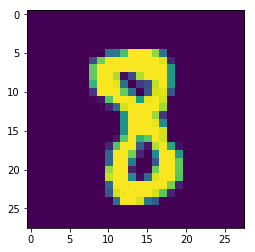

In [52]:
for epoch in range(numEpoch):

    for batch_idx,data in enumerate(trainLoader):

        z = 2*torch.rand(data.size()[0], zdim, device=dev)-1
        print('data size = ', data.size())
        xhat = gen(z)
        print('Size of z is ',z.size())
        print('Size of xhat is ',xhat.size())
        print('xhat = ',xhat)
        #print('xhat=',xhat)



        if batch_idx==0 and epoch==0:

            plt.imshow(data[0,0,:,:].detach().cpu().numpy())
            print(data[0,0,:,:])
            plt.savefig("goal.pdf")

            #plt.show()



        if batch_idx==0 and epoch%50==0:

            tmpimg = xhat[0:64,:,:,:].detach().cpu()
            print('tmpimg = ',tmpimg)
            save_image(tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True)

            #plt.imshow(tmpimg[0,0,:,:].cpu().numpy())

            #plt.savefig("test_{0}.pdf".format(epoch))

            #plt.ion()

            #plt.show()

            #plt.pause(0.001)



        dopt.zero_grad()

        for k in range(discIter):

            print('Before concate')
            print(data.size())
            print('before detach', xhat.size())
            print(xhat.detach().size())
            
            logit = disc(torch.cat((data,xhat.detach()),0))

            ##############################

            ## implement the discriminator loss (-logD trick)

            ##############################
            print('Logit=',logit.size())
            
            loss = criterion(logit,data[batch_idx] )
            print("E: %d; B: %d" % (epoch,batch_idx))
            #print("E: %d; B: %d; DLoss: %f" % (epoch,batch_idx,loss.item()))

            loss.backward()

            dopt.step()

            dopt.zero_grad()



        gopt.zero_grad()

        for k in range(genIter):

            xhat = gen(z)

            logit = disc(xhat)

            ##############################

            ## implement the generator loss (-logD trick)

            ##############################

            #loss = criterion(, )

            loss.backward()
            
            #print("E: %d; B: %d; GLoss: %f" % (epoch,batch_idx,loss.item()))

            gopt.step()

            gopt.zero_grad()